# Knee KL Grade Classification Pipeline

This notebook reproduces the workflow for the paper "Ensemble deep‐learning networks for automated osteoarthritis grading in knee X‐ray images". It covers training, testing, ensembling, and evaluation.

**Prerequisites:**
1. Ensure you are in the `OAI-KL/` directory.
2. Ensure your dataset is located at `./KneeXray/` with `train` and `test` subfolders as expected by the scripts.
3. Install necessary libraries: `pip install pandas numpy matplotlib scikit-learn torch torchvision albumentations opencv-python tqdm ttach natsort`

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import sys
import seaborn as sns
import glob
import argparse
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as snsy
from tqdm import tqdm
from collections import Counter
import natsort

# Torch imports
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay

# Local imports (assuming files are in the same directory)
# If these fail, ensure you are running this notebook from the OAI-KL directory
try:
    from dataset import ImageDataset
    # from early_stop import EarlyStopping
    from model import model_return
    import ttach
except ImportError:
    print("Error: Local modules not found. Please ensure this notebook is in the 'OAI-KL' directory.")

/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class EarlyStopping:
    def __init__(self, args, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
        """
        self.args = args
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        # FIX: Changed np.Inf to np.inf for NumPy 2.0 compatibility
        self.val_loss_min = np.inf 
        self.delta = delta

    def save_checkpoint(self, val_loss, model, args, fold, epoch):
        if self.verbose:
            print(f"Valid Loss ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving Model ...")
            
        image_size_tuple = (args.img_size, args.image_size)
        
        # Create directory if it doesn't exist (added safety)
        import os
        save_path = f'./models/{args.model_type}/{image_size_tuple}/'
        os.makedirs(save_path, exist_ok=True)
        
        save_file = f'{save_path}{fold}fold_epoch{epoch}.pt'
        
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), save_file)
        else:
            torch.save(model.state_dict(), save_file)
            
        self.val_loss_min = val_loss
        
    def __call__(self, val_loss, model, args, fold, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, args, fold, epoch)
        elif self.best_score - self.delta > score:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.best_score < score:
                self.best_score = score
            self.save_checkpoint(val_loss, model, args, fold, epoch)
            self.counter = 0

In [4]:
class Config:
    def __init__(self):
        self.seed = 42
        self.batch_size = 16
        self.epochs = 30
        self.learning_rate = 0.01
        self.n_splits = 5  # Stratified K-Fold
        self.image_size = 224 # Default, will be updated per model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Models listed in the README/model.py
        self.models_to_train = [
            {'name': 'densenet_161', 'size': 224},
            {'name': 'efficientnet_b5', 'size': 224}, # Note: EfficientNet usually takes larger inputs, adjusting to match repo defaults if needed
            {'name': 'efficientnet_v2_s', 'size': 224},
            {'name': 'regnet_y_8gf', 'size': 224},
            {'name': 'resnet_101', 'size': 224},
            {'name': 'resnext_50_32x4d', 'size': 224},
            {'name': 'wide_resnet_50_2', 'size': 224},
            {'name': 'shufflenet_v2_x2_0', 'size': 224}
        ]

config = Config()
torch.manual_seed(config.seed)
print(f"Running on device: {config.device}")

Running on device: cuda


In [4]:
def generate_csv(root_dir, save_path):
    if os.path.exists(save_path):
        print(f"{save_path} already exists. Skipping.")
        return

    print(f"Generating {save_path}...")
    # Mapping folder names to labels 0-4
    data = []
    labels = []
    
    # Assuming structure: root_dir/0/image.jpg, root_dir/1/image.jpg, etc.
    for label_idx in range(5):
        path = os.path.join(root_dir, str(label_idx), '*.*')
        files = glob.glob(path)
        data.extend(files)
        labels.extend([label_idx] * len(files))
    
    df = pd.DataFrame({'data': data, 'label': labels})
    df.to_csv(save_path, index=False)
    print(f"Saved {len(df)} entries to {save_path}")

# Paths based on make_csv.py logic
# Note: Adjust these paths if your dataset structure differs
train_img_dir = '../KneeXray/train' # Update this if your folder is named HH_1 or similar
test_img_dir = '../KneeXray/test'

# Check if we need to make CSVs
# In the repo, main.py reads './KneeXray/train/train.csv'
generate_csv(train_img_dir, '../KneeXray/train/train.csv')

# Test CSV usually named test_correct.csv in the repo scripts
generate_csv(test_img_dir, '../KneeXray/test/test_correct.csv')

../KneeXray/train/train.csv already exists. Skipping.
../KneeXray/test/test_correct.csv already exists. Skipping.


In [5]:
def train_model(model_name, img_size): 
    print(f"\n{'='*40}")
    print(f"STARTING TRAINING: {model_name} (Size: {img_size})")
    print(f"{'='*40}")

    # Mock Args for compatibility with repo functions
    class Args:
        model_type = model_name
        image_size = img_size       
        optimizer = 'Adam' 
    
    args = Args()
    image_size_tuple = (img_size, img_size)

    # Directory for saving models
    save_dir = f'../models/{model_name}/{image_size_tuple}'
    os.makedirs(save_dir, exist_ok=True)

    # Load Data
    train_csv = pd.read_csv('../KneeXray/train/train.csv')
    
    train_transform = A.Compose([
        A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC, p=1),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=20, p=1),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC, p=1), 
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    train_dataset = ImageDataset(train_csv, transforms=train_transform)
    val_dataset = ImageDataset(train_csv, transforms=val_transform) 

    splits = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)
    labels = train_dataset.get_labels()

    # Fold Loop
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(train_dataset)), labels), start=1):
        print(f"\n--- FOLD {fold}/{config.n_splits} ---")
        
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, sampler=val_sampler)

        # Initialize Model
        model_ft = model_return(args)
        if torch.cuda.device_count() > 1:
            model_ft = nn.DataParallel(model_ft)
        model_ft = model_ft.to(config.device)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.01)
        
        # Early Stopping
        early_stopping = EarlyStopping(args, patience=7, verbose=True, delta=0.1)
        
        # Epoch Loop
        history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(1, config.epochs + 1):
            if epoch == 2:
                print("Unfreezing all parameters...")
                for param in model_ft.parameters():
                    param.requires_grad = True
                optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), weight_decay=0.0001, lr=0.001)
                scheduler = MultiStepLR(optimizer, milestones=[2], gamma=0.1)
            else:
                scheduler = None

            # Train
            model_ft.train()
            train_loss = 0.0
            for batch in tqdm(train_loader, desc=f'Ep {epoch} Train', leave=False):
                optimizer.zero_grad()
                image, target = batch['image'].to(config.device), batch['target'].to(config.device)
                output = model_ft(image)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            if scheduler: scheduler.step()

            # Validate
            model_ft.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f'Ep {epoch} Val', leave=False):
                    image, target = batch['image'].to(config.device), batch['target'].to(config.device)
                    output = model_ft(image)
                    loss = criterion(output, target)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")
            
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            early_stopping(val_loss, model_ft, args, fold, epoch)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        
        # Plot Loss
        plt.figure(figsize=(6, 4))
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} Fold {fold} Loss')
        plt.legend()
        plt.show()

In [6]:
# def test_models(model_config_list):
#     print(f"\n{'='*40}")
#     print(f"STARTING TESTING PHASE")
#     print(f"{'='*40}")
    
#     test_csv = pd.read_csv("../KneeXray/test/test_correct.csv")
    
#     # TTA Transform (Test Time Augmentation)
#     transform_ttach = ttach.Compose([
#         ttach.HorizontalFlip(),
#     ])

#     for config_item in model_config_list:
#         model_name = config_item['name']
#         img_size = config_item['size'] # Renamed variable
#         image_size_tuple = (img_size, img_size) 
        
#         class Args:
#             model_type = model_name
#             image_size = img_size 
#         args = Args()

#         model_path = f'./models/{model_name}/{image_size_tuple}'
#         submission_path = f'./submission/{model_name}/{image_size_tuple}'
#         os.makedirs(submission_path, exist_ok=True)
        
#         if not os.path.exists(model_path):
#             print(f"Skipping {model_name}: No model directory found.")
#             continue

#         model_files = [f for f in os.listdir(model_path) if f.endswith('.pt')]
#         model_files = natsort.natsorted(model_files)

#         # Data Loader
#         transform = A.Compose([
#             A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC, p=1), 
#             A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#             ToTensorV2()
#         ])
#         test_data = ImageDataset(test_csv, transforms=transform)
#         testloader = DataLoader(test_data, batch_size=1, shuffle=False)

#         for m_file in model_files:
#             base_name = os.path.splitext(m_file)[0]
#             out_file = os.path.join(submission_path, f'{base_name}_submission.csv')
            
#             if os.path.exists(out_file):
#                 print(f"Skipping {base_name}: Submission exists.")
#                 continue

#             print(f"Processing {model_name} -> {base_name}...")
            
#             # Load Model
#             model_ft = model_return(args)
#             checkpoint_path = os.path.join(model_path, m_file)
            
#             # Set weights_only=True to avoid the security warning
#             state_dict = torch.load(checkpoint_path, map_location=config.device, weights_only=True) 
            
#             if list(state_dict.keys())[0].startswith('module.'):
#                 state_dict = {k[7:]: v for k, v in state_dict.items()}
            
#             model_ft.load_state_dict(state_dict)
#             model_ft.eval()
#             model_ft.to(config.device)
#             model_ft = ttach.ClassificationTTAWrapper(model_ft, transform_ttach)
            
#             # Inference
#             preds, probs_correct, probs_predict = [], [], []
#             p_arr = {k: [] for k in range(5)}
            
#             for batch in testloader:
#                 with torch.no_grad():
#                     image = batch['image'].to(config.device)
#                     target = batch['target'].to(config.device)
                    
#                     output = model_ft(image)
#                     preds.extend([i.item() for i in torch.argmax(output, axis=1)])
                    
#                     softmax = nn.Softmax(dim=1)
#                     softmax_output = softmax(output).detach().cpu().numpy()[0]
                    
#                     probs_correct.append(softmax_output[int(target)])
#                     probs_predict.append(max(softmax_output))
#                     for k in range(5):
#                         p_arr[k].append(softmax_output[k])
            
#             # Save Submission
#             submit_df = pd.DataFrame({
#                 'data': [i.split('/')[-1] for i in test_csv['data']], # <--- FIXED
#                 'label': preds,
#                 'prob_correct': probs_correct,
#                 'prob_predict': probs_predict,
#                 'prob_0': p_arr[0], 'prob_1': p_arr[1], 'prob_2': p_arr[2], 
#                 'prob_3': p_arr[3], 'prob_4': p_arr[4]
#             })
#             submit_df.to_csv(out_file, index=False)

In [20]:
def test_models(model_config_list):
    print(f"\n{'='*40}")
    print(f"STARTING TESTING PHASE (BEST MODELS ONLY)")
    print(f"{'='*40}")
    
    test_csv = pd.read_csv("../KneeXray/test/test_correct.csv")
    
    # TTA Transform (Test Time Augmentation)
    transform_ttach = ttach.Compose([
        ttach.HorizontalFlip(),
    ])

    for config_item in model_config_list:
        model_name = config_item['name']
        img_size = config_item['size'] # Renamed variable
        image_size_tuple = (img_size, img_size) 
        
        class Args:
            model_type = model_name
            image_size = img_size 
        args = Args()

        model_path = f'./models/{model_name}/{image_size_tuple}'
        submission_path = f'./submission/{model_name}/{image_size_tuple}'
        os.makedirs(submission_path, exist_ok=True)
        
        if not os.path.exists(model_path):
            print(f"Skipping {model_name}: No model directory found.")
            continue

        model_files = [f for f in os.listdir(model_path) if f.endswith('.pt')]
        
        # --- New Filtering Logic ---
        # Find the best model (highest epoch) for each fold
        best_models_per_fold = {}
        for f in model_files:
            try:
                # Parse filename like "1fold_epoch30.pt"
                parts = f.split('fold_epoch')
                fold_num = int(parts[0])
                epoch_num = int(parts[1].split('.pt')[0])
                
                if fold_num not in best_models_per_fold:
                    best_models_per_fold[fold_num] = (epoch_num, f)
                else:
                    # If this epoch is higher, it's a better (later) model
                    if epoch_num > best_models_per_fold[fold_num][0]:
                        best_models_per_fold[fold_num] = (epoch_num, f)
            except Exception as e:
                print(f"Could not parse filename: {f}. Skipping.")
        
        # Get just the filenames of the best models
        filtered_model_files = [f for (epoch, f) in best_models_per_fold.values()]
        
        if not filtered_model_files:
            print(f"No models found for {model_name}. Skipping.")
            continue
            
        print(f"Found {len(model_files)} total models, filtered to {len(filtered_model_files)} best models for testing.")
        # --- End New Logic ---

        # Data Loader
        transform = A.Compose([
            A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC, p=1), 
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        test_data = ImageDataset(test_csv, transforms=transform)
        testloader = DataLoader(test_data, batch_size=1, shuffle=False)

        # Now iterate over the *filtered* list
        for m_file in filtered_model_files:
            base_name = os.path.splitext(m_file)[0]
            out_file = os.path.join(submission_path, f'{base_name}_submission.csv')
            
            if os.path.exists(out_file):
                print(f"Skipping {base_name}: Submission exists.")
                continue

            print(f"Processing {model_name} -> {base_name}...")
            
            # Load Model
            model_ft = model_return(args)
            checkpoint_path = os.path.join(model_path, m_file)
            
            # Set weights_only=True to avoid the security warning
            state_dict = torch.load(checkpoint_path, map_location=config.device, weights_only=True) 
            
            if list(state_dict.keys())[0].startswith('module.'):
                state_dict = {k[7:]: v for k, v in state_dict.items()}
            
            model_ft.load_state_dict(state_dict)
            model_ft.eval()
            model_ft.to(config.device)
            model_ft = ttach.ClassificationTTAWrapper(model_ft, transform_ttach)
            
            # Inference
            preds, probs_correct, probs_predict = [], [], []
            p_arr = {k: [] for k in range(5)}
            
            for batch in testloader:
                with torch.no_grad():
                    image = batch['image'].to(config.device)
                    target = batch['target'].to(config.device)
                    
                    output = model_ft(image)
                    preds.extend([i.item() for i in torch.argmax(output, axis=1)])
                    
                    softmax = nn.Softmax(dim=1)
                    softmax_output = softmax(output).detach().cpu().numpy()[0]
                    
                    probs_correct.append(softmax_output[int(target)])
                    probs_predict.append(max(softmax_output))
                    for k in range(5):
                        p_arr[k].append(softmax_output[k])
            
            # Save Submission
            submit_df = pd.DataFrame({
                'data': [i.split('/')[-1] for i in test_csv['data']],
                'label': preds,
                'prob_correct': probs_correct,
                'prob_predict': probs_predict,
                'prob_0': p_arr[0], 'prob_1': p_arr[1], 'prob_2': p_arr[2], 
                'prob_3': p_arr[3], 'prob_4': p_arr[4]
            })
            submit_df.to_csv(out_file, index=False)

In [8]:
# def run_ensemble():
#     print(f"\n{'='*40}")
#     print(f"STARTING ENSEMBLE")
#     print(f"{'='*40}")

#     # Gather all submission CSVs recursively
#     submission_files = []
#     base_sub_dir = './submission'
#     for root, dirs, files in os.walk(base_sub_dir):
#         for file in files:
#             if file.endswith('.csv') and 'ensemble' not in file:
#                 submission_files.append(os.path.join(root, file))
    
#     if not submission_files:
#         print("No submission files found to ensemble!")
#         return

#     print(f"Ensembling {len(submission_files)} models...")
    
#     test_csv = pd.read_csv('../KneeXray/test/test_correct.csv')
#     test_labels = test_csv['label'].values
#     num_samples = len(test_csv)
    
#     # Aggregators
#     # Shape: [Samples, Classes]
#     accumulated_probs = np.zeros((num_samples, 5))
#     # Shape: [Samples, Models] for hard voting
#     all_preds = np.zeros((num_samples, len(submission_files)), dtype=int)
    
#     for idx, fpath in enumerate(submission_files):
#         df = pd.read_csv(fpath)
#         # Add probabilities
#         probs = df[['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4']].values
#         accumulated_probs += probs
#         # Store preds
#         all_preds[:, idx] = df['label'].values
        
#     # Average Probabilities
#     avg_probs = accumulated_probs / len(submission_files)
    
#     # 1. Hard Voting
#     hard_preds = []
#     for i in range(num_samples):
#         row_preds = all_preds[i, :]
#         counts = Counter(row_preds)
#         most_common = counts.most_common()
#         # If tie, take max count, if double tie, repo logic says take min class or specific logic
#         # Repo logic: if count >= 2 select min class, else max(labels, key=count)
#         max_count = most_common[0][1]
#         candidates = [k for k, v in counts.items() if v == max_count]
        
#         if len(candidates) > 1:
#             hard_preds.append(min(candidates))
#         else:
#             hard_preds.append(candidates[0])
            
#     # 2. Soft Voting
#     soft_preds = np.argmax(avg_probs, axis=1)
    
#     # 3. Mix Voting (Repo Logic: If max_count >= 2 use Soft, else Hard)
#     mix_preds = []
#     for i in range(num_samples):
#         row_preds = all_preds[i, :]
#         counts = Counter(row_preds)
#         max_count = counts.most_common()[0][1]
        
#         if max_count >= 2:
#             # Use Soft result for this sample
#             mix_preds.append(soft_preds[i])
#         else:
#             # Use Hard result (which is essentially the single vote if max_count is 1, or majority)
#             mix_preds.append(hard_preds[i])
            
#     return {
#         'hard': (hard_preds, avg_probs),
#         'soft': (soft_preds, avg_probs),
#         'mix': (mix_preds, avg_probs),
#         'truth': test_labels
#     }

# ensemble_results = run_ensemble()


STARTING ENSEMBLE
Ensembling 130 models...


In [18]:
def run_ensemble():
    print(f"\n{'='*40}")
    print(f"STARTING ENSEMBLE (BEST MODELS ONLY)")
    print(f"{'='*40}")

    base_sub_dir = './submission'
    all_best_csvs = [] # This will hold the final list of CSVs to ensemble

    # We must find the "best" CSV (highest epoch) per fold, *per model architecture*.
    # os.walk will go down into each model's submission folder
    for root, dirs, files in os.walk(base_sub_dir):
        # We only care about directories that actually contain submission CSVs
        csv_files = [f for f in files if f.endswith('.csv') and 'ensemble' not in f]
        
        if not csv_files:
            continue # This directory has no CSVs, move on
            
        print(f"Found {len(csv_files)} submissions in {root}. Filtering for best per fold...")

        # --- Filtering Logic (same as test_models, but for CSVs) ---
        best_csvs_per_fold = {}
        for f in csv_files:
            try:
                # Parse filename like "1fold_epoch30_submission.csv"
                parts = f.split('fold_epoch')
                if len(parts) < 2: continue # Not a file we can parse
                
                fold_num = int(parts[0])
                # Find the epoch number, which is between "fold_epoch" and "_submission.csv"
                epoch_num = int(parts[1].split('_submission.csv')[0])
                
                if fold_num not in best_csvs_per_fold:
                    best_csvs_per_fold[fold_num] = (epoch_num, f)
                else:
                    # If this epoch is higher, it's a better (later) model
                    if epoch_num > best_csvs_per_fold[fold_num][0]:
                        best_csvs_per_fold[fold_num] = (epoch_num, f)
            except Exception as e:
                print(f"Could not parse filename: {f}. Skipping.")
        
        # Add the full paths of the best CSVs to our main list
        for (epoch, f_name) in best_csvs_per_fold.values():
            all_best_csvs.append(os.path.join(root, f_name))
            
    if not all_best_csvs:
        print("No best-submission files found to ensemble!")
        return

    print(f"\nFound {len(all_best_csvs)} total best models to ensemble.")
    
    # --- Load Test Data ---
    # Assumes notebook is in OAI-KL, so path is ./KneeXray
    test_csv = pd.read_csv('../KneeXray/test/test_correct.csv')
    test_labels = test_csv['label'].values
    num_samples = len(test_csv)
    
    # --- Aggregators ---
    accumulated_probs = np.zeros((num_samples, 5))
    all_preds = np.zeros((num_samples, len(all_best_csvs)), dtype=int)
    
    for idx, fpath in enumerate(all_best_csvs): # Use the filtered list
        df = pd.read_csv(fpath)
        probs = df[['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4']].values
        accumulated_probs += probs
        all_preds[:, idx] = df['label'].values
        
    avg_probs = accumulated_probs / len(all_best_csvs)
    
    # --- Voting Logic (Following test_ensemble.py rules) ---
    
    # 1. Hard Voting (with repo's tie-breaking rule)
    hard_preds = []
    for i in range(num_samples):
        counts = Counter(all_preds[i, :])
        max_count = max(counts.values())
        
        # Check if there's a tie for the max count
        if list(counts.values()).count(max_count) >= 2:
            most_common = [num for num, count in counts.items() if count == max_count]
            hard_preds.append(min(most_common)) # Tie-break by selecting minimum class
        else:
            hard_preds.append(max(counts, key=counts.get)) # No tie, just get the max
            
    # 2. Soft Voting
    soft_preds = np.argmax(avg_probs, axis=1)
    
    # 3. Mix Voting (Logic from test_ensemble.py)
    # If there is a tie in hard votes, use the soft vote. Otherwise, use the hard vote.
    mix_preds = []
    for i in range(num_samples):
        counts = Counter(all_preds[i, :])
        max_count = max(counts.values())
        
        # Check for tie
        if list(counts.values()).count(max_count) >= 2: # This is a tie
            mix_preds.append(soft_preds[i]) # Use Soft
        else: # No tie
            mix_preds.append(hard_preds[i]) # Use Hard
            
    return {
        'hard': (hard_preds, avg_probs),
        'soft': (soft_preds, avg_probs),
        'mix': (mix_preds, avg_probs),
        'truth': test_labels
    }

# --- Run the Ensemble and Plot Results ---
# The README states Mix Voting is the final method, so we plot that.
ensemble_results = run_ensemble()
# plot_results(ensemble_results, mode='mix')


STARTING ENSEMBLE (BEST MODELS ONLY)
No best-submission files found to ensemble!


In [10]:
def plot_results(results_dict, mode='mix'):
    if not results_dict: return

    preds, probs = results_dict[mode]
    truth = results_dict['truth']
    
    # Metrics
    acc = accuracy_score(truth, preds)
    f1 = f1_score(truth, preds, average='macro')
    print(f"\nResults for {mode.upper()} Voting:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(truth, preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(truth, preds, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1)
    plt.title(f'Confusion Matrix ({mode} voting)\nAccuracy: {acc*100:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve (One vs Rest)
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(truth, classes=[0, 1, 2, 3, 4])
    
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(5):
        RocCurveDisplay.from_predictions(
            y_test_bin[:, i], 
            probs[:, i], 
            name=f'Grade {i}',
            ax=ax
        )
    plt.title(f'ROC Curves ({mode})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.show()

# if ensemble_results:
    # plot_results(ensemble_results, mode='mix')
    # You can also check 'hard' or 'soft'
    # plot_results(ensemble_results, mode='soft')


STARTING TRAINING: densenet_161 (Size: 224)

--- FOLD 1/5 ---


Epoch 1: Train Loss 1.7854 | Val Loss 1.7784
Valid Loss (inf --> 1.778448).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.4662 | Val Loss 1.3875
Valid Loss (1.778448 --> 1.387523).  Saving Model ...


Epoch 3: Train Loss 1.2891 | Val Loss 1.3864
Valid Loss (1.387523 --> 1.386416).  Saving Model ...


Epoch 4: Train Loss 1.2696 | Val Loss 1.3548
Valid Loss (1.386416 --> 1.354849).  Saving Model ...


Epoch 5: Train Loss 1.3090 | Val Loss 2.2713
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.3350 | Val Loss 1.1803
Valid Loss (1.354849 --> 1.180301).  Saving Model ...


Epoch 7: Train Loss 1.2358 | Val Loss 1.5202
EarlyStopping counter: 1 out of 7


Epoch 8: Train Loss 1.1945 | Val Loss 1.1669
Valid Loss (1.180301 --> 1.166892).  Saving Model ...


Epoch 9: Train Loss 1.1853 | Val Loss 1.4973
EarlyStopping counter: 1 out of 7


Epoch 10: Train Loss 1.1866 | Val Loss 1.4876
EarlyStopping counter: 2 out of 7


Epoch 11: Train Loss 1.1509 | Val Loss 1.1489
Valid Loss (1.166892 --> 1.148895).  Saving Model ...


Epoch 12: Train Loss 1.1486 | Val Loss 1.1682
Valid Loss (1.148895 --> 1.168162).  Saving Model ...


Epoch 13: Train Loss 1.1391 | Val Loss 1.1528
Valid Loss (1.168162 --> 1.152795).  Saving Model ...


Epoch 14: Train Loss 1.1303 | Val Loss 1.1054
Valid Loss (1.152795 --> 1.105376).  Saving Model ...


Epoch 15: Train Loss 1.1213 | Val Loss 1.1686
Valid Loss (1.105376 --> 1.168571).  Saving Model ...


Epoch 16: Train Loss 1.0999 | Val Loss 1.1789
Valid Loss (1.168571 --> 1.178949).  Saving Model ...


Epoch 17: Train Loss 1.1122 | Val Loss 1.0683
Valid Loss (1.178949 --> 1.068328).  Saving Model ...


Epoch 18: Train Loss 1.1001 | Val Loss 1.2322
EarlyStopping counter: 1 out of 7


Epoch 19: Train Loss 1.0878 | Val Loss 1.1434
Valid Loss (1.068328 --> 1.143356).  Saving Model ...


Epoch 20: Train Loss 1.0768 | Val Loss 1.0442
Valid Loss (1.143356 --> 1.044249).  Saving Model ...


Epoch 21: Train Loss 1.0884 | Val Loss 4.8192
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 1.0760 | Val Loss 1.0388
Valid Loss (1.044249 --> 1.038845).  Saving Model ...


Epoch 23: Train Loss 1.0665 | Val Loss 1.3988
EarlyStopping counter: 1 out of 7


Epoch 24: Train Loss 1.0558 | Val Loss 1.1500
EarlyStopping counter: 2 out of 7


Epoch 25: Train Loss 1.0581 | Val Loss 1.4462
EarlyStopping counter: 3 out of 7


Epoch 26: Train Loss 1.0417 | Val Loss 1.0990
Valid Loss (1.038845 --> 1.099044).  Saving Model ...


Epoch 27: Train Loss 1.0372 | Val Loss 1.1483
EarlyStopping counter: 1 out of 7


Epoch 28: Train Loss 1.0391 | Val Loss 1.1759
EarlyStopping counter: 2 out of 7


Epoch 29: Train Loss 1.0397 | Val Loss 1.0632
Valid Loss (1.099044 --> 1.063236).  Saving Model ...


Epoch 30: Train Loss 1.0429 | Val Loss 0.9817
Valid Loss (1.063236 --> 0.981724).  Saving Model ...


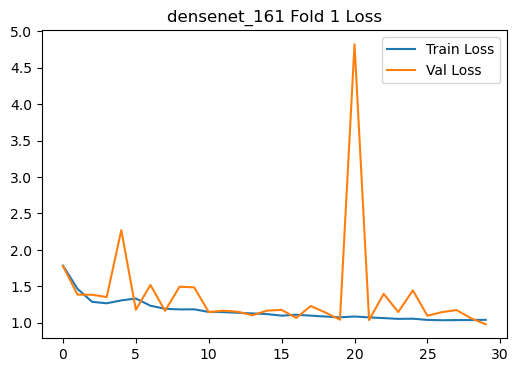


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.8726 | Val Loss 1.4998
Valid Loss (inf --> 1.499795).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.5258 | Val Loss 1.4103
Valid Loss (1.499795 --> 1.410341).  Saving Model ...


Epoch 3: Train Loss 1.4954 | Val Loss 1.7666
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.5061 | Val Loss 1.4628
Valid Loss (1.410341 --> 1.462825).  Saving Model ...


Epoch 5: Train Loss 1.4840 | Val Loss 9.1497
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.4980 | Val Loss 1.4729
Valid Loss (1.462825 --> 1.472920).  Saving Model ...


Epoch 7: Train Loss 1.4836 | Val Loss 1.9357
EarlyStopping counter: 1 out of 7


Epoch 8: Train Loss 1.5068 | Val Loss 6.6440
EarlyStopping counter: 2 out of 7


Epoch 9: Train Loss 1.4773 | Val Loss 1.4777
Valid Loss (1.472920 --> 1.477679).  Saving Model ...


Epoch 10: Train Loss 1.4711 | Val Loss 1.4466
Valid Loss (1.477679 --> 1.446592).  Saving Model ...


Epoch 11: Train Loss 1.4784 | Val Loss 1.5930
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.4860 | Val Loss 1.4561
Valid Loss (1.446592 --> 1.456146).  Saving Model ...


Epoch 13: Train Loss 1.4790 | Val Loss 1.5009
Valid Loss (1.456146 --> 1.500895).  Saving Model ...


Epoch 14: Train Loss 1.4812 | Val Loss 1.5253
EarlyStopping counter: 1 out of 7


Epoch 15: Train Loss 1.4725 | Val Loss 1.4785
Valid Loss (1.500895 --> 1.478509).  Saving Model ...


Epoch 16: Train Loss 1.4745 | Val Loss 1.4695
Valid Loss (1.478509 --> 1.469458).  Saving Model ...


Epoch 17: Train Loss 1.4764 | Val Loss 1.5745
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 1.4809 | Val Loss 10.5230
EarlyStopping counter: 2 out of 7


Epoch 19: Train Loss 1.4755 | Val Loss 1.5378
EarlyStopping counter: 3 out of 7


Epoch 20: Train Loss 1.4667 | Val Loss 1.4933
Valid Loss (1.469458 --> 1.493326).  Saving Model ...


Epoch 21: Train Loss 1.4636 | Val Loss 1.5403
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 1.4639 | Val Loss 1.4614
Valid Loss (1.493326 --> 1.461423).  Saving Model ...


Epoch 23: Train Loss 1.4666 | Val Loss 1.4853
Valid Loss (1.461423 --> 1.485259).  Saving Model ...


Epoch 24: Train Loss 1.4634 | Val Loss 1.4506
Valid Loss (1.485259 --> 1.450578).  Saving Model ...


Epoch 25: Train Loss 1.4697 | Val Loss 1.4752
Valid Loss (1.450578 --> 1.475164).  Saving Model ...


Epoch 26: Train Loss 1.4648 | Val Loss 1.4717
Valid Loss (1.475164 --> 1.471744).  Saving Model ...


Epoch 27: Train Loss 1.4565 | Val Loss 1.4488
Valid Loss (1.471744 --> 1.448821).  Saving Model ...


Epoch 28: Train Loss 1.4537 | Val Loss 1.4841
Valid Loss (1.448821 --> 1.484054).  Saving Model ...


Epoch 29: Train Loss 1.4566 | Val Loss 2.2080
EarlyStopping counter: 1 out of 7


Epoch 30: Train Loss 1.4560 | Val Loss 1.4457
Valid Loss (1.484054 --> 1.445682).  Saving Model ...


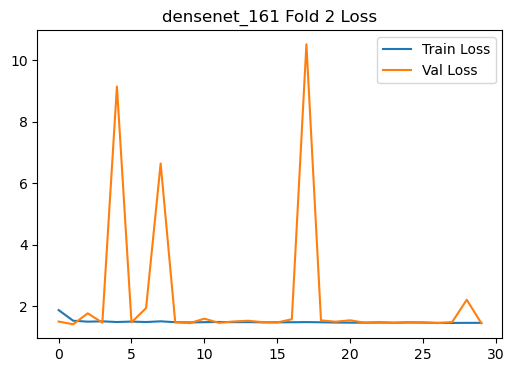


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.8537 | Val Loss 2.1349
Valid Loss (inf --> 2.134875).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.4842 | Val Loss 1.3914
Valid Loss (2.134875 --> 1.391353).  Saving Model ...


Epoch 3: Train Loss 1.4024 | Val Loss 2.7277
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.3760 | Val Loss 1.7715
EarlyStopping counter: 2 out of 7


Epoch 5: Train Loss 1.3561 | Val Loss 1.3566
Valid Loss (1.391353 --> 1.356584).  Saving Model ...


Epoch 6: Train Loss 1.2949 | Val Loss 1.2807
Valid Loss (1.356584 --> 1.280723).  Saving Model ...


Epoch 7: Train Loss 1.3031 | Val Loss 1.2591
Valid Loss (1.280723 --> 1.259076).  Saving Model ...


Epoch 8: Train Loss 1.2839 | Val Loss 1.2516
Valid Loss (1.259076 --> 1.251555).  Saving Model ...


Epoch 9: Train Loss 1.2410 | Val Loss 1.2445
Valid Loss (1.251555 --> 1.244471).  Saving Model ...


Epoch 10: Train Loss 1.2190 | Val Loss 1.1995
Valid Loss (1.244471 --> 1.199503).  Saving Model ...


Epoch 11: Train Loss 1.2011 | Val Loss 1.4036
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.1649 | Val Loss 1.2770
Valid Loss (1.199503 --> 1.277019).  Saving Model ...


Epoch 13: Train Loss 1.1669 | Val Loss 1.2881
Valid Loss (1.277019 --> 1.288136).  Saving Model ...


Epoch 14: Train Loss 1.1738 | Val Loss 1.2601
Valid Loss (1.288136 --> 1.260109).  Saving Model ...


Epoch 15: Train Loss 1.1747 | Val Loss 1.4428
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 1.1605 | Val Loss 2.8662
EarlyStopping counter: 2 out of 7


Epoch 17: Train Loss 1.1338 | Val Loss 1.2061
Valid Loss (1.260109 --> 1.206095).  Saving Model ...


Epoch 18: Train Loss 1.1105 | Val Loss 1.1915
Valid Loss (1.206095 --> 1.191463).  Saving Model ...


Epoch 19: Train Loss 1.0993 | Val Loss 1.2030
Valid Loss (1.191463 --> 1.203046).  Saving Model ...


Epoch 20: Train Loss 1.0890 | Val Loss 1.1754
Valid Loss (1.203046 --> 1.175398).  Saving Model ...


Epoch 21: Train Loss 1.0953 | Val Loss 1.1020
Valid Loss (1.175398 --> 1.101997).  Saving Model ...


Epoch 22: Train Loss 1.0831 | Val Loss 1.2123
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 1.0796 | Val Loss 1.5524
EarlyStopping counter: 2 out of 7


Epoch 24: Train Loss 1.0864 | Val Loss 1.0716
Valid Loss (1.101997 --> 1.071640).  Saving Model ...


Epoch 25: Train Loss 1.0640 | Val Loss 1.3196
EarlyStopping counter: 1 out of 7


Epoch 26: Train Loss 1.0550 | Val Loss 1.1309
Valid Loss (1.071640 --> 1.130867).  Saving Model ...


Epoch 27: Train Loss 1.0664 | Val Loss 1.0834
Valid Loss (1.130867 --> 1.083369).  Saving Model ...


Epoch 28: Train Loss 1.0649 | Val Loss 2.8873
EarlyStopping counter: 1 out of 7


Epoch 29: Train Loss 1.0454 | Val Loss 1.0215
Valid Loss (1.083369 --> 1.021506).  Saving Model ...


Epoch 30: Train Loss 1.0223 | Val Loss 1.0114
Valid Loss (1.021506 --> 1.011403).  Saving Model ...


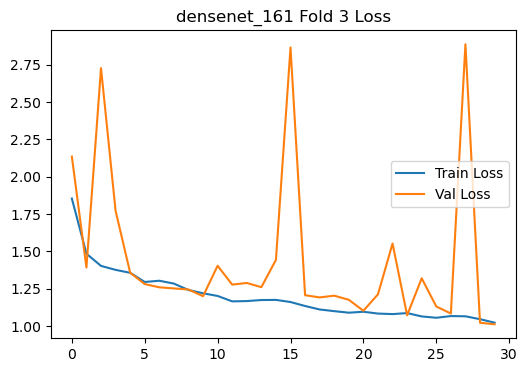


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.7827 | Val Loss 2.3694
Valid Loss (inf --> 2.369404).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.5557 | Val Loss 1.8576
Valid Loss (2.369404 --> 1.857634).  Saving Model ...


Epoch 3: Train Loss 1.4217 | Val Loss 697.4133
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.3394 | Val Loss 1.4394
Valid Loss (1.857634 --> 1.439407).  Saving Model ...


Epoch 5: Train Loss 1.2793 | Val Loss 2.4332
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.2407 | Val Loss 1.7332
EarlyStopping counter: 2 out of 7


Epoch 7: Train Loss 1.2371 | Val Loss 1.7558
EarlyStopping counter: 3 out of 7


Epoch 8: Train Loss 1.2339 | Val Loss 1.2816
Valid Loss (1.439407 --> 1.281628).  Saving Model ...


Epoch 9: Train Loss 1.1779 | Val Loss 1.1737
Valid Loss (1.281628 --> 1.173712).  Saving Model ...


Epoch 10: Train Loss 1.1597 | Val Loss 1.9527
EarlyStopping counter: 1 out of 7


Epoch 11: Train Loss 1.1592 | Val Loss 2.1897
EarlyStopping counter: 2 out of 7


Epoch 12: Train Loss 1.2667 | Val Loss 1.2699
Valid Loss (1.173712 --> 1.269864).  Saving Model ...


Epoch 13: Train Loss 1.1711 | Val Loss 1.2061
Valid Loss (1.269864 --> 1.206121).  Saving Model ...


Epoch 14: Train Loss 1.1723 | Val Loss 1.4406
EarlyStopping counter: 1 out of 7


Epoch 15: Train Loss 1.1674 | Val Loss 1.1787
Valid Loss (1.206121 --> 1.178670).  Saving Model ...


Epoch 16: Train Loss 1.1236 | Val Loss 1.1980
Valid Loss (1.178670 --> 1.197989).  Saving Model ...


Epoch 17: Train Loss 1.1169 | Val Loss 1.1665
Valid Loss (1.197989 --> 1.166481).  Saving Model ...


Epoch 18: Train Loss 1.1123 | Val Loss 1.2416
Valid Loss (1.166481 --> 1.241628).  Saving Model ...


Epoch 19: Train Loss 1.1101 | Val Loss 1.1095
Valid Loss (1.241628 --> 1.109500).  Saving Model ...


Epoch 20: Train Loss 1.1299 | Val Loss 1.1960
Valid Loss (1.109500 --> 1.195982).  Saving Model ...


Epoch 21: Train Loss 1.1032 | Val Loss 1.0641
Valid Loss (1.195982 --> 1.064060).  Saving Model ...


Epoch 22: Train Loss 1.0924 | Val Loss 1.6012
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 1.0841 | Val Loss 1.1304
Valid Loss (1.064060 --> 1.130435).  Saving Model ...


Epoch 24: Train Loss 1.0652 | Val Loss 1.2152
EarlyStopping counter: 1 out of 7


Epoch 25: Train Loss 1.0766 | Val Loss 1.2402
EarlyStopping counter: 2 out of 7


Epoch 26: Train Loss 1.0846 | Val Loss 1.4272
EarlyStopping counter: 3 out of 7


Epoch 27: Train Loss 1.0687 | Val Loss 1.0625
Valid Loss (1.130435 --> 1.062548).  Saving Model ...


Epoch 28: Train Loss 1.0551 | Val Loss 1.1376
Valid Loss (1.062548 --> 1.137551).  Saving Model ...


Epoch 29: Train Loss 1.0538 | Val Loss 1.0910
Valid Loss (1.137551 --> 1.090950).  Saving Model ...


Epoch 30: Train Loss 1.0534 | Val Loss 1.0715
Valid Loss (1.090950 --> 1.071505).  Saving Model ...


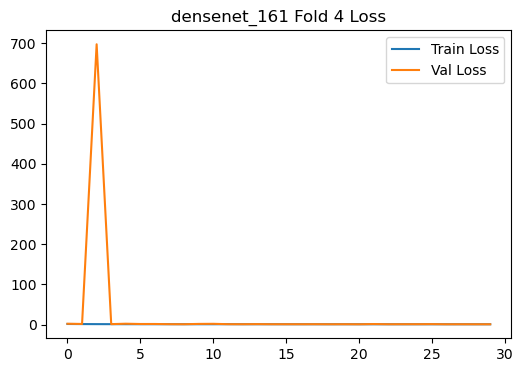


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.7604 | Val Loss 1.5100
Valid Loss (inf --> 1.510012).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.4670 | Val Loss 1.2927
Valid Loss (1.510012 --> 1.292748).  Saving Model ...


Epoch 3: Train Loss 1.2942 | Val Loss 1.3841
Valid Loss (1.292748 --> 1.384064).  Saving Model ...


Epoch 4: Train Loss 1.2532 | Val Loss 4.0364
EarlyStopping counter: 1 out of 7


Epoch 5: Train Loss 1.2539 | Val Loss 1.2250
Valid Loss (1.384064 --> 1.225017).  Saving Model ...


Epoch 6: Train Loss 1.1832 | Val Loss 1.5301
EarlyStopping counter: 1 out of 7


Epoch 7: Train Loss 1.1744 | Val Loss 1.2064
Valid Loss (1.225017 --> 1.206432).  Saving Model ...


Epoch 8: Train Loss 1.1982 | Val Loss 1.1534
Valid Loss (1.206432 --> 1.153386).  Saving Model ...


Epoch 9: Train Loss 1.1555 | Val Loss 1.1414
Valid Loss (1.153386 --> 1.141437).  Saving Model ...


Epoch 10: Train Loss 1.1470 | Val Loss 1.1050
Valid Loss (1.141437 --> 1.104974).  Saving Model ...


Epoch 11: Train Loss 1.1320 | Val Loss 1.1595
Valid Loss (1.104974 --> 1.159515).  Saving Model ...


Epoch 12: Train Loss 1.1389 | Val Loss 1.0972
Valid Loss (1.159515 --> 1.097206).  Saving Model ...


Epoch 13: Train Loss 1.1277 | Val Loss 1.1136
Valid Loss (1.097206 --> 1.113560).  Saving Model ...


Epoch 14: Train Loss 1.1189 | Val Loss 1.1386
Valid Loss (1.113560 --> 1.138577).  Saving Model ...


Epoch 15: Train Loss 1.1049 | Val Loss 1.2594
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 1.1005 | Val Loss 1.4880
EarlyStopping counter: 2 out of 7


Epoch 17: Train Loss 1.0975 | Val Loss 1.1623
Valid Loss (1.138577 --> 1.162330).  Saving Model ...


Epoch 18: Train Loss 1.0808 | Val Loss 1.0405
Valid Loss (1.162330 --> 1.040543).  Saving Model ...


Epoch 19: Train Loss 1.0958 | Val Loss 1.2193
EarlyStopping counter: 1 out of 7


Epoch 20: Train Loss 1.0749 | Val Loss 1.0951
Valid Loss (1.040543 --> 1.095082).  Saving Model ...


Epoch 21: Train Loss 1.0689 | Val Loss 1.1395
Valid Loss (1.095082 --> 1.139543).  Saving Model ...


Epoch 22: Train Loss 1.0614 | Val Loss 1.1502
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 1.0532 | Val Loss 1.0486
Valid Loss (1.139543 --> 1.048631).  Saving Model ...


Epoch 24: Train Loss 1.0430 | Val Loss 1.0840
Valid Loss (1.048631 --> 1.083958).  Saving Model ...


Epoch 25: Train Loss 1.0426 | Val Loss 1.0310
Valid Loss (1.083958 --> 1.031048).  Saving Model ...


Epoch 26: Train Loss 1.0307 | Val Loss 1.1042
Valid Loss (1.031048 --> 1.104155).  Saving Model ...


Epoch 27: Train Loss 1.0331 | Val Loss 1.1044
Valid Loss (1.104155 --> 1.104355).  Saving Model ...


Epoch 28: Train Loss 1.0252 | Val Loss 1.0446
Valid Loss (1.104355 --> 1.044649).  Saving Model ...


Epoch 29: Train Loss 1.0260 | Val Loss 1.1611
EarlyStopping counter: 1 out of 7


Epoch 30: Train Loss 1.0198 | Val Loss 1.0287
Valid Loss (1.044649 --> 1.028729).  Saving Model ...


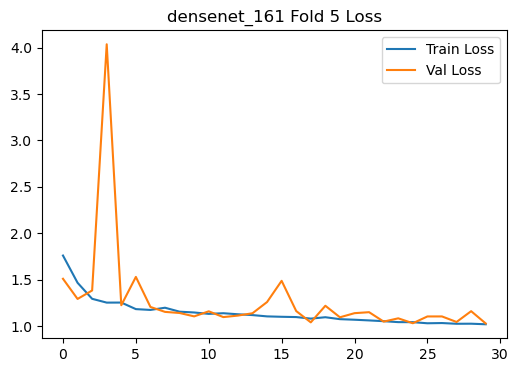


STARTING TRAINING: efficientnet_b5 (Size: 224)

--- FOLD 1/5 ---


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /home/usama/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:02<00:00, 47.2MB/s] 


Epoch 1: Train Loss 1.8664 | Val Loss 1.7484
Valid Loss (inf --> 1.748405).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.4281 | Val Loss 1.2053
Valid Loss (1.748405 --> 1.205323).  Saving Model ...


Epoch 3: Train Loss 1.1531 | Val Loss 1.2320
Valid Loss (1.205323 --> 1.232024).  Saving Model ...


Epoch 4: Train Loss 1.0879 | Val Loss 1.0544
Valid Loss (1.232024 --> 1.054429).  Saving Model ...


Epoch 5: Train Loss 1.0432 | Val Loss 0.9799
Valid Loss (1.054429 --> 0.979870).  Saving Model ...


Epoch 6: Train Loss 1.0314 | Val Loss 0.9837
Valid Loss (0.979870 --> 0.983673).  Saving Model ...


Epoch 7: Train Loss 1.0196 | Val Loss 1.0894
EarlyStopping counter: 1 out of 7


Epoch 8: Train Loss 1.0108 | Val Loss 1.0184
Valid Loss (0.983673 --> 1.018448).  Saving Model ...


Epoch 9: Train Loss 0.9971 | Val Loss 1.0431
Valid Loss (1.018448 --> 1.043119).  Saving Model ...


Epoch 10: Train Loss 0.9939 | Val Loss 1.1300
EarlyStopping counter: 1 out of 7


Epoch 11: Train Loss 0.9797 | Val Loss 1.1785
EarlyStopping counter: 2 out of 7


Epoch 12: Train Loss 0.9759 | Val Loss 0.9946
Valid Loss (1.043119 --> 0.994573).  Saving Model ...


Epoch 13: Train Loss 0.9668 | Val Loss 0.9672
Valid Loss (0.994573 --> 0.967230).  Saving Model ...


Epoch 14: Train Loss 0.9594 | Val Loss 0.9843
Valid Loss (0.967230 --> 0.984313).  Saving Model ...


Epoch 15: Train Loss 0.9686 | Val Loss 0.9724
Valid Loss (0.984313 --> 0.972388).  Saving Model ...


Epoch 16: Train Loss 0.9531 | Val Loss 1.0432
Valid Loss (0.972388 --> 1.043155).  Saving Model ...


Epoch 17: Train Loss 0.9549 | Val Loss 1.0435
Valid Loss (1.043155 --> 1.043547).  Saving Model ...


Epoch 18: Train Loss 0.9411 | Val Loss 1.2078
EarlyStopping counter: 1 out of 7


Epoch 19: Train Loss 0.9393 | Val Loss 1.1559
EarlyStopping counter: 2 out of 7


Epoch 20: Train Loss 0.9426 | Val Loss 1.0953
EarlyStopping counter: 3 out of 7


Epoch 21: Train Loss 0.9313 | Val Loss 0.9519
Valid Loss (1.043547 --> 0.951891).  Saving Model ...


Epoch 22: Train Loss 0.9177 | Val Loss 1.0290
Valid Loss (0.951891 --> 1.029027).  Saving Model ...


Epoch 23: Train Loss 0.9189 | Val Loss 0.9701
Valid Loss (1.029027 --> 0.970073).  Saving Model ...


Epoch 24: Train Loss 0.9061 | Val Loss 1.0259
Valid Loss (0.970073 --> 1.025876).  Saving Model ...


Epoch 25: Train Loss 0.8983 | Val Loss 0.9620
Valid Loss (1.025876 --> 0.962037).  Saving Model ...


Epoch 26: Train Loss 0.8880 | Val Loss 0.9933
Valid Loss (0.962037 --> 0.993278).  Saving Model ...


Epoch 27: Train Loss 0.8833 | Val Loss 1.0056
Valid Loss (0.993278 --> 1.005639).  Saving Model ...


Epoch 28: Train Loss 0.8901 | Val Loss 0.9467
Valid Loss (1.005639 --> 0.946656).  Saving Model ...


Epoch 29: Train Loss 0.8764 | Val Loss 0.9667
Valid Loss (0.946656 --> 0.966710).  Saving Model ...


Epoch 30: Train Loss 0.8669 | Val Loss 1.1512
EarlyStopping counter: 1 out of 7


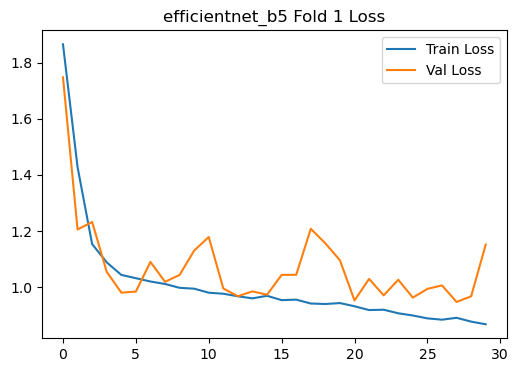


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.8504 | Val Loss 1.7442
Valid Loss (inf --> 1.744165).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.4021 | Val Loss 1.3355
Valid Loss (1.744165 --> 1.335499).  Saving Model ...


Epoch 3: Train Loss 1.1380 | Val Loss 1.0240
Valid Loss (1.335499 --> 1.023990).  Saving Model ...


Epoch 4: Train Loss 1.0760 | Val Loss 1.1078
Valid Loss (1.023990 --> 1.107772).  Saving Model ...


Epoch 5: Train Loss 1.0451 | Val Loss 1.1521
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.0247 | Val Loss 0.9674
Valid Loss (1.107772 --> 0.967414).  Saving Model ...


Epoch 7: Train Loss 1.0060 | Val Loss 1.0222
Valid Loss (0.967414 --> 1.022151).  Saving Model ...


Epoch 8: Train Loss 0.9921 | Val Loss 1.0002
Valid Loss (1.022151 --> 1.000232).  Saving Model ...


Epoch 9: Train Loss 0.9799 | Val Loss 0.9884
Valid Loss (1.000232 --> 0.988406).  Saving Model ...


Epoch 10: Train Loss 0.9752 | Val Loss 0.9995
Valid Loss (0.988406 --> 0.999500).  Saving Model ...


Epoch 11: Train Loss 0.9871 | Val Loss 1.0772
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 0.9826 | Val Loss 0.9700
Valid Loss (0.999500 --> 0.969996).  Saving Model ...


Epoch 13: Train Loss 0.9499 | Val Loss 1.0975
EarlyStopping counter: 1 out of 7


Epoch 14: Train Loss 0.9624 | Val Loss 0.9722
Valid Loss (0.969996 --> 0.972234).  Saving Model ...


Epoch 15: Train Loss 0.9600 | Val Loss 0.9821
Valid Loss (0.972234 --> 0.982117).  Saving Model ...


Epoch 16: Train Loss 0.9597 | Val Loss 0.9592
Valid Loss (0.982117 --> 0.959229).  Saving Model ...


Epoch 17: Train Loss 0.9382 | Val Loss 1.0005
Valid Loss (0.959229 --> 1.000512).  Saving Model ...


Epoch 18: Train Loss 0.9391 | Val Loss 1.0064
Valid Loss (1.000512 --> 1.006405).  Saving Model ...


Epoch 19: Train Loss 0.9353 | Val Loss 1.1915
EarlyStopping counter: 1 out of 7


Epoch 20: Train Loss 0.9324 | Val Loss 1.0154
Valid Loss (1.006405 --> 1.015370).  Saving Model ...


Epoch 21: Train Loss 0.9117 | Val Loss 0.9857
Valid Loss (1.015370 --> 0.985685).  Saving Model ...


Epoch 22: Train Loss 0.9165 | Val Loss 1.0061
Valid Loss (0.985685 --> 1.006068).  Saving Model ...


Epoch 23: Train Loss 0.8986 | Val Loss 1.0402
Valid Loss (1.006068 --> 1.040230).  Saving Model ...


Epoch 24: Train Loss 0.8962 | Val Loss 0.9731
Valid Loss (1.040230 --> 0.973142).  Saving Model ...


Epoch 25: Train Loss 0.8933 | Val Loss 0.9971
Valid Loss (0.973142 --> 0.997094).  Saving Model ...


Epoch 26: Train Loss 0.8836 | Val Loss 0.9395
Valid Loss (0.997094 --> 0.939465).  Saving Model ...


Epoch 27: Train Loss 0.8878 | Val Loss 0.9737
Valid Loss (0.939465 --> 0.973722).  Saving Model ...


Epoch 28: Train Loss 0.8778 | Val Loss 1.1785
EarlyStopping counter: 1 out of 7


Epoch 29: Train Loss 0.8730 | Val Loss 0.9887
Valid Loss (0.973722 --> 0.988747).  Saving Model ...


Epoch 30: Train Loss 0.8715 | Val Loss 0.9954
Valid Loss (0.988747 --> 0.995364).  Saving Model ...


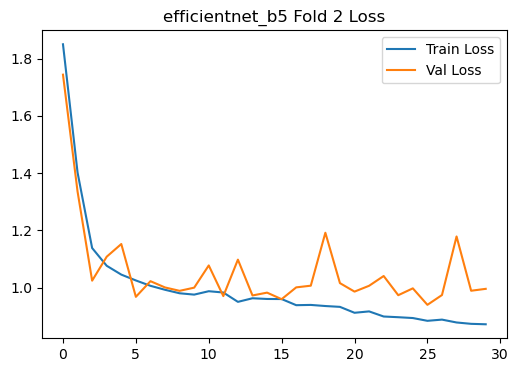


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.8475 | Val Loss 1.7170
Valid Loss (inf --> 1.716953).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3793 | Val Loss 1.2794
Valid Loss (1.716953 --> 1.279369).  Saving Model ...


Epoch 3: Train Loss 1.1316 | Val Loss 1.0864
Valid Loss (1.279369 --> 1.086403).  Saving Model ...


Epoch 4: Train Loss 1.0752 | Val Loss 1.0324
Valid Loss (1.086403 --> 1.032424).  Saving Model ...


Epoch 5: Train Loss 1.0326 | Val Loss 1.0572
Valid Loss (1.032424 --> 1.057156).  Saving Model ...


Epoch 6: Train Loss 1.0180 | Val Loss 1.0214
Valid Loss (1.057156 --> 1.021388).  Saving Model ...


Epoch 7: Train Loss 1.0113 | Val Loss 1.0899
Valid Loss (1.021388 --> 1.089917).  Saving Model ...


Epoch 8: Train Loss 0.9942 | Val Loss 1.0348
Valid Loss (1.089917 --> 1.034783).  Saving Model ...


Epoch 9: Train Loss 0.9977 | Val Loss 1.0924
Valid Loss (1.034783 --> 1.092415).  Saving Model ...


Epoch 10: Train Loss 0.9804 | Val Loss 1.0427
Valid Loss (1.092415 --> 1.042724).  Saving Model ...


Epoch 11: Train Loss 0.9727 | Val Loss 1.0291
Valid Loss (1.042724 --> 1.029055).  Saving Model ...


Epoch 12: Train Loss 0.9738 | Val Loss 1.0633
Valid Loss (1.029055 --> 1.063350).  Saving Model ...


Epoch 13: Train Loss 0.9676 | Val Loss 1.0295
Valid Loss (1.063350 --> 1.029516).  Saving Model ...


Epoch 14: Train Loss 0.9597 | Val Loss 0.9945
Valid Loss (1.029516 --> 0.994524).  Saving Model ...


Epoch 15: Train Loss 0.9423 | Val Loss 1.0031
Valid Loss (0.994524 --> 1.003078).  Saving Model ...


Epoch 16: Train Loss 0.9338 | Val Loss 1.0136
Valid Loss (1.003078 --> 1.013621).  Saving Model ...


Epoch 17: Train Loss 0.9264 | Val Loss 1.0234
Valid Loss (1.013621 --> 1.023403).  Saving Model ...


Epoch 18: Train Loss 0.9250 | Val Loss 1.1239
EarlyStopping counter: 1 out of 7


Epoch 19: Train Loss 0.9285 | Val Loss 1.0415
Valid Loss (1.023403 --> 1.041473).  Saving Model ...


Epoch 20: Train Loss 0.9081 | Val Loss 1.0553
Valid Loss (1.041473 --> 1.055277).  Saving Model ...


Epoch 21: Train Loss 0.9120 | Val Loss 1.0840
Valid Loss (1.055277 --> 1.084015).  Saving Model ...


Epoch 22: Train Loss 0.9009 | Val Loss 1.1255
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 0.9145 | Val Loss 1.0033
Valid Loss (1.084015 --> 1.003332).  Saving Model ...


Epoch 24: Train Loss 0.8925 | Val Loss 1.0714
Valid Loss (1.003332 --> 1.071416).  Saving Model ...


Epoch 25: Train Loss 0.8855 | Val Loss 1.0154
Valid Loss (1.071416 --> 1.015432).  Saving Model ...


Epoch 26: Train Loss 0.8773 | Val Loss 0.9812
Valid Loss (1.015432 --> 0.981220).  Saving Model ...


Epoch 27: Train Loss 0.8704 | Val Loss 0.9458
Valid Loss (0.981220 --> 0.945813).  Saving Model ...


Epoch 28: Train Loss 0.8649 | Val Loss 0.9826
Valid Loss (0.945813 --> 0.982617).  Saving Model ...


Epoch 29: Train Loss 0.8569 | Val Loss 1.0135
Valid Loss (0.982617 --> 1.013537).  Saving Model ...


Epoch 30: Train Loss 0.8472 | Val Loss 0.9959
Valid Loss (1.013537 --> 0.995918).  Saving Model ...


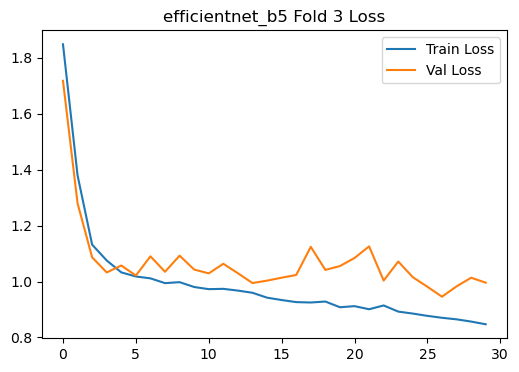


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.8517 | Val Loss 1.6806
Valid Loss (inf --> 1.680633).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3788 | Val Loss 1.4044
Valid Loss (1.680633 --> 1.404396).  Saving Model ...


Epoch 3: Train Loss 1.1195 | Val Loss 1.5136
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.0793 | Val Loss 1.3010
Valid Loss (1.404396 --> 1.301012).  Saving Model ...


Epoch 5: Train Loss 1.0311 | Val Loss 1.0585
Valid Loss (1.301012 --> 1.058468).  Saving Model ...


Epoch 6: Train Loss 1.0200 | Val Loss 1.0625
Valid Loss (1.058468 --> 1.062486).  Saving Model ...


Epoch 7: Train Loss 1.0164 | Val Loss 1.0795
Valid Loss (1.062486 --> 1.079533).  Saving Model ...


Epoch 8: Train Loss 1.0039 | Val Loss 1.0093
Valid Loss (1.079533 --> 1.009324).  Saving Model ...


Epoch 9: Train Loss 0.9830 | Val Loss 1.0188
Valid Loss (1.009324 --> 1.018807).  Saving Model ...


Epoch 10: Train Loss 0.9870 | Val Loss 1.0985
Valid Loss (1.018807 --> 1.098513).  Saving Model ...


Epoch 11: Train Loss 0.9764 | Val Loss 1.2297
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 0.9740 | Val Loss 1.1275
EarlyStopping counter: 2 out of 7


Epoch 13: Train Loss 0.9686 | Val Loss 1.0075
Valid Loss (1.098513 --> 1.007520).  Saving Model ...


Epoch 14: Train Loss 0.9654 | Val Loss 1.0221
Valid Loss (1.007520 --> 1.022055).  Saving Model ...


Epoch 15: Train Loss 0.9630 | Val Loss 1.0225
Valid Loss (1.022055 --> 1.022469).  Saving Model ...


Epoch 16: Train Loss 0.9534 | Val Loss 1.0110
Valid Loss (1.022469 --> 1.010953).  Saving Model ...


Epoch 17: Train Loss 0.9386 | Val Loss 1.0190
Valid Loss (1.010953 --> 1.019038).  Saving Model ...


Epoch 18: Train Loss 0.9408 | Val Loss 1.1801
EarlyStopping counter: 1 out of 7


Epoch 19: Train Loss 0.9270 | Val Loss 0.9929
Valid Loss (1.019038 --> 0.992943).  Saving Model ...


Epoch 20: Train Loss 0.9306 | Val Loss 1.0119
Valid Loss (0.992943 --> 1.011877).  Saving Model ...


Epoch 21: Train Loss 0.9132 | Val Loss 1.1552
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 0.9120 | Val Loss 0.9784
Valid Loss (1.011877 --> 0.978382).  Saving Model ...


Epoch 23: Train Loss 0.9050 | Val Loss 1.0703
Valid Loss (0.978382 --> 1.070283).  Saving Model ...


Epoch 24: Train Loss 0.9035 | Val Loss 1.0163
Valid Loss (1.070283 --> 1.016298).  Saving Model ...


Epoch 25: Train Loss 0.9014 | Val Loss 1.0035
Valid Loss (1.016298 --> 1.003499).  Saving Model ...


Epoch 26: Train Loss 0.8825 | Val Loss 1.0419
Valid Loss (1.003499 --> 1.041893).  Saving Model ...


Epoch 27: Train Loss 0.8895 | Val Loss 1.0432
Valid Loss (1.041893 --> 1.043182).  Saving Model ...


Epoch 28: Train Loss 0.8782 | Val Loss 0.9830
Valid Loss (1.043182 --> 0.982966).  Saving Model ...


Epoch 29: Train Loss 0.8798 | Val Loss 1.1207
EarlyStopping counter: 1 out of 7


Epoch 30: Train Loss 0.8723 | Val Loss 1.0499
Valid Loss (0.982966 --> 1.049883).  Saving Model ...


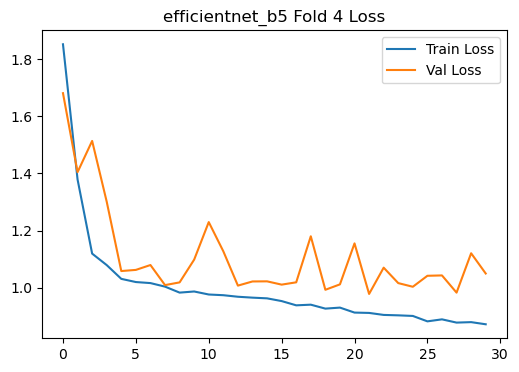


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.8576 | Val Loss 1.7967
Valid Loss (inf --> 1.796719).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.4049 | Val Loss 1.1738
Valid Loss (1.796719 --> 1.173775).  Saving Model ...


Epoch 3: Train Loss 1.1324 | Val Loss 1.1272
Valid Loss (1.173775 --> 1.127226).  Saving Model ...


Epoch 4: Train Loss 1.0617 | Val Loss 1.1133
Valid Loss (1.127226 --> 1.113255).  Saving Model ...


Epoch 5: Train Loss 1.0320 | Val Loss 0.9924
Valid Loss (1.113255 --> 0.992415).  Saving Model ...


Epoch 6: Train Loss 1.0282 | Val Loss 0.9779
Valid Loss (0.992415 --> 0.977854).  Saving Model ...


Epoch 7: Train Loss 0.9962 | Val Loss 1.0379
Valid Loss (0.977854 --> 1.037895).  Saving Model ...


Epoch 8: Train Loss 1.0047 | Val Loss 1.0009
Valid Loss (1.037895 --> 1.000916).  Saving Model ...


Epoch 9: Train Loss 0.9698 | Val Loss 1.0892
EarlyStopping counter: 1 out of 7


Epoch 10: Train Loss 0.9697 | Val Loss 1.0371
Valid Loss (1.000916 --> 1.037086).  Saving Model ...


Epoch 11: Train Loss 0.9852 | Val Loss 1.0191
Valid Loss (1.037086 --> 1.019074).  Saving Model ...


Epoch 12: Train Loss 0.9629 | Val Loss 1.1032
EarlyStopping counter: 1 out of 7


Epoch 13: Train Loss 0.9535 | Val Loss 0.9771
Valid Loss (1.019074 --> 0.977058).  Saving Model ...


Epoch 14: Train Loss 0.9602 | Val Loss 1.0070
Valid Loss (0.977058 --> 1.007030).  Saving Model ...


Epoch 15: Train Loss 0.9380 | Val Loss 1.0675
Valid Loss (1.007030 --> 1.067534).  Saving Model ...


Epoch 16: Train Loss 0.9504 | Val Loss 0.9992
Valid Loss (1.067534 --> 0.999222).  Saving Model ...


Epoch 17: Train Loss 0.9429 | Val Loss 1.1062
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 0.9332 | Val Loss 0.9793
Valid Loss (0.999222 --> 0.979276).  Saving Model ...


Epoch 19: Train Loss 0.9296 | Val Loss 1.0465
Valid Loss (0.979276 --> 1.046505).  Saving Model ...


Epoch 20: Train Loss 0.9244 | Val Loss 1.0247
Valid Loss (1.046505 --> 1.024728).  Saving Model ...


Epoch 21: Train Loss 0.9219 | Val Loss 1.0029
Valid Loss (1.024728 --> 1.002884).  Saving Model ...


Epoch 22: Train Loss 0.9051 | Val Loss 0.9894
Valid Loss (1.002884 --> 0.989426).  Saving Model ...


Epoch 23: Train Loss 0.9127 | Val Loss 0.9901
Valid Loss (0.989426 --> 0.990107).  Saving Model ...


Epoch 24: Train Loss 0.8955 | Val Loss 1.1225
EarlyStopping counter: 1 out of 7


Epoch 25: Train Loss 0.8886 | Val Loss 0.9984
Valid Loss (0.990107 --> 0.998388).  Saving Model ...


Epoch 26: Train Loss 0.8788 | Val Loss 0.9829
Valid Loss (0.998388 --> 0.982920).  Saving Model ...


Epoch 27: Train Loss 0.8655 | Val Loss 0.9923
Valid Loss (0.982920 --> 0.992341).  Saving Model ...


Epoch 28: Train Loss 0.8798 | Val Loss 1.0093
Valid Loss (0.992341 --> 1.009316).  Saving Model ...


Epoch 29: Train Loss 0.8683 | Val Loss 1.0617
Valid Loss (1.009316 --> 1.061730).  Saving Model ...


Epoch 30: Train Loss 0.8620 | Val Loss 0.9721
Valid Loss (1.061730 --> 0.972116).  Saving Model ...


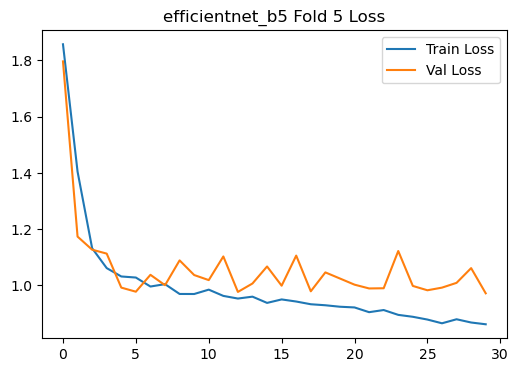


STARTING TRAINING: efficientnet_v2_s (Size: 224)

--- FOLD 1/5 ---


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/usama/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 47.1MB/s]


Epoch 1: Train Loss 1.7407 | Val Loss 1.6340
Valid Loss (inf --> 1.634032).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3149 | Val Loss 1.1141
Valid Loss (1.634032 --> 1.114126).  Saving Model ...


Epoch 3: Train Loss 1.1340 | Val Loss 1.0030
Valid Loss (1.114126 --> 1.003022).  Saving Model ...


Epoch 4: Train Loss 1.0925 | Val Loss 1.0549
Valid Loss (1.003022 --> 1.054875).  Saving Model ...


Epoch 5: Train Loss 1.0599 | Val Loss 1.0713
Valid Loss (1.054875 --> 1.071334).  Saving Model ...


Epoch 6: Train Loss 1.0439 | Val Loss 1.0067
Valid Loss (1.071334 --> 1.006687).  Saving Model ...


Epoch 7: Train Loss 1.0298 | Val Loss 1.0175
Valid Loss (1.006687 --> 1.017531).  Saving Model ...


Epoch 8: Train Loss 1.0200 | Val Loss 1.0236
Valid Loss (1.017531 --> 1.023624).  Saving Model ...


Epoch 9: Train Loss 1.0125 | Val Loss 1.0614
Valid Loss (1.023624 --> 1.061388).  Saving Model ...


Epoch 10: Train Loss 1.0138 | Val Loss 0.9971
Valid Loss (1.061388 --> 0.997079).  Saving Model ...


Epoch 11: Train Loss 0.9966 | Val Loss 0.9625
Valid Loss (0.997079 --> 0.962465).  Saving Model ...


Epoch 12: Train Loss 1.0091 | Val Loss 1.0202
Valid Loss (0.962465 --> 1.020191).  Saving Model ...


Epoch 13: Train Loss 0.9946 | Val Loss 1.0015
Valid Loss (1.020191 --> 1.001480).  Saving Model ...


Epoch 14: Train Loss 0.9833 | Val Loss 0.9707
Valid Loss (1.001480 --> 0.970683).  Saving Model ...


Epoch 15: Train Loss 0.9874 | Val Loss 0.9516
Valid Loss (0.970683 --> 0.951570).  Saving Model ...


Epoch 16: Train Loss 0.9765 | Val Loss 0.9705
Valid Loss (0.951570 --> 0.970465).  Saving Model ...


Epoch 17: Train Loss 0.9789 | Val Loss 1.0143
Valid Loss (0.970465 --> 1.014277).  Saving Model ...


Epoch 18: Train Loss 0.9740 | Val Loss 1.0001
Valid Loss (1.014277 --> 1.000106).  Saving Model ...


Epoch 19: Train Loss 0.9744 | Val Loss 1.0001
Valid Loss (1.000106 --> 1.000122).  Saving Model ...


Epoch 20: Train Loss 0.9530 | Val Loss 0.9920
Valid Loss (1.000122 --> 0.991996).  Saving Model ...


Epoch 21: Train Loss 0.9530 | Val Loss 0.9706
Valid Loss (0.991996 --> 0.970598).  Saving Model ...


Epoch 22: Train Loss 0.9617 | Val Loss 1.1156
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 0.9566 | Val Loss 1.0267
Valid Loss (0.970598 --> 1.026665).  Saving Model ...


Epoch 24: Train Loss 0.9360 | Val Loss 0.9541
Valid Loss (1.026665 --> 0.954137).  Saving Model ...


Epoch 25: Train Loss 0.9531 | Val Loss 0.9840
Valid Loss (0.954137 --> 0.983991).  Saving Model ...


Epoch 26: Train Loss 0.9483 | Val Loss 0.9327
Valid Loss (0.983991 --> 0.932694).  Saving Model ...


Epoch 27: Train Loss 0.9494 | Val Loss 0.9583
Valid Loss (0.932694 --> 0.958295).  Saving Model ...


Epoch 28: Train Loss 0.9395 | Val Loss 0.9562
Valid Loss (0.958295 --> 0.956200).  Saving Model ...


Epoch 29: Train Loss 0.9367 | Val Loss 0.9607
Valid Loss (0.956200 --> 0.960658).  Saving Model ...


Epoch 30: Train Loss 0.9316 | Val Loss 0.9843
Valid Loss (0.960658 --> 0.984312).  Saving Model ...


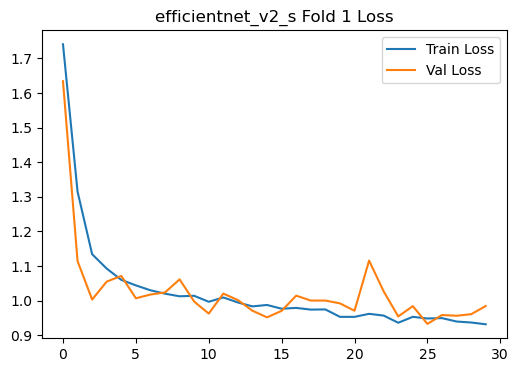


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.7396 | Val Loss 1.6571
Valid Loss (inf --> 1.657083).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2991 | Val Loss 1.1967
Valid Loss (1.657083 --> 1.196697).  Saving Model ...


Epoch 3: Train Loss 1.1385 | Val Loss 1.0985
Valid Loss (1.196697 --> 1.098471).  Saving Model ...


Epoch 4: Train Loss 1.0803 | Val Loss 0.9913
Valid Loss (1.098471 --> 0.991299).  Saving Model ...


Epoch 5: Train Loss 1.0599 | Val Loss 1.0241
Valid Loss (0.991299 --> 1.024131).  Saving Model ...


Epoch 6: Train Loss 1.0321 | Val Loss 0.9786
Valid Loss (1.024131 --> 0.978624).  Saving Model ...


Epoch 7: Train Loss 1.0319 | Val Loss 0.9888
Valid Loss (0.978624 --> 0.988750).  Saving Model ...


Epoch 8: Train Loss 1.0298 | Val Loss 1.0093
Valid Loss (0.988750 --> 1.009336).  Saving Model ...


Epoch 9: Train Loss 1.0104 | Val Loss 1.0057
Valid Loss (1.009336 --> 1.005744).  Saving Model ...


Epoch 10: Train Loss 1.0076 | Val Loss 1.0033
Valid Loss (1.005744 --> 1.003322).  Saving Model ...


Epoch 11: Train Loss 0.9997 | Val Loss 1.0463
Valid Loss (1.003322 --> 1.046330).  Saving Model ...


Epoch 12: Train Loss 1.0040 | Val Loss 0.9883
Valid Loss (1.046330 --> 0.988314).  Saving Model ...


Epoch 13: Train Loss 0.9876 | Val Loss 1.0799
EarlyStopping counter: 1 out of 7


Epoch 14: Train Loss 0.9860 | Val Loss 0.9811
Valid Loss (0.988314 --> 0.981064).  Saving Model ...


Epoch 15: Train Loss 1.0043 | Val Loss 0.9779
Valid Loss (0.981064 --> 0.977940).  Saving Model ...


Epoch 16: Train Loss 0.9795 | Val Loss 1.0339
Valid Loss (0.977940 --> 1.033883).  Saving Model ...


Epoch 17: Train Loss 0.9756 | Val Loss 0.9556
Valid Loss (1.033883 --> 0.955575).  Saving Model ...


Epoch 18: Train Loss 0.9682 | Val Loss 1.0031
Valid Loss (0.955575 --> 1.003062).  Saving Model ...


Epoch 19: Train Loss 0.9661 | Val Loss 0.9964
Valid Loss (1.003062 --> 0.996438).  Saving Model ...


Epoch 20: Train Loss 0.9694 | Val Loss 0.9548
Valid Loss (0.996438 --> 0.954817).  Saving Model ...


Epoch 21: Train Loss 0.9639 | Val Loss 0.9792
Valid Loss (0.954817 --> 0.979152).  Saving Model ...


Epoch 22: Train Loss 0.9626 | Val Loss 0.9929
Valid Loss (0.979152 --> 0.992914).  Saving Model ...


Epoch 23: Train Loss 0.9521 | Val Loss 0.9571
Valid Loss (0.992914 --> 0.957083).  Saving Model ...


Epoch 24: Train Loss 0.9576 | Val Loss 0.9693
Valid Loss (0.957083 --> 0.969256).  Saving Model ...


Epoch 25: Train Loss 0.9476 | Val Loss 0.9823
Valid Loss (0.969256 --> 0.982265).  Saving Model ...


Epoch 26: Train Loss 0.9577 | Val Loss 0.9250
Valid Loss (0.982265 --> 0.924978).  Saving Model ...


Epoch 27: Train Loss 0.9308 | Val Loss 0.9425
Valid Loss (0.924978 --> 0.942472).  Saving Model ...


Epoch 28: Train Loss 0.9382 | Val Loss 0.9695
Valid Loss (0.942472 --> 0.969480).  Saving Model ...


Epoch 29: Train Loss 0.9270 | Val Loss 1.0524
EarlyStopping counter: 1 out of 7


Epoch 30: Train Loss 0.9317 | Val Loss 0.9535
Valid Loss (0.969480 --> 0.953455).  Saving Model ...


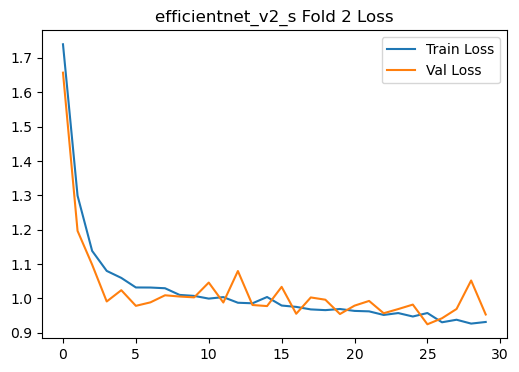


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.7302 | Val Loss 1.7470
Valid Loss (inf --> 1.746964).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3103 | Val Loss 1.1890
Valid Loss (1.746964 --> 1.189020).  Saving Model ...


Epoch 3: Train Loss 1.1540 | Val Loss 1.1629
Valid Loss (1.189020 --> 1.162864).  Saving Model ...


Epoch 4: Train Loss 1.1111 | Val Loss 1.1485
Valid Loss (1.162864 --> 1.148466).  Saving Model ...


Epoch 5: Train Loss 1.0687 | Val Loss 1.0418
Valid Loss (1.148466 --> 1.041845).  Saving Model ...


Epoch 6: Train Loss 1.0410 | Val Loss 1.0512
Valid Loss (1.041845 --> 1.051202).  Saving Model ...


Epoch 7: Train Loss 1.0431 | Val Loss 1.0317
Valid Loss (1.051202 --> 1.031661).  Saving Model ...


Epoch 8: Train Loss 1.0247 | Val Loss 1.0210
Valid Loss (1.031661 --> 1.020974).  Saving Model ...


Epoch 9: Train Loss 1.0258 | Val Loss 1.0983
Valid Loss (1.020974 --> 1.098253).  Saving Model ...


Epoch 10: Train Loss 1.0078 | Val Loss 0.9998
Valid Loss (1.098253 --> 0.999796).  Saving Model ...


Epoch 11: Train Loss 1.0038 | Val Loss 0.9937
Valid Loss (0.999796 --> 0.993666).  Saving Model ...


Epoch 12: Train Loss 1.0002 | Val Loss 0.9955
Valid Loss (0.993666 --> 0.995534).  Saving Model ...


Epoch 13: Train Loss 0.9938 | Val Loss 0.9855
Valid Loss (0.995534 --> 0.985461).  Saving Model ...


Epoch 14: Train Loss 0.9859 | Val Loss 1.0669
Valid Loss (0.985461 --> 1.066923).  Saving Model ...


Epoch 15: Train Loss 0.9842 | Val Loss 1.0278
Valid Loss (1.066923 --> 1.027846).  Saving Model ...


Epoch 16: Train Loss 0.9750 | Val Loss 1.0171
Valid Loss (1.027846 --> 1.017061).  Saving Model ...


Epoch 17: Train Loss 0.9811 | Val Loss 0.9890
Valid Loss (1.017061 --> 0.989029).  Saving Model ...


Epoch 18: Train Loss 0.9682 | Val Loss 0.9743
Valid Loss (0.989029 --> 0.974273).  Saving Model ...


Epoch 19: Train Loss 0.9568 | Val Loss 0.9978
Valid Loss (0.974273 --> 0.997804).  Saving Model ...


Epoch 20: Train Loss 0.9709 | Val Loss 0.9873
Valid Loss (0.997804 --> 0.987321).  Saving Model ...


Epoch 21: Train Loss 0.9611 | Val Loss 0.9677
Valid Loss (0.987321 --> 0.967697).  Saving Model ...


Epoch 22: Train Loss 0.9540 | Val Loss 1.0711
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 0.9624 | Val Loss 0.9727
Valid Loss (0.967697 --> 0.972663).  Saving Model ...


Epoch 24: Train Loss 0.9507 | Val Loss 1.0168
Valid Loss (0.972663 --> 1.016763).  Saving Model ...


Epoch 25: Train Loss 0.9513 | Val Loss 0.9749
Valid Loss (1.016763 --> 0.974942).  Saving Model ...


Epoch 26: Train Loss 0.9443 | Val Loss 0.9763
Valid Loss (0.974942 --> 0.976257).  Saving Model ...


Epoch 27: Train Loss 0.9415 | Val Loss 1.0599
Valid Loss (0.976257 --> 1.059918).  Saving Model ...


Epoch 28: Train Loss 0.9409 | Val Loss 0.9807
Valid Loss (1.059918 --> 0.980685).  Saving Model ...


Epoch 29: Train Loss 0.9406 | Val Loss 0.9818
Valid Loss (0.980685 --> 0.981843).  Saving Model ...


Epoch 30: Train Loss 0.9366 | Val Loss 0.9965
Valid Loss (0.981843 --> 0.996543).  Saving Model ...


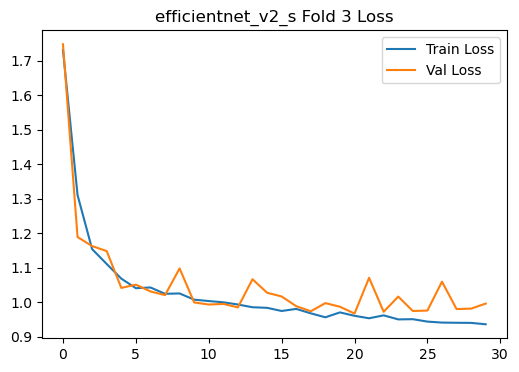


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.7137 | Val Loss 1.6205
Valid Loss (inf --> 1.620461).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3003 | Val Loss 1.2235
Valid Loss (1.620461 --> 1.223549).  Saving Model ...


Epoch 3: Train Loss 1.1443 | Val Loss 1.0982
Valid Loss (1.223549 --> 1.098211).  Saving Model ...


Epoch 4: Train Loss 1.0804 | Val Loss 1.0770
Valid Loss (1.098211 --> 1.077039).  Saving Model ...


Epoch 5: Train Loss 1.0591 | Val Loss 1.2930
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.0382 | Val Loss 1.0370
Valid Loss (1.077039 --> 1.036973).  Saving Model ...


Epoch 7: Train Loss 1.0192 | Val Loss 1.0534
Valid Loss (1.036973 --> 1.053399).  Saving Model ...


Epoch 8: Train Loss 1.0266 | Val Loss 0.9978
Valid Loss (1.053399 --> 0.997788).  Saving Model ...


Epoch 9: Train Loss 1.0128 | Val Loss 1.0203
Valid Loss (0.997788 --> 1.020336).  Saving Model ...


Epoch 10: Train Loss 1.0111 | Val Loss 1.0408
Valid Loss (1.020336 --> 1.040839).  Saving Model ...


Epoch 11: Train Loss 0.9963 | Val Loss 1.0096
Valid Loss (1.040839 --> 1.009644).  Saving Model ...


Epoch 12: Train Loss 0.9988 | Val Loss 1.0395
Valid Loss (1.009644 --> 1.039514).  Saving Model ...


Epoch 13: Train Loss 0.9951 | Val Loss 0.9830
Valid Loss (1.039514 --> 0.983029).  Saving Model ...


Epoch 14: Train Loss 0.9902 | Val Loss 0.9885
Valid Loss (0.983029 --> 0.988478).  Saving Model ...


Epoch 15: Train Loss 0.9790 | Val Loss 1.0657
Valid Loss (0.988478 --> 1.065683).  Saving Model ...


Epoch 16: Train Loss 0.9828 | Val Loss 0.9809
Valid Loss (1.065683 --> 0.980888).  Saving Model ...


Epoch 17: Train Loss 0.9725 | Val Loss 1.0108
Valid Loss (0.980888 --> 1.010770).  Saving Model ...


Epoch 18: Train Loss 0.9688 | Val Loss 1.0390
Valid Loss (1.010770 --> 1.039006).  Saving Model ...


Epoch 19: Train Loss 0.9680 | Val Loss 0.9925
Valid Loss (1.039006 --> 0.992484).  Saving Model ...


Epoch 20: Train Loss 0.9643 | Val Loss 0.9772
Valid Loss (0.992484 --> 0.977173).  Saving Model ...


Epoch 21: Train Loss 0.9679 | Val Loss 1.0448
Valid Loss (0.977173 --> 1.044810).  Saving Model ...


Epoch 22: Train Loss 0.9563 | Val Loss 1.0298
Valid Loss (1.044810 --> 1.029780).  Saving Model ...


Epoch 23: Train Loss 0.9542 | Val Loss 0.9696
Valid Loss (1.029780 --> 0.969612).  Saving Model ...


Epoch 24: Train Loss 0.9457 | Val Loss 0.9801
Valid Loss (0.969612 --> 0.980139).  Saving Model ...


Epoch 25: Train Loss 0.9422 | Val Loss 0.9739
Valid Loss (0.980139 --> 0.973865).  Saving Model ...


Epoch 26: Train Loss 0.9380 | Val Loss 0.9885
Valid Loss (0.973865 --> 0.988527).  Saving Model ...


Epoch 27: Train Loss 0.9330 | Val Loss 0.9926
Valid Loss (0.988527 --> 0.992572).  Saving Model ...


Epoch 28: Train Loss 0.9289 | Val Loss 0.9666
Valid Loss (0.992572 --> 0.966576).  Saving Model ...


Epoch 29: Train Loss 0.9314 | Val Loss 0.9954
Valid Loss (0.966576 --> 0.995355).  Saving Model ...


Epoch 30: Train Loss 0.9264 | Val Loss 0.9982
Valid Loss (0.995355 --> 0.998232).  Saving Model ...


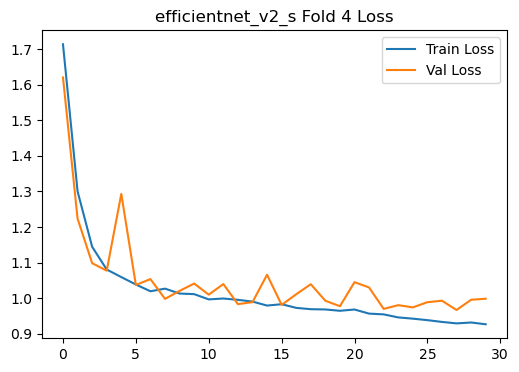


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.7390 | Val Loss 1.6856
Valid Loss (inf --> 1.685585).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3107 | Val Loss 1.1942
Valid Loss (1.685585 --> 1.194153).  Saving Model ...


Epoch 3: Train Loss 1.1557 | Val Loss 1.1460
Valid Loss (1.194153 --> 1.145977).  Saving Model ...


Epoch 4: Train Loss 1.1014 | Val Loss 1.1767
Valid Loss (1.145977 --> 1.176709).  Saving Model ...


Epoch 5: Train Loss 1.0627 | Val Loss 1.0712
Valid Loss (1.176709 --> 1.071237).  Saving Model ...


Epoch 6: Train Loss 1.0518 | Val Loss 1.0298
Valid Loss (1.071237 --> 1.029842).  Saving Model ...


Epoch 7: Train Loss 1.0395 | Val Loss 1.0100
Valid Loss (1.029842 --> 1.009966).  Saving Model ...


Epoch 8: Train Loss 1.0294 | Val Loss 1.0282
Valid Loss (1.009966 --> 1.028233).  Saving Model ...


Epoch 9: Train Loss 1.0129 | Val Loss 1.0008
Valid Loss (1.028233 --> 1.000832).  Saving Model ...


Epoch 10: Train Loss 1.0183 | Val Loss 1.0536
Valid Loss (1.000832 --> 1.053551).  Saving Model ...


Epoch 11: Train Loss 1.0137 | Val Loss 1.0447
Valid Loss (1.053551 --> 1.044652).  Saving Model ...


Epoch 12: Train Loss 1.0128 | Val Loss 0.9861
Valid Loss (1.044652 --> 0.986106).  Saving Model ...


Epoch 13: Train Loss 0.9990 | Val Loss 1.0396
Valid Loss (0.986106 --> 1.039600).  Saving Model ...


Epoch 14: Train Loss 0.9946 | Val Loss 1.0360
Valid Loss (1.039600 --> 1.036011).  Saving Model ...


Epoch 15: Train Loss 1.0004 | Val Loss 0.9847
Valid Loss (1.036011 --> 0.984674).  Saving Model ...


Epoch 16: Train Loss 0.9849 | Val Loss 1.0642
Valid Loss (0.984674 --> 1.064207).  Saving Model ...


Epoch 17: Train Loss 0.9732 | Val Loss 1.0011
Valid Loss (1.064207 --> 1.001128).  Saving Model ...


Epoch 18: Train Loss 0.9726 | Val Loss 1.0580
Valid Loss (1.001128 --> 1.057986).  Saving Model ...


Epoch 19: Train Loss 0.9828 | Val Loss 0.9922
Valid Loss (1.057986 --> 0.992229).  Saving Model ...


Epoch 20: Train Loss 0.9691 | Val Loss 1.2372
EarlyStopping counter: 1 out of 7


Epoch 21: Train Loss 0.9681 | Val Loss 1.0206
Valid Loss (0.992229 --> 1.020617).  Saving Model ...


Epoch 22: Train Loss 0.9594 | Val Loss 1.0490
Valid Loss (1.020617 --> 1.048969).  Saving Model ...


Epoch 23: Train Loss 0.9613 | Val Loss 1.0350
Valid Loss (1.048969 --> 1.034950).  Saving Model ...


Epoch 24: Train Loss 0.9508 | Val Loss 0.9900
Valid Loss (1.034950 --> 0.990045).  Saving Model ...


Epoch 25: Train Loss 0.9563 | Val Loss 0.9706
Valid Loss (0.990045 --> 0.970625).  Saving Model ...


Epoch 26: Train Loss 0.9440 | Val Loss 1.0510
Valid Loss (0.970625 --> 1.050966).  Saving Model ...


Epoch 27: Train Loss 0.9390 | Val Loss 0.9630
Valid Loss (1.050966 --> 0.962966).  Saving Model ...


Epoch 28: Train Loss 0.9411 | Val Loss 0.9756
Valid Loss (0.962966 --> 0.975632).  Saving Model ...


Epoch 29: Train Loss 0.9261 | Val Loss 0.9633
Valid Loss (0.975632 --> 0.963316).  Saving Model ...


Epoch 30: Train Loss 0.9284 | Val Loss 0.9846
Valid Loss (0.963316 --> 0.984577).  Saving Model ...


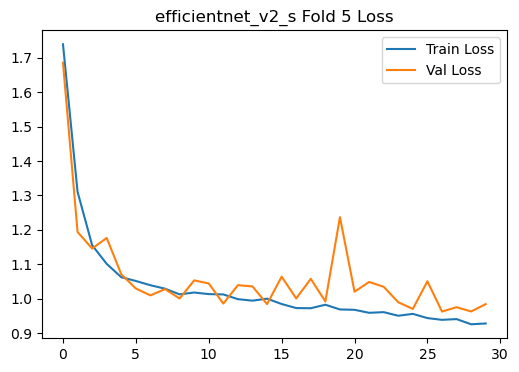


STARTING TRAINING: regnet_y_8gf (Size: 224)

--- FOLD 1/5 ---


Downloading: "https://download.pytorch.org/models/regnet_y_8gf-dc2b1b54.pth" to /home/usama/.cache/torch/hub/checkpoints/regnet_y_8gf-dc2b1b54.pth
100%|██████████| 151M/151M [00:03<00:00, 47.3MB/s] 


Epoch 1: Train Loss 1.7559 | Val Loss 1.8409
Valid Loss (inf --> 1.840889).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2184 | Val Loss 1.0980
Valid Loss (1.840889 --> 1.098004).  Saving Model ...


Epoch 3: Train Loss 1.1017 | Val Loss 1.0737
Valid Loss (1.098004 --> 1.073715).  Saving Model ...


Epoch 4: Train Loss 1.0640 | Val Loss 1.0394
Valid Loss (1.073715 --> 1.039352).  Saving Model ...


Epoch 5: Train Loss 1.0479 | Val Loss 1.0064
Valid Loss (1.039352 --> 1.006414).  Saving Model ...


Epoch 6: Train Loss 1.0555 | Val Loss 1.4557
EarlyStopping counter: 1 out of 7


Epoch 7: Train Loss 1.0408 | Val Loss 1.0355
Valid Loss (1.006414 --> 1.035527).  Saving Model ...


Epoch 8: Train Loss 1.0374 | Val Loss 0.9963
Valid Loss (1.035527 --> 0.996304).  Saving Model ...


Epoch 9: Train Loss 1.0286 | Val Loss 1.0605
Valid Loss (0.996304 --> 1.060478).  Saving Model ...


Epoch 10: Train Loss 1.0292 | Val Loss 1.0341
Valid Loss (1.060478 --> 1.034139).  Saving Model ...


Epoch 11: Train Loss 1.0278 | Val Loss 1.1587
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.0313 | Val Loss 1.0015
Valid Loss (1.034139 --> 1.001530).  Saving Model ...


Epoch 13: Train Loss 1.0082 | Val Loss 0.9943
Valid Loss (1.001530 --> 0.994340).  Saving Model ...


Epoch 14: Train Loss 1.0066 | Val Loss 1.0336
Valid Loss (0.994340 --> 1.033616).  Saving Model ...


Epoch 15: Train Loss 1.0031 | Val Loss 0.9769
Valid Loss (1.033616 --> 0.976930).  Saving Model ...


Epoch 16: Train Loss 0.9923 | Val Loss 1.1712
EarlyStopping counter: 1 out of 7


Epoch 17: Train Loss 0.9841 | Val Loss 1.0054
Valid Loss (0.976930 --> 1.005425).  Saving Model ...


Epoch 18: Train Loss 1.0015 | Val Loss 0.9738
Valid Loss (1.005425 --> 0.973816).  Saving Model ...


Epoch 19: Train Loss 0.9747 | Val Loss 1.0009
Valid Loss (0.973816 --> 1.000869).  Saving Model ...


Epoch 20: Train Loss 0.9692 | Val Loss 1.0088
Valid Loss (1.000869 --> 1.008798).  Saving Model ...


Epoch 21: Train Loss 0.9637 | Val Loss 0.9663
Valid Loss (1.008798 --> 0.966283).  Saving Model ...


Epoch 22: Train Loss 0.9646 | Val Loss 0.9859
Valid Loss (0.966283 --> 0.985924).  Saving Model ...


Epoch 23: Train Loss 0.9547 | Val Loss 0.9515
Valid Loss (0.985924 --> 0.951547).  Saving Model ...


Epoch 24: Train Loss 0.9458 | Val Loss 0.9556
Valid Loss (0.951547 --> 0.955649).  Saving Model ...


Epoch 25: Train Loss 0.9429 | Val Loss 0.9242
Valid Loss (0.955649 --> 0.924228).  Saving Model ...


Epoch 26: Train Loss 0.9397 | Val Loss 0.9511
Valid Loss (0.924228 --> 0.951118).  Saving Model ...


Epoch 27: Train Loss 0.9415 | Val Loss 1.0270
EarlyStopping counter: 1 out of 7


Epoch 28: Train Loss 0.9292 | Val Loss 0.9527
Valid Loss (0.951118 --> 0.952743).  Saving Model ...


Epoch 29: Train Loss 0.9405 | Val Loss 0.9557
Valid Loss (0.952743 --> 0.955739).  Saving Model ...


Epoch 30: Train Loss 0.9277 | Val Loss 0.9490
Valid Loss (0.955739 --> 0.948990).  Saving Model ...


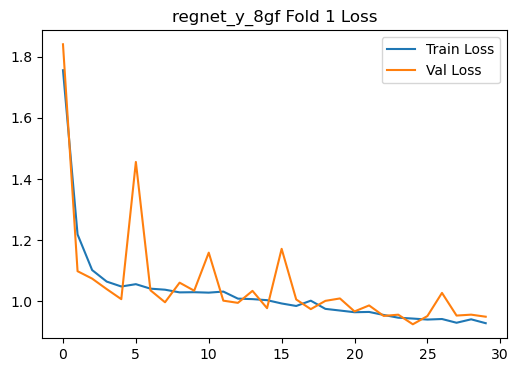


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.8190 | Val Loss 1.7244
Valid Loss (inf --> 1.724362).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2282 | Val Loss 1.2119
Valid Loss (1.724362 --> 1.211924).  Saving Model ...


Epoch 3: Train Loss 1.1031 | Val Loss 1.0330
Valid Loss (1.211924 --> 1.032979).  Saving Model ...


Epoch 4: Train Loss 1.0582 | Val Loss 1.0452
Valid Loss (1.032979 --> 1.045160).  Saving Model ...


Epoch 5: Train Loss 1.0444 | Val Loss 1.0478
Valid Loss (1.045160 --> 1.047761).  Saving Model ...


Epoch 6: Train Loss 1.0271 | Val Loss 1.0043
Valid Loss (1.047761 --> 1.004328).  Saving Model ...


Epoch 7: Train Loss 1.0297 | Val Loss 0.9947
Valid Loss (1.004328 --> 0.994688).  Saving Model ...


Epoch 8: Train Loss 1.0232 | Val Loss 1.1530
EarlyStopping counter: 1 out of 7


Epoch 9: Train Loss 1.0226 | Val Loss 1.1377
EarlyStopping counter: 2 out of 7


Epoch 10: Train Loss 1.0131 | Val Loss 1.0579
Valid Loss (0.994688 --> 1.057924).  Saving Model ...


Epoch 11: Train Loss 1.0125 | Val Loss 1.0432
Valid Loss (1.057924 --> 1.043221).  Saving Model ...


Epoch 12: Train Loss 1.0063 | Val Loss 1.0000
Valid Loss (1.043221 --> 0.999970).  Saving Model ...


Epoch 13: Train Loss 1.0015 | Val Loss 0.9783
Valid Loss (0.999970 --> 0.978331).  Saving Model ...


Epoch 14: Train Loss 0.9958 | Val Loss 1.0707
Valid Loss (0.978331 --> 1.070659).  Saving Model ...


Epoch 15: Train Loss 0.9967 | Val Loss 1.1281
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 0.9865 | Val Loss 0.9606
Valid Loss (1.070659 --> 0.960639).  Saving Model ...


Epoch 17: Train Loss 0.9876 | Val Loss 0.9642
Valid Loss (0.960639 --> 0.964180).  Saving Model ...


Epoch 18: Train Loss 0.9711 | Val Loss 1.0065
Valid Loss (0.964180 --> 1.006451).  Saving Model ...


Epoch 19: Train Loss 0.9818 | Val Loss 0.9531
Valid Loss (1.006451 --> 0.953127).  Saving Model ...


Epoch 20: Train Loss 0.9708 | Val Loss 0.9713
Valid Loss (0.953127 --> 0.971267).  Saving Model ...


Epoch 21: Train Loss 0.9622 | Val Loss 0.9366
Valid Loss (0.971267 --> 0.936598).  Saving Model ...


Epoch 22: Train Loss 0.9532 | Val Loss 0.9846
Valid Loss (0.936598 --> 0.984558).  Saving Model ...


Epoch 23: Train Loss 0.9514 | Val Loss 1.0147
Valid Loss (0.984558 --> 1.014698).  Saving Model ...


Epoch 24: Train Loss 0.9517 | Val Loss 0.9965
Valid Loss (1.014698 --> 0.996534).  Saving Model ...


Epoch 25: Train Loss 0.9427 | Val Loss 0.9592
Valid Loss (0.996534 --> 0.959220).  Saving Model ...


Epoch 26: Train Loss 0.9418 | Val Loss 0.9551
Valid Loss (0.959220 --> 0.955068).  Saving Model ...


Epoch 27: Train Loss 0.9340 | Val Loss 0.9508
Valid Loss (0.955068 --> 0.950781).  Saving Model ...


Epoch 28: Train Loss 0.9433 | Val Loss 0.9524
Valid Loss (0.950781 --> 0.952367).  Saving Model ...


Epoch 29: Train Loss 0.9305 | Val Loss 0.9543
Valid Loss (0.952367 --> 0.954293).  Saving Model ...


Epoch 30: Train Loss 0.9264 | Val Loss 1.0216
Valid Loss (0.954293 --> 1.021567).  Saving Model ...


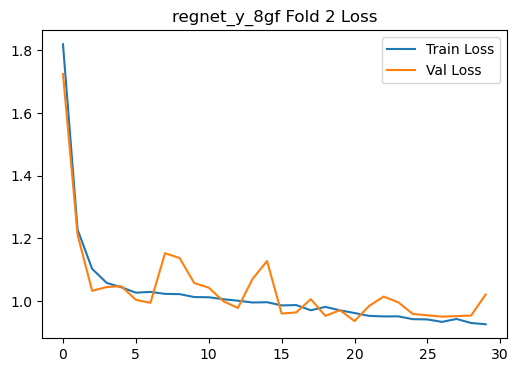


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.7351 | Val Loss 1.7772
Valid Loss (inf --> 1.777182).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2502 | Val Loss 1.3752
Valid Loss (1.777182 --> 1.375151).  Saving Model ...


Epoch 3: Train Loss 1.0957 | Val Loss 1.0642
Valid Loss (1.375151 --> 1.064243).  Saving Model ...


Epoch 4: Train Loss 1.0821 | Val Loss 1.0714
Valid Loss (1.064243 --> 1.071403).  Saving Model ...


Epoch 5: Train Loss 1.0529 | Val Loss 1.0323
Valid Loss (1.071403 --> 1.032341).  Saving Model ...


Epoch 6: Train Loss 1.0512 | Val Loss 1.3207
EarlyStopping counter: 1 out of 7


Epoch 7: Train Loss 1.0377 | Val Loss 1.0565
Valid Loss (1.032341 --> 1.056458).  Saving Model ...


Epoch 8: Train Loss 1.0481 | Val Loss 1.0471
Valid Loss (1.056458 --> 1.047095).  Saving Model ...


Epoch 9: Train Loss 1.0307 | Val Loss 1.1197
Valid Loss (1.047095 --> 1.119725).  Saving Model ...


Epoch 10: Train Loss 1.0257 | Val Loss 1.1328
EarlyStopping counter: 1 out of 7


Epoch 11: Train Loss 1.0206 | Val Loss 0.9965
Valid Loss (1.119725 --> 0.996498).  Saving Model ...


Epoch 12: Train Loss 1.0003 | Val Loss 1.0357
Valid Loss (0.996498 --> 1.035689).  Saving Model ...


Epoch 13: Train Loss 1.0037 | Val Loss 1.0374
Valid Loss (1.035689 --> 1.037419).  Saving Model ...


Epoch 14: Train Loss 0.9990 | Val Loss 1.0693
Valid Loss (1.037419 --> 1.069277).  Saving Model ...


Epoch 15: Train Loss 0.9881 | Val Loss 1.2703
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 0.9856 | Val Loss 1.0205
Valid Loss (1.069277 --> 1.020468).  Saving Model ...


Epoch 17: Train Loss 0.9835 | Val Loss 0.9746
Valid Loss (1.020468 --> 0.974587).  Saving Model ...


Epoch 18: Train Loss 0.9717 | Val Loss 1.2208
EarlyStopping counter: 1 out of 7


Epoch 19: Train Loss 0.9753 | Val Loss 0.9775
Valid Loss (0.974587 --> 0.977467).  Saving Model ...


Epoch 20: Train Loss 0.9685 | Val Loss 1.0058
Valid Loss (0.977467 --> 1.005807).  Saving Model ...


Epoch 21: Train Loss 0.9583 | Val Loss 0.9949
Valid Loss (1.005807 --> 0.994948).  Saving Model ...


Epoch 22: Train Loss 0.9645 | Val Loss 1.0429
Valid Loss (0.994948 --> 1.042917).  Saving Model ...


Epoch 23: Train Loss 0.9625 | Val Loss 0.9824
Valid Loss (1.042917 --> 0.982356).  Saving Model ...


Epoch 24: Train Loss 0.9532 | Val Loss 0.9490
Valid Loss (0.982356 --> 0.949034).  Saving Model ...


Epoch 25: Train Loss 0.9483 | Val Loss 1.0253
Valid Loss (0.949034 --> 1.025282).  Saving Model ...


Epoch 26: Train Loss 0.9492 | Val Loss 1.0327
Valid Loss (1.025282 --> 1.032693).  Saving Model ...


Epoch 27: Train Loss 0.9423 | Val Loss 1.0027
Valid Loss (1.032693 --> 1.002700).  Saving Model ...


Epoch 28: Train Loss 0.9394 | Val Loss 0.9866
Valid Loss (1.002700 --> 0.986627).  Saving Model ...


Epoch 29: Train Loss 0.9317 | Val Loss 0.9576
Valid Loss (0.986627 --> 0.957561).  Saving Model ...


Epoch 30: Train Loss 0.9272 | Val Loss 0.9394
Valid Loss (0.957561 --> 0.939441).  Saving Model ...


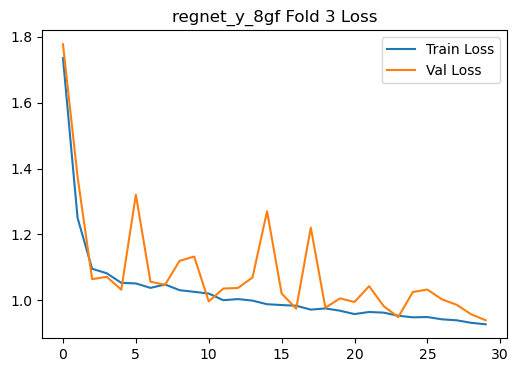


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.7957 | Val Loss 1.9064
Valid Loss (inf --> 1.906408).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2518 | Val Loss 1.2506
Valid Loss (1.906408 --> 1.250611).  Saving Model ...


Epoch 3: Train Loss 1.1042 | Val Loss 1.3141
Valid Loss (1.250611 --> 1.314095).  Saving Model ...


Epoch 4: Train Loss 1.0579 | Val Loss 1.1411
Valid Loss (1.314095 --> 1.141053).  Saving Model ...


Epoch 5: Train Loss 1.0419 | Val Loss 1.3230
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.0343 | Val Loss 1.1061
Valid Loss (1.141053 --> 1.106145).  Saving Model ...


Epoch 7: Train Loss 1.0330 | Val Loss 1.0676
Valid Loss (1.106145 --> 1.067611).  Saving Model ...


Epoch 8: Train Loss 1.0207 | Val Loss 1.1436
Valid Loss (1.067611 --> 1.143584).  Saving Model ...


Epoch 9: Train Loss 1.0174 | Val Loss 1.0436
Valid Loss (1.143584 --> 1.043613).  Saving Model ...


Epoch 10: Train Loss 1.0015 | Val Loss 1.0869
Valid Loss (1.043613 --> 1.086926).  Saving Model ...


Epoch 11: Train Loss 1.0033 | Val Loss 1.0447
Valid Loss (1.086926 --> 1.044722).  Saving Model ...


Epoch 12: Train Loss 1.0033 | Val Loss 1.0423
Valid Loss (1.044722 --> 1.042311).  Saving Model ...


Epoch 13: Train Loss 0.9994 | Val Loss 1.1423
Valid Loss (1.042311 --> 1.142279).  Saving Model ...


Epoch 14: Train Loss 0.9941 | Val Loss 1.0508
Valid Loss (1.142279 --> 1.050832).  Saving Model ...


Epoch 15: Train Loss 0.9957 | Val Loss 1.0253
Valid Loss (1.050832 --> 1.025317).  Saving Model ...


Epoch 16: Train Loss 0.9855 | Val Loss 1.0539
Valid Loss (1.025317 --> 1.053875).  Saving Model ...


Epoch 17: Train Loss 0.9795 | Val Loss 1.0302
Valid Loss (1.053875 --> 1.030162).  Saving Model ...


Epoch 18: Train Loss 0.9739 | Val Loss 0.9993
Valid Loss (1.030162 --> 0.999308).  Saving Model ...


Epoch 19: Train Loss 0.9720 | Val Loss 1.0074
Valid Loss (0.999308 --> 1.007399).  Saving Model ...


Epoch 20: Train Loss 0.9647 | Val Loss 0.9867
Valid Loss (1.007399 --> 0.986683).  Saving Model ...


Epoch 21: Train Loss 0.9487 | Val Loss 1.0715
Valid Loss (0.986683 --> 1.071533).  Saving Model ...


Epoch 22: Train Loss 0.9530 | Val Loss 0.9808
Valid Loss (1.071533 --> 0.980826).  Saving Model ...


Epoch 23: Train Loss 0.9503 | Val Loss 1.0011
Valid Loss (0.980826 --> 1.001124).  Saving Model ...


Epoch 24: Train Loss 0.9402 | Val Loss 1.0359
Valid Loss (1.001124 --> 1.035865).  Saving Model ...


Epoch 25: Train Loss 0.9419 | Val Loss 0.9865
Valid Loss (1.035865 --> 0.986508).  Saving Model ...


Epoch 26: Train Loss 0.9326 | Val Loss 0.9969
Valid Loss (0.986508 --> 0.996919).  Saving Model ...


Epoch 27: Train Loss 0.9452 | Val Loss 1.0200
Valid Loss (0.996919 --> 1.019992).  Saving Model ...


Epoch 28: Train Loss 0.9292 | Val Loss 0.9634
Valid Loss (1.019992 --> 0.963377).  Saving Model ...


Epoch 29: Train Loss 0.9233 | Val Loss 0.9745
Valid Loss (0.963377 --> 0.974499).  Saving Model ...


Epoch 30: Train Loss 0.9200 | Val Loss 1.0274
Valid Loss (0.974499 --> 1.027419).  Saving Model ...


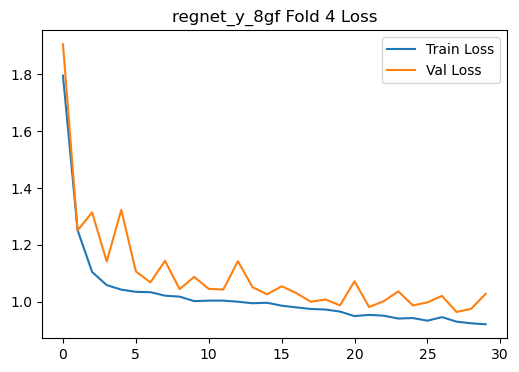


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.7887 | Val Loss 1.6527
Valid Loss (inf --> 1.652657).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2367 | Val Loss 1.3516
Valid Loss (1.652657 --> 1.351607).  Saving Model ...


Epoch 3: Train Loss 1.1144 | Val Loss 1.0872
Valid Loss (1.351607 --> 1.087169).  Saving Model ...


Epoch 4: Train Loss 1.0822 | Val Loss 1.2674
EarlyStopping counter: 1 out of 7


Epoch 5: Train Loss 1.0445 | Val Loss 1.0906
Valid Loss (1.087169 --> 1.090644).  Saving Model ...


Epoch 6: Train Loss 1.0452 | Val Loss 1.1018
Valid Loss (1.090644 --> 1.101790).  Saving Model ...


Epoch 7: Train Loss 1.0413 | Val Loss 1.3312
EarlyStopping counter: 1 out of 7


Epoch 8: Train Loss 1.0270 | Val Loss 1.1520
Valid Loss (1.101790 --> 1.152043).  Saving Model ...


Epoch 9: Train Loss 1.0237 | Val Loss 1.0594
Valid Loss (1.152043 --> 1.059397).  Saving Model ...


Epoch 10: Train Loss 1.0138 | Val Loss 1.0520
Valid Loss (1.059397 --> 1.052043).  Saving Model ...


Epoch 11: Train Loss 1.0073 | Val Loss 1.0878
Valid Loss (1.052043 --> 1.087756).  Saving Model ...


Epoch 12: Train Loss 1.0048 | Val Loss 1.0255
Valid Loss (1.087756 --> 1.025549).  Saving Model ...


Epoch 13: Train Loss 0.9960 | Val Loss 0.9876
Valid Loss (1.025549 --> 0.987591).  Saving Model ...


Epoch 14: Train Loss 0.9876 | Val Loss 1.0106
Valid Loss (0.987591 --> 1.010578).  Saving Model ...


Epoch 15: Train Loss 0.9921 | Val Loss 1.0688
Valid Loss (1.010578 --> 1.068767).  Saving Model ...


Epoch 16: Train Loss 0.9902 | Val Loss 0.9926
Valid Loss (1.068767 --> 0.992571).  Saving Model ...


Epoch 17: Train Loss 0.9850 | Val Loss 1.0306
Valid Loss (0.992571 --> 1.030646).  Saving Model ...


Epoch 18: Train Loss 0.9797 | Val Loss 1.0170
Valid Loss (1.030646 --> 1.017032).  Saving Model ...


Epoch 19: Train Loss 0.9730 | Val Loss 0.9764
Valid Loss (1.017032 --> 0.976392).  Saving Model ...


Epoch 20: Train Loss 0.9685 | Val Loss 1.0297
Valid Loss (0.976392 --> 1.029676).  Saving Model ...


Epoch 21: Train Loss 0.9613 | Val Loss 1.1918
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 0.9634 | Val Loss 1.0124
Valid Loss (1.029676 --> 1.012371).  Saving Model ...


Epoch 23: Train Loss 0.9476 | Val Loss 1.0001
Valid Loss (1.012371 --> 1.000125).  Saving Model ...


Epoch 24: Train Loss 0.9564 | Val Loss 1.0684
Valid Loss (1.000125 --> 1.068423).  Saving Model ...


Epoch 25: Train Loss 0.9441 | Val Loss 0.9688
Valid Loss (1.068423 --> 0.968757).  Saving Model ...


Epoch 26: Train Loss 0.9420 | Val Loss 0.9772
Valid Loss (0.968757 --> 0.977224).  Saving Model ...


Epoch 27: Train Loss 0.9389 | Val Loss 1.0053
Valid Loss (0.977224 --> 1.005287).  Saving Model ...


Epoch 28: Train Loss 0.9374 | Val Loss 1.1038
EarlyStopping counter: 1 out of 7


Epoch 29: Train Loss 0.9193 | Val Loss 0.9490
Valid Loss (1.005287 --> 0.949043).  Saving Model ...


Epoch 30: Train Loss 0.9192 | Val Loss 0.9983
Valid Loss (0.949043 --> 0.998268).  Saving Model ...


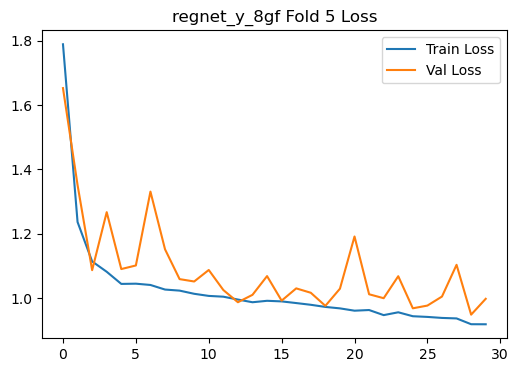


STARTING TRAINING: resnet_101 (Size: 224)

--- FOLD 1/5 ---


Epoch 1: Train Loss 1.7937 | Val Loss 1.5934
Valid Loss (inf --> 1.593427).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3253 | Val Loss 1.2995
Valid Loss (1.593427 --> 1.299537).  Saving Model ...


Epoch 3: Train Loss 1.1690 | Val Loss 1.2198
Valid Loss (1.299537 --> 1.219753).  Saving Model ...


Epoch 4: Train Loss 1.1161 | Val Loss 1.0756
Valid Loss (1.219753 --> 1.075571).  Saving Model ...


Epoch 5: Train Loss 1.1010 | Val Loss 1.0652
Valid Loss (1.075571 --> 1.065238).  Saving Model ...


Epoch 6: Train Loss 1.0777 | Val Loss 1.1319
Valid Loss (1.065238 --> 1.131929).  Saving Model ...


Epoch 7: Train Loss 1.0695 | Val Loss 1.1371
Valid Loss (1.131929 --> 1.137131).  Saving Model ...


Epoch 8: Train Loss 1.0639 | Val Loss 1.0933
Valid Loss (1.137131 --> 1.093310).  Saving Model ...


Epoch 9: Train Loss 1.0712 | Val Loss 1.4447
EarlyStopping counter: 1 out of 7


Epoch 10: Train Loss 1.0760 | Val Loss 1.1061
Valid Loss (1.093310 --> 1.106139).  Saving Model ...


Epoch 11: Train Loss 1.0665 | Val Loss 1.0697
Valid Loss (1.106139 --> 1.069682).  Saving Model ...


Epoch 12: Train Loss 1.0692 | Val Loss 1.0648
Valid Loss (1.069682 --> 1.064764).  Saving Model ...


Epoch 13: Train Loss 1.0588 | Val Loss 1.0937
Valid Loss (1.064764 --> 1.093652).  Saving Model ...


Epoch 14: Train Loss 1.0510 | Val Loss 1.1021
Valid Loss (1.093652 --> 1.102083).  Saving Model ...


Epoch 15: Train Loss 1.0435 | Val Loss 1.0597
Valid Loss (1.102083 --> 1.059749).  Saving Model ...


Epoch 16: Train Loss 1.0497 | Val Loss 1.0563
Valid Loss (1.059749 --> 1.056290).  Saving Model ...


Epoch 17: Train Loss 1.0373 | Val Loss 1.5179
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 1.0351 | Val Loss 1.1122
Valid Loss (1.056290 --> 1.112215).  Saving Model ...


Epoch 19: Train Loss 1.0352 | Val Loss 1.1229
Valid Loss (1.112215 --> 1.122941).  Saving Model ...


Epoch 20: Train Loss 1.0317 | Val Loss 1.0704
Valid Loss (1.122941 --> 1.070432).  Saving Model ...


Epoch 21: Train Loss 1.0233 | Val Loss 1.1121
Valid Loss (1.070432 --> 1.112105).  Saving Model ...


Epoch 22: Train Loss 1.0154 | Val Loss 1.0469
Valid Loss (1.112105 --> 1.046922).  Saving Model ...


Epoch 23: Train Loss 1.0281 | Val Loss 1.1477
EarlyStopping counter: 1 out of 7


Epoch 24: Train Loss 1.0191 | Val Loss 1.0743
Valid Loss (1.046922 --> 1.074306).  Saving Model ...


Epoch 25: Train Loss 0.9986 | Val Loss 0.9769
Valid Loss (1.074306 --> 0.976850).  Saving Model ...


Epoch 26: Train Loss 1.0099 | Val Loss 1.0340
Valid Loss (0.976850 --> 1.033992).  Saving Model ...


Epoch 27: Train Loss 1.0076 | Val Loss 1.0250
Valid Loss (1.033992 --> 1.025008).  Saving Model ...


Epoch 28: Train Loss 1.0131 | Val Loss 1.0737
Valid Loss (1.025008 --> 1.073653).  Saving Model ...


Epoch 29: Train Loss 0.9937 | Val Loss 1.0162
Valid Loss (1.073653 --> 1.016227).  Saving Model ...


Epoch 30: Train Loss 0.9851 | Val Loss 1.5079
EarlyStopping counter: 1 out of 7


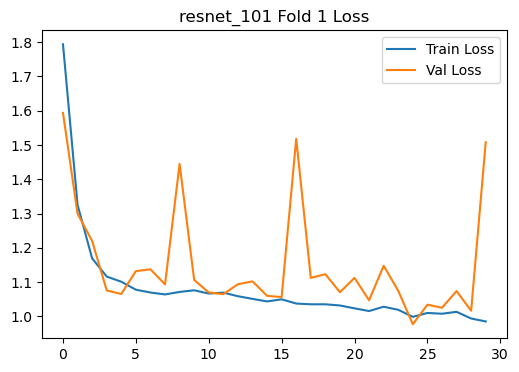


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.7322 | Val Loss 1.6251
Valid Loss (inf --> 1.625070).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3249 | Val Loss 1.1724
Valid Loss (1.625070 --> 1.172366).  Saving Model ...


Epoch 3: Train Loss 1.1652 | Val Loss 1.1533
Valid Loss (1.172366 --> 1.153282).  Saving Model ...


Epoch 4: Train Loss 1.1033 | Val Loss 1.2125
Valid Loss (1.153282 --> 1.212476).  Saving Model ...


Epoch 5: Train Loss 1.0982 | Val Loss 1.0570
Valid Loss (1.212476 --> 1.057046).  Saving Model ...


Epoch 6: Train Loss 1.0866 | Val Loss 1.2111
EarlyStopping counter: 1 out of 7


Epoch 7: Train Loss 1.0746 | Val Loss 1.0356
Valid Loss (1.057046 --> 1.035572).  Saving Model ...


Epoch 8: Train Loss 1.0584 | Val Loss 1.0920
Valid Loss (1.035572 --> 1.091985).  Saving Model ...


Epoch 9: Train Loss 1.0658 | Val Loss 1.0808
Valid Loss (1.091985 --> 1.080835).  Saving Model ...


Epoch 10: Train Loss 1.0599 | Val Loss 1.0563
Valid Loss (1.080835 --> 1.056273).  Saving Model ...


Epoch 11: Train Loss 1.0589 | Val Loss 1.1599
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.0459 | Val Loss 1.1240
Valid Loss (1.056273 --> 1.124033).  Saving Model ...


Epoch 13: Train Loss 1.0489 | Val Loss 1.0378
Valid Loss (1.124033 --> 1.037766).  Saving Model ...


Epoch 14: Train Loss 1.0374 | Val Loss 1.1484
EarlyStopping counter: 1 out of 7


Epoch 15: Train Loss 1.0358 | Val Loss 1.0165
Valid Loss (1.037766 --> 1.016496).  Saving Model ...


Epoch 16: Train Loss 1.0321 | Val Loss 1.0503
Valid Loss (1.016496 --> 1.050258).  Saving Model ...


Epoch 17: Train Loss 1.0260 | Val Loss 1.0255
Valid Loss (1.050258 --> 1.025511).  Saving Model ...


Epoch 18: Train Loss 1.0279 | Val Loss 1.0794
Valid Loss (1.025511 --> 1.079379).  Saving Model ...


Epoch 19: Train Loss 1.0297 | Val Loss 1.2285
EarlyStopping counter: 1 out of 7


Epoch 20: Train Loss 1.0168 | Val Loss 1.0557
Valid Loss (1.079379 --> 1.055740).  Saving Model ...


Epoch 21: Train Loss 1.0253 | Val Loss 1.0307
Valid Loss (1.055740 --> 1.030742).  Saving Model ...


Epoch 22: Train Loss 1.0213 | Val Loss 1.0023
Valid Loss (1.030742 --> 1.002256).  Saving Model ...


Epoch 23: Train Loss 0.9991 | Val Loss 1.0079
Valid Loss (1.002256 --> 1.007934).  Saving Model ...


Epoch 24: Train Loss 0.9993 | Val Loss 1.0489
Valid Loss (1.007934 --> 1.048917).  Saving Model ...


Epoch 25: Train Loss 1.0033 | Val Loss 0.9920
Valid Loss (1.048917 --> 0.992037).  Saving Model ...


Epoch 26: Train Loss 1.0044 | Val Loss 1.0570
Valid Loss (0.992037 --> 1.057027).  Saving Model ...


Epoch 27: Train Loss 0.9908 | Val Loss 0.9743
Valid Loss (1.057027 --> 0.974327).  Saving Model ...


Epoch 28: Train Loss 0.9943 | Val Loss 0.9920
Valid Loss (0.974327 --> 0.992003).  Saving Model ...


Epoch 29: Train Loss 0.9775 | Val Loss 1.0531
Valid Loss (0.992003 --> 1.053145).  Saving Model ...


Epoch 30: Train Loss 0.9803 | Val Loss 0.9680
Valid Loss (1.053145 --> 0.968046).  Saving Model ...


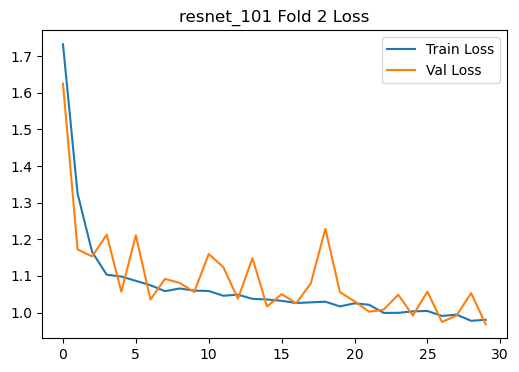


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.7424 | Val Loss 1.7468
Valid Loss (inf --> 1.746780).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3257 | Val Loss 1.2044
Valid Loss (1.746780 --> 1.204407).  Saving Model ...


Epoch 3: Train Loss 1.1696 | Val Loss 1.3306
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.1644 | Val Loss 2.2108
EarlyStopping counter: 2 out of 7


Epoch 5: Train Loss 1.1517 | Val Loss 1.2030
Valid Loss (1.204407 --> 1.202998).  Saving Model ...


Epoch 6: Train Loss 1.1281 | Val Loss 1.1433
Valid Loss (1.202998 --> 1.143348).  Saving Model ...


Epoch 7: Train Loss 1.1131 | Val Loss 1.0621
Valid Loss (1.143348 --> 1.062101).  Saving Model ...


Epoch 8: Train Loss 1.0885 | Val Loss 1.0314
Valid Loss (1.062101 --> 1.031380).  Saving Model ...


Epoch 9: Train Loss 1.0784 | Val Loss 1.3829
EarlyStopping counter: 1 out of 7


Epoch 10: Train Loss 1.0518 | Val Loss 1.0330
Valid Loss (1.031380 --> 1.033017).  Saving Model ...


Epoch 11: Train Loss 1.0477 | Val Loss 1.0953
Valid Loss (1.033017 --> 1.095297).  Saving Model ...


Epoch 12: Train Loss 1.0552 | Val Loss 1.1003
Valid Loss (1.095297 --> 1.100297).  Saving Model ...


Epoch 13: Train Loss 1.0731 | Val Loss 1.0893
Valid Loss (1.100297 --> 1.089286).  Saving Model ...


Epoch 14: Train Loss 1.0663 | Val Loss 1.0847
Valid Loss (1.089286 --> 1.084750).  Saving Model ...


Epoch 15: Train Loss 1.0650 | Val Loss 1.1459
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 1.0572 | Val Loss 1.0661
Valid Loss (1.084750 --> 1.066095).  Saving Model ...


Epoch 17: Train Loss 1.0489 | Val Loss 1.0420
Valid Loss (1.066095 --> 1.041984).  Saving Model ...


Epoch 18: Train Loss 1.0535 | Val Loss 1.0897
Valid Loss (1.041984 --> 1.089742).  Saving Model ...


Epoch 19: Train Loss 1.0397 | Val Loss 1.0880
Valid Loss (1.089742 --> 1.088014).  Saving Model ...


Epoch 20: Train Loss 1.0336 | Val Loss 1.2029
EarlyStopping counter: 1 out of 7


Epoch 21: Train Loss 1.0163 | Val Loss 1.1230
Valid Loss (1.088014 --> 1.122959).  Saving Model ...


Epoch 22: Train Loss 1.0183 | Val Loss 1.0785
Valid Loss (1.122959 --> 1.078502).  Saving Model ...


Epoch 23: Train Loss 1.0061 | Val Loss 1.0242
Valid Loss (1.078502 --> 1.024151).  Saving Model ...


Epoch 24: Train Loss 1.0043 | Val Loss 1.0899
Valid Loss (1.024151 --> 1.089902).  Saving Model ...


Epoch 25: Train Loss 0.9942 | Val Loss 1.0371
Valid Loss (1.089902 --> 1.037119).  Saving Model ...


Epoch 26: Train Loss 1.0033 | Val Loss 1.0448
Valid Loss (1.037119 --> 1.044780).  Saving Model ...


Epoch 27: Train Loss 1.0004 | Val Loss 1.1344
EarlyStopping counter: 1 out of 7


Epoch 28: Train Loss 0.9905 | Val Loss 1.0740
Valid Loss (1.044780 --> 1.073960).  Saving Model ...


Epoch 29: Train Loss 0.9850 | Val Loss 1.0184
Valid Loss (1.073960 --> 1.018445).  Saving Model ...


Epoch 30: Train Loss 0.9817 | Val Loss 1.0027
Valid Loss (1.018445 --> 1.002675).  Saving Model ...


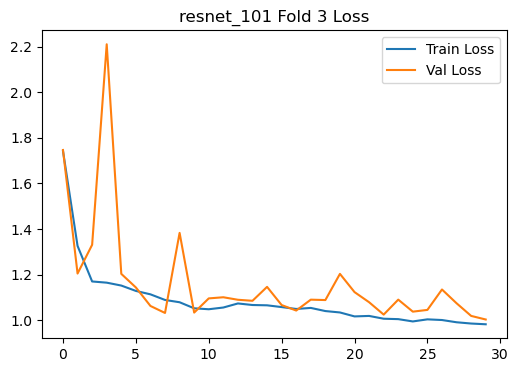


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.7535 | Val Loss 1.5867
Valid Loss (inf --> 1.586742).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3050 | Val Loss 1.2275
Valid Loss (1.586742 --> 1.227499).  Saving Model ...


Epoch 3: Train Loss 1.1343 | Val Loss 1.1041
Valid Loss (1.227499 --> 1.104072).  Saving Model ...


Epoch 4: Train Loss 1.0932 | Val Loss 1.1739
Valid Loss (1.104072 --> 1.173893).  Saving Model ...


Epoch 5: Train Loss 1.0735 | Val Loss 1.1724
Valid Loss (1.173893 --> 1.172422).  Saving Model ...


Epoch 6: Train Loss 1.0624 | Val Loss 1.0903
Valid Loss (1.172422 --> 1.090328).  Saving Model ...


Epoch 7: Train Loss 1.0579 | Val Loss 1.0918
Valid Loss (1.090328 --> 1.091794).  Saving Model ...


Epoch 8: Train Loss 1.0506 | Val Loss 1.0904
Valid Loss (1.091794 --> 1.090406).  Saving Model ...


Epoch 9: Train Loss 1.0491 | Val Loss 1.1637
Valid Loss (1.090406 --> 1.163738).  Saving Model ...


Epoch 10: Train Loss 1.0423 | Val Loss 1.2063
EarlyStopping counter: 1 out of 7


Epoch 11: Train Loss 1.0335 | Val Loss 1.0747
Valid Loss (1.163738 --> 1.074705).  Saving Model ...


Epoch 12: Train Loss 1.0434 | Val Loss 1.0827
Valid Loss (1.074705 --> 1.082671).  Saving Model ...


Epoch 13: Train Loss 1.0366 | Val Loss 1.0590
Valid Loss (1.082671 --> 1.058994).  Saving Model ...


Epoch 14: Train Loss 1.0244 | Val Loss 1.0446
Valid Loss (1.058994 --> 1.044575).  Saving Model ...


Epoch 15: Train Loss 1.0268 | Val Loss 1.1560
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 1.0274 | Val Loss 1.0849
Valid Loss (1.044575 --> 1.084945).  Saving Model ...


Epoch 17: Train Loss 1.0132 | Val Loss 1.3091
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 1.0286 | Val Loss 1.0747
Valid Loss (1.084945 --> 1.074681).  Saving Model ...


Epoch 19: Train Loss 1.0160 | Val Loss 1.0507
Valid Loss (1.074681 --> 1.050685).  Saving Model ...


Epoch 20: Train Loss 1.0067 | Val Loss 1.2274
EarlyStopping counter: 1 out of 7


Epoch 21: Train Loss 1.0086 | Val Loss 1.0932
Valid Loss (1.050685 --> 1.093184).  Saving Model ...


Epoch 22: Train Loss 0.9950 | Val Loss 1.0130
Valid Loss (1.093184 --> 1.013018).  Saving Model ...


Epoch 23: Train Loss 1.0016 | Val Loss 1.0898
Valid Loss (1.013018 --> 1.089837).  Saving Model ...


Epoch 24: Train Loss 1.0024 | Val Loss 1.0551
Valid Loss (1.089837 --> 1.055084).  Saving Model ...


Epoch 25: Train Loss 0.9958 | Val Loss 1.0431
Valid Loss (1.055084 --> 1.043137).  Saving Model ...


Epoch 26: Train Loss 0.9885 | Val Loss 1.0130
Valid Loss (1.043137 --> 1.012961).  Saving Model ...


Epoch 27: Train Loss 0.9946 | Val Loss 1.0195
Valid Loss (1.012961 --> 1.019494).  Saving Model ...


Epoch 28: Train Loss 0.9779 | Val Loss 1.0407
Valid Loss (1.019494 --> 1.040743).  Saving Model ...


Epoch 29: Train Loss 0.9727 | Val Loss 1.0110
Valid Loss (1.040743 --> 1.010966).  Saving Model ...


Epoch 30: Train Loss 0.9699 | Val Loss 1.1443
EarlyStopping counter: 1 out of 7


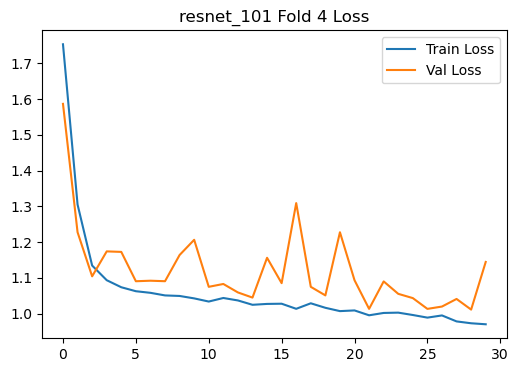


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.7700 | Val Loss 1.9792
Valid Loss (inf --> 1.979189).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3381 | Val Loss 93.6106
EarlyStopping counter: 1 out of 7


Epoch 3: Train Loss 1.2264 | Val Loss 1.1569
Valid Loss (1.979189 --> 1.156924).  Saving Model ...


Epoch 4: Train Loss 1.1349 | Val Loss 1.2160
Valid Loss (1.156924 --> 1.216016).  Saving Model ...


Epoch 5: Train Loss 1.1048 | Val Loss 1.1582
Valid Loss (1.216016 --> 1.158210).  Saving Model ...


Epoch 6: Train Loss 1.0894 | Val Loss 1.0557
Valid Loss (1.158210 --> 1.055710).  Saving Model ...


Epoch 7: Train Loss 1.0714 | Val Loss 1.0848
Valid Loss (1.055710 --> 1.084796).  Saving Model ...


Epoch 8: Train Loss 1.0686 | Val Loss 1.0889
Valid Loss (1.084796 --> 1.088856).  Saving Model ...


Epoch 9: Train Loss 1.0474 | Val Loss 1.1301
Valid Loss (1.088856 --> 1.130114).  Saving Model ...


Epoch 10: Train Loss 1.0466 | Val Loss 1.1088
Valid Loss (1.130114 --> 1.108770).  Saving Model ...


Epoch 11: Train Loss 1.0572 | Val Loss 1.1042
Valid Loss (1.108770 --> 1.104214).  Saving Model ...


Epoch 12: Train Loss 1.0396 | Val Loss 1.0619
Valid Loss (1.104214 --> 1.061882).  Saving Model ...


Epoch 13: Train Loss 1.0407 | Val Loss 1.0782
Valid Loss (1.061882 --> 1.078165).  Saving Model ...


Epoch 14: Train Loss 1.0363 | Val Loss 1.1394
Valid Loss (1.078165 --> 1.139420).  Saving Model ...


Epoch 15: Train Loss 1.0551 | Val Loss 1.0482
Valid Loss (1.139420 --> 1.048203).  Saving Model ...


Epoch 16: Train Loss 1.0357 | Val Loss 1.0614
Valid Loss (1.048203 --> 1.061402).  Saving Model ...


Epoch 17: Train Loss 1.0314 | Val Loss 1.0471
Valid Loss (1.061402 --> 1.047103).  Saving Model ...


Epoch 18: Train Loss 1.0225 | Val Loss 1.0752
Valid Loss (1.047103 --> 1.075196).  Saving Model ...


Epoch 19: Train Loss 1.0165 | Val Loss 1.0514
Valid Loss (1.075196 --> 1.051443).  Saving Model ...


Epoch 20: Train Loss 1.0139 | Val Loss 1.0731
Valid Loss (1.051443 --> 1.073120).  Saving Model ...


Epoch 21: Train Loss 1.0193 | Val Loss 1.1427
Valid Loss (1.073120 --> 1.142651).  Saving Model ...


Epoch 22: Train Loss 1.0056 | Val Loss 1.0943
Valid Loss (1.142651 --> 1.094264).  Saving Model ...


Epoch 23: Train Loss 1.0008 | Val Loss 1.0761
Valid Loss (1.094264 --> 1.076119).  Saving Model ...


Epoch 24: Train Loss 0.9987 | Val Loss 1.0590
Valid Loss (1.076119 --> 1.058977).  Saving Model ...


Epoch 25: Train Loss 1.0086 | Val Loss 1.0365
Valid Loss (1.058977 --> 1.036542).  Saving Model ...


Epoch 26: Train Loss 0.9876 | Val Loss 1.1275
Valid Loss (1.036542 --> 1.127527).  Saving Model ...


Epoch 27: Train Loss 0.9902 | Val Loss 1.2404
EarlyStopping counter: 1 out of 7


Epoch 28: Train Loss 0.9842 | Val Loss 1.0541
Valid Loss (1.127527 --> 1.054087).  Saving Model ...


Epoch 29: Train Loss 0.9768 | Val Loss 1.0573
Valid Loss (1.054087 --> 1.057276).  Saving Model ...


Epoch 30: Train Loss 0.9811 | Val Loss 1.0045
Valid Loss (1.057276 --> 1.004455).  Saving Model ...


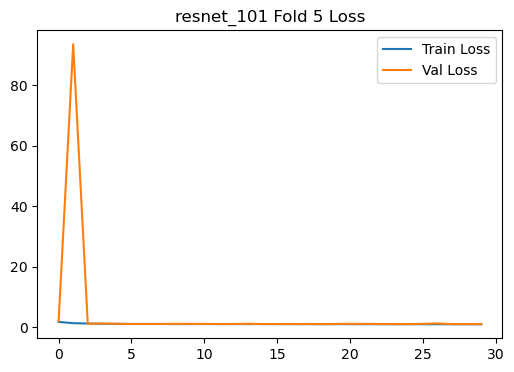


STARTING TRAINING: resnext_50_32x4d (Size: 224)

--- FOLD 1/5 ---


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /home/usama/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 47.2MB/s]


Epoch 1: Train Loss 1.7341 | Val Loss 1.5651
Valid Loss (inf --> 1.565078).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2225 | Val Loss 1.0369
Valid Loss (1.565078 --> 1.036904).  Saving Model ...


Epoch 3: Train Loss 1.0680 | Val Loss 1.0088
Valid Loss (1.036904 --> 1.008843).  Saving Model ...


Epoch 4: Train Loss 1.0267 | Val Loss 1.1313
EarlyStopping counter: 1 out of 7


Epoch 5: Train Loss 1.0202 | Val Loss 1.0074
Valid Loss (1.008843 --> 1.007388).  Saving Model ...


Epoch 6: Train Loss 1.0073 | Val Loss 1.0774
Valid Loss (1.007388 --> 1.077391).  Saving Model ...


Epoch 7: Train Loss 1.0027 | Val Loss 0.9977
Valid Loss (1.077391 --> 0.997674).  Saving Model ...


Epoch 8: Train Loss 1.0088 | Val Loss 1.0732
Valid Loss (0.997674 --> 1.073223).  Saving Model ...


Epoch 9: Train Loss 1.0002 | Val Loss 0.9938
Valid Loss (1.073223 --> 0.993808).  Saving Model ...


Epoch 10: Train Loss 0.9940 | Val Loss 1.0547
Valid Loss (0.993808 --> 1.054684).  Saving Model ...


Epoch 11: Train Loss 0.9947 | Val Loss 0.9798
Valid Loss (1.054684 --> 0.979797).  Saving Model ...


Epoch 12: Train Loss 1.0022 | Val Loss 0.9906
Valid Loss (0.979797 --> 0.990553).  Saving Model ...


Epoch 13: Train Loss 0.9988 | Val Loss 1.0812
EarlyStopping counter: 1 out of 7


Epoch 14: Train Loss 0.9880 | Val Loss 1.0095
Valid Loss (0.990553 --> 1.009503).  Saving Model ...


Epoch 15: Train Loss 0.9882 | Val Loss 1.0945
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 0.9898 | Val Loss 1.0545
Valid Loss (1.009503 --> 1.054468).  Saving Model ...


Epoch 17: Train Loss 0.9753 | Val Loss 1.1511
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 0.9749 | Val Loss 1.0472
Valid Loss (1.054468 --> 1.047225).  Saving Model ...


Epoch 19: Train Loss 0.9710 | Val Loss 1.0224
Valid Loss (1.047225 --> 1.022441).  Saving Model ...


Epoch 20: Train Loss 0.9663 | Val Loss 0.9765
Valid Loss (1.022441 --> 0.976509).  Saving Model ...


Epoch 21: Train Loss 0.9708 | Val Loss 1.1012
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 0.9707 | Val Loss 0.9775
Valid Loss (0.976509 --> 0.977483).  Saving Model ...


Epoch 23: Train Loss 0.9527 | Val Loss 1.0116
Valid Loss (0.977483 --> 1.011573).  Saving Model ...


Epoch 24: Train Loss 0.9581 | Val Loss 1.0701
Valid Loss (1.011573 --> 1.070124).  Saving Model ...


Epoch 25: Train Loss 0.9483 | Val Loss 0.9662
Valid Loss (1.070124 --> 0.966247).  Saving Model ...


Epoch 26: Train Loss 0.9328 | Val Loss 0.9907
Valid Loss (0.966247 --> 0.990681).  Saving Model ...


Epoch 27: Train Loss 0.9351 | Val Loss 1.0189
Valid Loss (0.990681 --> 1.018933).  Saving Model ...


Epoch 28: Train Loss 0.9327 | Val Loss 1.0151
Valid Loss (1.018933 --> 1.015110).  Saving Model ...


Epoch 29: Train Loss 0.9268 | Val Loss 1.0048
Valid Loss (1.015110 --> 1.004759).  Saving Model ...


Epoch 30: Train Loss 0.9281 | Val Loss 0.9478
Valid Loss (1.004759 --> 0.947771).  Saving Model ...


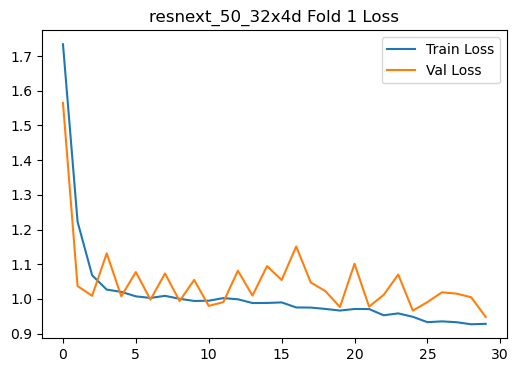


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.7104 | Val Loss 1.5826
Valid Loss (inf --> 1.582639).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2205 | Val Loss 1.1039
Valid Loss (1.582639 --> 1.103925).  Saving Model ...


Epoch 3: Train Loss 1.0827 | Val Loss 1.0713
Valid Loss (1.103925 --> 1.071281).  Saving Model ...


Epoch 4: Train Loss 1.0562 | Val Loss 1.0441
Valid Loss (1.071281 --> 1.044051).  Saving Model ...


Epoch 5: Train Loss 1.0204 | Val Loss 1.0835
Valid Loss (1.044051 --> 1.083465).  Saving Model ...


Epoch 6: Train Loss 1.0220 | Val Loss 0.9915
Valid Loss (1.083465 --> 0.991507).  Saving Model ...


Epoch 7: Train Loss 1.0123 | Val Loss 1.0052
Valid Loss (0.991507 --> 1.005222).  Saving Model ...


Epoch 8: Train Loss 1.0082 | Val Loss 1.0184
Valid Loss (1.005222 --> 1.018418).  Saving Model ...


Epoch 9: Train Loss 1.0093 | Val Loss 0.9936
Valid Loss (1.018418 --> 0.993576).  Saving Model ...


Epoch 10: Train Loss 1.0098 | Val Loss 1.0550
Valid Loss (0.993576 --> 1.054962).  Saving Model ...


Epoch 11: Train Loss 1.0024 | Val Loss 1.0090
Valid Loss (1.054962 --> 1.009000).  Saving Model ...


Epoch 12: Train Loss 1.0116 | Val Loss 0.9905
Valid Loss (1.009000 --> 0.990537).  Saving Model ...


Epoch 13: Train Loss 0.9964 | Val Loss 1.0268
Valid Loss (0.990537 --> 1.026807).  Saving Model ...


Epoch 14: Train Loss 0.9847 | Val Loss 0.9862
Valid Loss (1.026807 --> 0.986245).  Saving Model ...


Epoch 15: Train Loss 0.9994 | Val Loss 1.2169
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 1.0064 | Val Loss 0.9940
Valid Loss (0.986245 --> 0.993978).  Saving Model ...


Epoch 17: Train Loss 0.9913 | Val Loss 1.0536
Valid Loss (0.993978 --> 1.053567).  Saving Model ...


Epoch 18: Train Loss 0.9802 | Val Loss 0.9650
Valid Loss (1.053567 --> 0.965023).  Saving Model ...


Epoch 19: Train Loss 0.9773 | Val Loss 1.1636
EarlyStopping counter: 1 out of 7


Epoch 20: Train Loss 0.9720 | Val Loss 0.9430
Valid Loss (0.965023 --> 0.943019).  Saving Model ...


Epoch 21: Train Loss 0.9671 | Val Loss 1.0244
Valid Loss (0.943019 --> 1.024365).  Saving Model ...


Epoch 22: Train Loss 0.9666 | Val Loss 0.9711
Valid Loss (1.024365 --> 0.971068).  Saving Model ...


Epoch 23: Train Loss 0.9601 | Val Loss 1.0022
Valid Loss (0.971068 --> 1.002228).  Saving Model ...


Epoch 24: Train Loss 0.9492 | Val Loss 0.9950
Valid Loss (1.002228 --> 0.995022).  Saving Model ...


Epoch 25: Train Loss 0.9423 | Val Loss 0.9623
Valid Loss (0.995022 --> 0.962269).  Saving Model ...


Epoch 26: Train Loss 0.9459 | Val Loss 0.9875
Valid Loss (0.962269 --> 0.987529).  Saving Model ...


Epoch 27: Train Loss 0.9451 | Val Loss 0.9982
Valid Loss (0.987529 --> 0.998244).  Saving Model ...


Epoch 28: Train Loss 0.9341 | Val Loss 0.9418
Valid Loss (0.998244 --> 0.941789).  Saving Model ...


Epoch 29: Train Loss 0.9235 | Val Loss 1.0415
Valid Loss (0.941789 --> 1.041520).  Saving Model ...


Epoch 30: Train Loss 0.9245 | Val Loss 0.9389
Valid Loss (1.041520 --> 0.938862).  Saving Model ...


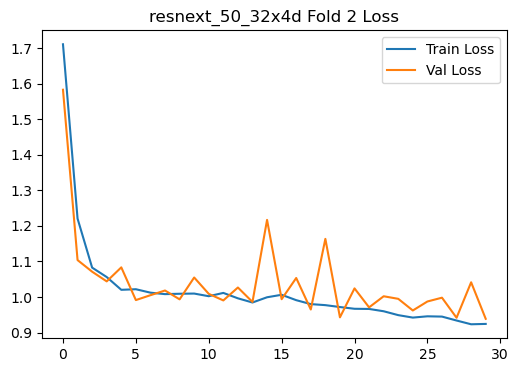


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.7359 | Val Loss 1.6600
Valid Loss (inf --> 1.660027).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2439 | Val Loss 1.1337
Valid Loss (1.660027 --> 1.133656).  Saving Model ...


Epoch 3: Train Loss 1.0813 | Val Loss 1.0551
Valid Loss (1.133656 --> 1.055143).  Saving Model ...


Epoch 4: Train Loss 1.0348 | Val Loss 1.0931
Valid Loss (1.055143 --> 1.093086).  Saving Model ...


Epoch 5: Train Loss 1.0196 | Val Loss 1.0269
Valid Loss (1.093086 --> 1.026949).  Saving Model ...


Epoch 6: Train Loss 1.0118 | Val Loss 0.9784
Valid Loss (1.026949 --> 0.978439).  Saving Model ...


Epoch 7: Train Loss 1.0041 | Val Loss 1.0568
Valid Loss (0.978439 --> 1.056777).  Saving Model ...


Epoch 8: Train Loss 1.0064 | Val Loss 0.9958
Valid Loss (1.056777 --> 0.995809).  Saving Model ...


Epoch 9: Train Loss 0.9929 | Val Loss 1.2518
EarlyStopping counter: 1 out of 7


Epoch 10: Train Loss 0.9956 | Val Loss 1.0654
Valid Loss (0.995809 --> 1.065418).  Saving Model ...


Epoch 11: Train Loss 0.9956 | Val Loss 0.9899
Valid Loss (1.065418 --> 0.989904).  Saving Model ...


Epoch 12: Train Loss 0.9934 | Val Loss 1.0761
Valid Loss (0.989904 --> 1.076093).  Saving Model ...


Epoch 13: Train Loss 0.9956 | Val Loss 1.1102
EarlyStopping counter: 1 out of 7


Epoch 14: Train Loss 0.9999 | Val Loss 1.0935
EarlyStopping counter: 2 out of 7


Epoch 15: Train Loss 1.0087 | Val Loss 1.1035
EarlyStopping counter: 3 out of 7


Epoch 16: Train Loss 0.9872 | Val Loss 1.0646
Valid Loss (1.076093 --> 1.064640).  Saving Model ...


Epoch 17: Train Loss 0.9778 | Val Loss 1.0258
Valid Loss (1.064640 --> 1.025793).  Saving Model ...


Epoch 18: Train Loss 0.9775 | Val Loss 1.0745
Valid Loss (1.025793 --> 1.074469).  Saving Model ...


Epoch 19: Train Loss 0.9762 | Val Loss 1.0128
Valid Loss (1.074469 --> 1.012762).  Saving Model ...


Epoch 20: Train Loss 0.9787 | Val Loss 1.0357
Valid Loss (1.012762 --> 1.035748).  Saving Model ...


Epoch 21: Train Loss 0.9645 | Val Loss 1.0512
Valid Loss (1.035748 --> 1.051213).  Saving Model ...


Epoch 22: Train Loss 0.9578 | Val Loss 0.9998
Valid Loss (1.051213 --> 0.999751).  Saving Model ...


Epoch 23: Train Loss 0.9488 | Val Loss 1.0162
Valid Loss (0.999751 --> 1.016236).  Saving Model ...


Epoch 24: Train Loss 0.9437 | Val Loss 0.9744
Valid Loss (1.016236 --> 0.974397).  Saving Model ...


Epoch 25: Train Loss 0.9540 | Val Loss 1.0161
Valid Loss (0.974397 --> 1.016126).  Saving Model ...


Epoch 26: Train Loss 0.9376 | Val Loss 0.9796
Valid Loss (1.016126 --> 0.979639).  Saving Model ...


Epoch 27: Train Loss 0.9381 | Val Loss 0.9943
Valid Loss (0.979639 --> 0.994331).  Saving Model ...


Epoch 28: Train Loss 0.9299 | Val Loss 1.0036
Valid Loss (0.994331 --> 1.003630).  Saving Model ...


Epoch 29: Train Loss 0.9320 | Val Loss 1.1774
EarlyStopping counter: 1 out of 7


Epoch 30: Train Loss 0.9245 | Val Loss 0.9864
Valid Loss (1.003630 --> 0.986366).  Saving Model ...


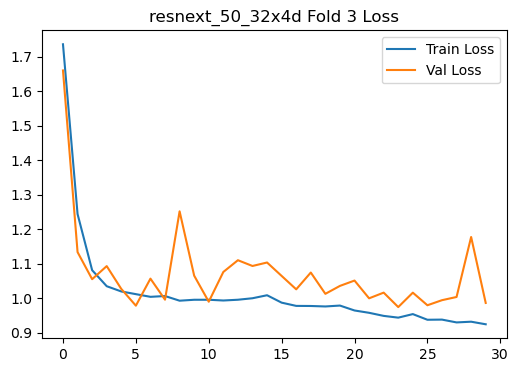


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.7286 | Val Loss 1.6248
Valid Loss (inf --> 1.624812).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.1998 | Val Loss 1.1576
Valid Loss (1.624812 --> 1.157584).  Saving Model ...


Epoch 3: Train Loss 1.0723 | Val Loss 1.7199
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.0408 | Val Loss 1.2873
EarlyStopping counter: 2 out of 7


Epoch 5: Train Loss 1.0312 | Val Loss 1.0605
Valid Loss (1.157584 --> 1.060506).  Saving Model ...


Epoch 6: Train Loss 1.0192 | Val Loss 1.1423
Valid Loss (1.060506 --> 1.142274).  Saving Model ...


Epoch 7: Train Loss 1.0197 | Val Loss 0.9903
Valid Loss (1.142274 --> 0.990264).  Saving Model ...


Epoch 8: Train Loss 1.0150 | Val Loss 1.1166
EarlyStopping counter: 1 out of 7


Epoch 9: Train Loss 1.0100 | Val Loss 1.0476
Valid Loss (0.990264 --> 1.047557).  Saving Model ...


Epoch 10: Train Loss 1.0052 | Val Loss 1.0037
Valid Loss (1.047557 --> 1.003666).  Saving Model ...


Epoch 11: Train Loss 0.9989 | Val Loss 1.1002
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.0015 | Val Loss 1.1672
EarlyStopping counter: 2 out of 7


Epoch 13: Train Loss 0.9925 | Val Loss 1.0774
Valid Loss (1.003666 --> 1.077412).  Saving Model ...


Epoch 14: Train Loss 1.0001 | Val Loss 1.0375
Valid Loss (1.077412 --> 1.037479).  Saving Model ...


Epoch 15: Train Loss 0.9953 | Val Loss 1.1514
EarlyStopping counter: 1 out of 7


Epoch 16: Train Loss 0.9875 | Val Loss 1.0672
Valid Loss (1.037479 --> 1.067209).  Saving Model ...


Epoch 17: Train Loss 0.9850 | Val Loss 1.0929
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 0.9827 | Val Loss 1.0791
Valid Loss (1.067209 --> 1.079092).  Saving Model ...


Epoch 19: Train Loss 0.9800 | Val Loss 1.0688
Valid Loss (1.079092 --> 1.068754).  Saving Model ...


Epoch 20: Train Loss 0.9744 | Val Loss 1.1629
EarlyStopping counter: 1 out of 7


Epoch 21: Train Loss 0.9817 | Val Loss 1.0045
Valid Loss (1.068754 --> 1.004483).  Saving Model ...


Epoch 22: Train Loss 0.9492 | Val Loss 1.0234
Valid Loss (1.004483 --> 1.023424).  Saving Model ...


Epoch 23: Train Loss 0.9600 | Val Loss 1.0076
Valid Loss (1.023424 --> 1.007646).  Saving Model ...


Epoch 24: Train Loss 0.9574 | Val Loss 1.0184
Valid Loss (1.007646 --> 1.018389).  Saving Model ...


Epoch 25: Train Loss 0.9342 | Val Loss 0.9941
Valid Loss (1.018389 --> 0.994147).  Saving Model ...


Epoch 26: Train Loss 0.9444 | Val Loss 1.0060
Valid Loss (0.994147 --> 1.005952).  Saving Model ...


Epoch 27: Train Loss 0.9513 | Val Loss 1.0581
Valid Loss (1.005952 --> 1.058096).  Saving Model ...


Epoch 28: Train Loss 0.9327 | Val Loss 1.0361
Valid Loss (1.058096 --> 1.036054).  Saving Model ...


Epoch 29: Train Loss 0.9266 | Val Loss 1.0409
Valid Loss (1.036054 --> 1.040875).  Saving Model ...


Epoch 30: Train Loss 0.9354 | Val Loss 1.0226
Valid Loss (1.040875 --> 1.022614).  Saving Model ...


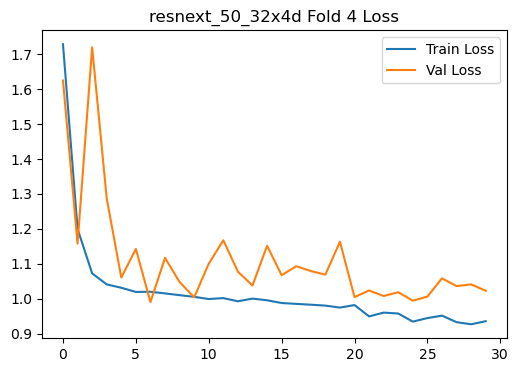


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.7293 | Val Loss 1.6693
Valid Loss (inf --> 1.669326).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2246 | Val Loss 1.1995
Valid Loss (1.669326 --> 1.199484).  Saving Model ...


Epoch 3: Train Loss 1.0817 | Val Loss 1.1808
Valid Loss (1.199484 --> 1.180839).  Saving Model ...


Epoch 4: Train Loss 1.0507 | Val Loss 1.1333
Valid Loss (1.180839 --> 1.133298).  Saving Model ...


Epoch 5: Train Loss 1.0298 | Val Loss 1.1865
Valid Loss (1.133298 --> 1.186485).  Saving Model ...


Epoch 6: Train Loss 1.0148 | Val Loss 1.0508
Valid Loss (1.186485 --> 1.050824).  Saving Model ...


Epoch 7: Train Loss 1.0110 | Val Loss 1.1094
Valid Loss (1.050824 --> 1.109357).  Saving Model ...


Epoch 8: Train Loss 1.0109 | Val Loss 1.1079
Valid Loss (1.109357 --> 1.107893).  Saving Model ...


Epoch 9: Train Loss 0.9988 | Val Loss 1.0694
Valid Loss (1.107893 --> 1.069438).  Saving Model ...


Epoch 10: Train Loss 1.0229 | Val Loss 1.1002
Valid Loss (1.069438 --> 1.100156).  Saving Model ...


Epoch 11: Train Loss 1.0151 | Val Loss 1.0559
Valid Loss (1.100156 --> 1.055900).  Saving Model ...


Epoch 12: Train Loss 1.0171 | Val Loss 1.0531
Valid Loss (1.055900 --> 1.053076).  Saving Model ...


Epoch 13: Train Loss 1.0084 | Val Loss 1.0492
Valid Loss (1.053076 --> 1.049163).  Saving Model ...


Epoch 14: Train Loss 1.0032 | Val Loss 1.0535
Valid Loss (1.049163 --> 1.053465).  Saving Model ...


Epoch 15: Train Loss 0.9944 | Val Loss 1.0554
Valid Loss (1.053465 --> 1.055418).  Saving Model ...


Epoch 16: Train Loss 0.9910 | Val Loss 1.0482
Valid Loss (1.055418 --> 1.048178).  Saving Model ...


Epoch 17: Train Loss 0.9864 | Val Loss 1.0932
Valid Loss (1.048178 --> 1.093237).  Saving Model ...


Epoch 18: Train Loss 0.9828 | Val Loss 1.0827
Valid Loss (1.093237 --> 1.082702).  Saving Model ...


Epoch 19: Train Loss 0.9685 | Val Loss 1.1672
EarlyStopping counter: 1 out of 7


Epoch 20: Train Loss 0.9825 | Val Loss 1.0551
Valid Loss (1.082702 --> 1.055124).  Saving Model ...


Epoch 21: Train Loss 0.9606 | Val Loss 1.0821
Valid Loss (1.055124 --> 1.082141).  Saving Model ...


Epoch 22: Train Loss 0.9660 | Val Loss 1.0079
Valid Loss (1.082141 --> 1.007932).  Saving Model ...


Epoch 23: Train Loss 0.9579 | Val Loss 1.0506
Valid Loss (1.007932 --> 1.050587).  Saving Model ...


Epoch 24: Train Loss 0.9549 | Val Loss 1.0508
Valid Loss (1.050587 --> 1.050760).  Saving Model ...


Epoch 25: Train Loss 0.9539 | Val Loss 0.9990
Valid Loss (1.050760 --> 0.998976).  Saving Model ...


Epoch 26: Train Loss 0.9441 | Val Loss 1.0292
Valid Loss (0.998976 --> 1.029235).  Saving Model ...


Epoch 27: Train Loss 0.9350 | Val Loss 1.0417
Valid Loss (1.029235 --> 1.041745).  Saving Model ...


Epoch 28: Train Loss 0.9373 | Val Loss 1.3057
EarlyStopping counter: 1 out of 7


Epoch 29: Train Loss 0.9398 | Val Loss 0.9984
Valid Loss (1.041745 --> 0.998384).  Saving Model ...


Epoch 30: Train Loss 0.9253 | Val Loss 1.0475
Valid Loss (0.998384 --> 1.047477).  Saving Model ...


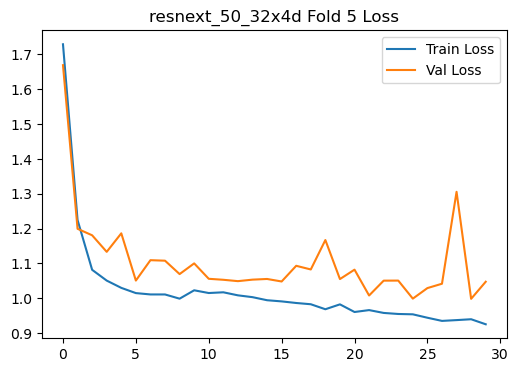


STARTING TRAINING: wide_resnet_50_2 (Size: 224)

--- FOLD 1/5 ---


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /home/usama/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:05<00:00, 47.3MB/s] 


Epoch 1: Train Loss 1.6619 | Val Loss 1.6836
Valid Loss (inf --> 1.683624).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2692 | Val Loss 1.1692
Valid Loss (1.683624 --> 1.169157).  Saving Model ...


Epoch 3: Train Loss 1.1357 | Val Loss 1.1431
Valid Loss (1.169157 --> 1.143052).  Saving Model ...


Epoch 4: Train Loss 1.1211 | Val Loss 1.1360
Valid Loss (1.143052 --> 1.135986).  Saving Model ...


Epoch 5: Train Loss 1.1142 | Val Loss 1.2934
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.0996 | Val Loss 1.0850
Valid Loss (1.135986 --> 1.084951).  Saving Model ...


Epoch 7: Train Loss 1.1028 | Val Loss 1.0458
Valid Loss (1.084951 --> 1.045782).  Saving Model ...


Epoch 8: Train Loss 1.1037 | Val Loss 1.5413
EarlyStopping counter: 1 out of 7


Epoch 9: Train Loss 1.1499 | Val Loss 1.2121
EarlyStopping counter: 2 out of 7


Epoch 10: Train Loss 1.1030 | Val Loss 1.0969
Valid Loss (1.045782 --> 1.096865).  Saving Model ...


Epoch 11: Train Loss 1.0941 | Val Loss 1.1733
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.0996 | Val Loss 1.1219
Valid Loss (1.096865 --> 1.121866).  Saving Model ...


Epoch 13: Train Loss 1.0869 | Val Loss 1.1010
Valid Loss (1.121866 --> 1.100968).  Saving Model ...


Epoch 14: Train Loss 1.0877 | Val Loss 1.3114
EarlyStopping counter: 1 out of 7


Epoch 15: Train Loss 1.0698 | Val Loss 1.1309
Valid Loss (1.100968 --> 1.130914).  Saving Model ...


Epoch 16: Train Loss 1.0686 | Val Loss 1.0546
Valid Loss (1.130914 --> 1.054611).  Saving Model ...


Epoch 17: Train Loss 1.0656 | Val Loss 1.0483
Valid Loss (1.054611 --> 1.048333).  Saving Model ...


Epoch 18: Train Loss 1.0635 | Val Loss 1.0780
Valid Loss (1.048333 --> 1.078017).  Saving Model ...


Epoch 19: Train Loss 1.0518 | Val Loss 1.1050
Valid Loss (1.078017 --> 1.105006).  Saving Model ...


Epoch 20: Train Loss 1.0522 | Val Loss 1.0513
Valid Loss (1.105006 --> 1.051309).  Saving Model ...


Epoch 21: Train Loss 1.0435 | Val Loss 1.0391
Valid Loss (1.051309 --> 1.039100).  Saving Model ...


Epoch 22: Train Loss 1.0328 | Val Loss 1.0977
Valid Loss (1.039100 --> 1.097657).  Saving Model ...


Epoch 23: Train Loss 1.0206 | Val Loss 1.0620
Valid Loss (1.097657 --> 1.061993).  Saving Model ...


Epoch 24: Train Loss 1.0185 | Val Loss 1.0705
Valid Loss (1.061993 --> 1.070463).  Saving Model ...


Epoch 25: Train Loss 1.0192 | Val Loss 1.0332
Valid Loss (1.070463 --> 1.033190).  Saving Model ...


Epoch 26: Train Loss 1.0054 | Val Loss 1.0604
Valid Loss (1.033190 --> 1.060357).  Saving Model ...


Epoch 27: Train Loss 1.0117 | Val Loss 1.0011
Valid Loss (1.060357 --> 1.001056).  Saving Model ...


Epoch 28: Train Loss 0.9962 | Val Loss 0.9988
Valid Loss (1.001056 --> 0.998844).  Saving Model ...


Epoch 29: Train Loss 0.9949 | Val Loss 1.0044
Valid Loss (0.998844 --> 1.004445).  Saving Model ...


Epoch 30: Train Loss 1.0033 | Val Loss 1.1061
EarlyStopping counter: 1 out of 7


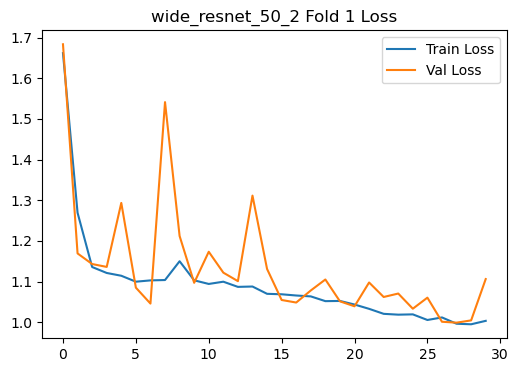


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.7284 | Val Loss 1.5182
Valid Loss (inf --> 1.518246).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3045 | Val Loss 1.3311
Valid Loss (1.518246 --> 1.331083).  Saving Model ...


Epoch 3: Train Loss 1.1640 | Val Loss 1.2193
Valid Loss (1.331083 --> 1.219326).  Saving Model ...


Epoch 4: Train Loss 1.1976 | Val Loss 1.1354
Valid Loss (1.219326 --> 1.135364).  Saving Model ...


Epoch 5: Train Loss 1.1392 | Val Loss 1.0782
Valid Loss (1.135364 --> 1.078213).  Saving Model ...


Epoch 6: Train Loss 1.1113 | Val Loss 1.0429
Valid Loss (1.078213 --> 1.042911).  Saving Model ...


Epoch 7: Train Loss 1.1034 | Val Loss 1.3015
EarlyStopping counter: 1 out of 7


Epoch 8: Train Loss 1.1189 | Val Loss 1.2383
EarlyStopping counter: 2 out of 7


Epoch 9: Train Loss 1.0973 | Val Loss 1.0431
Valid Loss (1.042911 --> 1.043124).  Saving Model ...


Epoch 10: Train Loss 1.0957 | Val Loss 1.1288
Valid Loss (1.043124 --> 1.128843).  Saving Model ...


Epoch 11: Train Loss 1.0774 | Val Loss 1.1097
Valid Loss (1.128843 --> 1.109650).  Saving Model ...


Epoch 12: Train Loss 1.0868 | Val Loss 1.0631
Valid Loss (1.109650 --> 1.063083).  Saving Model ...


Epoch 13: Train Loss 1.0736 | Val Loss 1.0854
Valid Loss (1.063083 --> 1.085378).  Saving Model ...


Epoch 14: Train Loss 1.0819 | Val Loss 1.0566
Valid Loss (1.085378 --> 1.056596).  Saving Model ...


Epoch 15: Train Loss 1.0694 | Val Loss 1.1024
Valid Loss (1.056596 --> 1.102355).  Saving Model ...


Epoch 16: Train Loss 1.0746 | Val Loss 1.0747
Valid Loss (1.102355 --> 1.074703).  Saving Model ...


Epoch 17: Train Loss 1.0699 | Val Loss 1.0741
Valid Loss (1.074703 --> 1.074125).  Saving Model ...


Epoch 18: Train Loss 1.0636 | Val Loss 1.0343
Valid Loss (1.074125 --> 1.034321).  Saving Model ...


Epoch 19: Train Loss 1.0414 | Val Loss 1.0207
Valid Loss (1.034321 --> 1.020686).  Saving Model ...


Epoch 20: Train Loss 1.0468 | Val Loss 1.0416
Valid Loss (1.020686 --> 1.041581).  Saving Model ...


Epoch 21: Train Loss 1.0435 | Val Loss 1.1527
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 1.0321 | Val Loss 1.1038
Valid Loss (1.041581 --> 1.103752).  Saving Model ...


Epoch 23: Train Loss 1.0363 | Val Loss 1.0865
Valid Loss (1.103752 --> 1.086490).  Saving Model ...


Epoch 24: Train Loss 1.0368 | Val Loss 1.1086
Valid Loss (1.086490 --> 1.108584).  Saving Model ...


Epoch 25: Train Loss 1.0194 | Val Loss 1.0444
Valid Loss (1.108584 --> 1.044416).  Saving Model ...


Epoch 26: Train Loss 1.0308 | Val Loss 1.0202
Valid Loss (1.044416 --> 1.020224).  Saving Model ...


Epoch 27: Train Loss 1.0153 | Val Loss 1.0372
Valid Loss (1.020224 --> 1.037240).  Saving Model ...


Epoch 28: Train Loss 1.0092 | Val Loss 1.1223
EarlyStopping counter: 1 out of 7


Epoch 29: Train Loss 1.0116 | Val Loss 1.0519
Valid Loss (1.037240 --> 1.051870).  Saving Model ...


Epoch 30: Train Loss 1.0143 | Val Loss 0.9888
Valid Loss (1.051870 --> 0.988774).  Saving Model ...


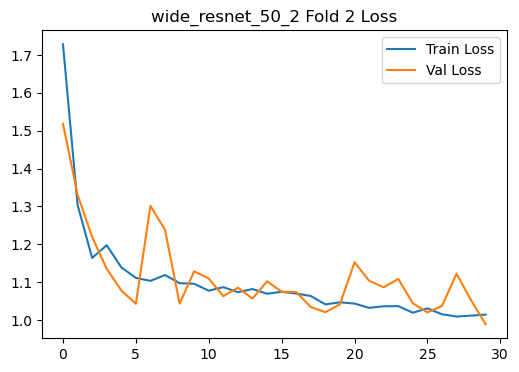


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.6612 | Val Loss 1.9027
Valid Loss (inf --> 1.902692).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3084 | Val Loss 1.3859
Valid Loss (1.902692 --> 1.385861).  Saving Model ...


Epoch 3: Train Loss 1.1712 | Val Loss 1.2363
Valid Loss (1.385861 --> 1.236321).  Saving Model ...


Epoch 4: Train Loss 1.1414 | Val Loss 1.0759
Valid Loss (1.236321 --> 1.075896).  Saving Model ...


Epoch 5: Train Loss 1.1308 | Val Loss 1.2415
EarlyStopping counter: 1 out of 7


Epoch 6: Train Loss 1.1633 | Val Loss 1.1257
Valid Loss (1.075896 --> 1.125666).  Saving Model ...


Epoch 7: Train Loss 1.1297 | Val Loss 1.0642
Valid Loss (1.125666 --> 1.064170).  Saving Model ...


Epoch 8: Train Loss 1.0967 | Val Loss 1.0874
Valid Loss (1.064170 --> 1.087409).  Saving Model ...


Epoch 9: Train Loss 1.0927 | Val Loss 1.2935
EarlyStopping counter: 1 out of 7


Epoch 10: Train Loss 1.0961 | Val Loss 1.2928
EarlyStopping counter: 2 out of 7


Epoch 11: Train Loss 1.1019 | Val Loss 1.1630
Valid Loss (1.087409 --> 1.162962).  Saving Model ...


Epoch 12: Train Loss 1.0792 | Val Loss 1.0767
Valid Loss (1.162962 --> 1.076678).  Saving Model ...


Epoch 13: Train Loss 1.0874 | Val Loss 1.6571
EarlyStopping counter: 1 out of 7


Epoch 14: Train Loss 1.0722 | Val Loss 1.0639
Valid Loss (1.076678 --> 1.063889).  Saving Model ...


Epoch 15: Train Loss 1.0709 | Val Loss 1.1336
Valid Loss (1.063889 --> 1.133633).  Saving Model ...


Epoch 16: Train Loss 1.0613 | Val Loss 1.1194
Valid Loss (1.133633 --> 1.119402).  Saving Model ...


Epoch 17: Train Loss 1.0588 | Val Loss 1.3074
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 1.0414 | Val Loss 1.1141
Valid Loss (1.119402 --> 1.114076).  Saving Model ...


Epoch 19: Train Loss 1.0415 | Val Loss 1.0160
Valid Loss (1.114076 --> 1.016017).  Saving Model ...


Epoch 20: Train Loss 1.0429 | Val Loss 1.0437
Valid Loss (1.016017 --> 1.043749).  Saving Model ...


Epoch 21: Train Loss 1.0406 | Val Loss 1.1952
EarlyStopping counter: 1 out of 7


Epoch 22: Train Loss 1.0365 | Val Loss 1.0672
Valid Loss (1.043749 --> 1.067185).  Saving Model ...


Epoch 23: Train Loss 1.0332 | Val Loss 1.0439
Valid Loss (1.067185 --> 1.043917).  Saving Model ...


Epoch 24: Train Loss 1.0109 | Val Loss 1.0230
Valid Loss (1.043917 --> 1.022986).  Saving Model ...


Epoch 25: Train Loss 1.0131 | Val Loss 0.9944
Valid Loss (1.022986 --> 0.994397).  Saving Model ...


Epoch 26: Train Loss 1.0042 | Val Loss 1.1832
EarlyStopping counter: 1 out of 7


Epoch 27: Train Loss 1.0092 | Val Loss 1.0961
EarlyStopping counter: 2 out of 7


Epoch 28: Train Loss 1.0025 | Val Loss 1.0182
Valid Loss (0.994397 --> 1.018215).  Saving Model ...


Epoch 29: Train Loss 1.0042 | Val Loss 1.0078
Valid Loss (1.018215 --> 1.007760).  Saving Model ...


Epoch 30: Train Loss 1.0004 | Val Loss 1.0487
Valid Loss (1.007760 --> 1.048711).  Saving Model ...


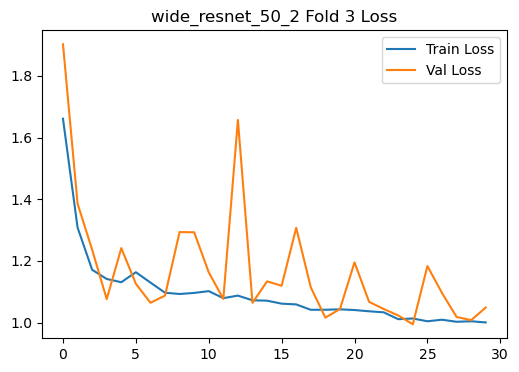


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.6417 | Val Loss 1.5785
Valid Loss (inf --> 1.578520).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3698 | Val Loss 1.3854
Valid Loss (1.578520 --> 1.385395).  Saving Model ...


Epoch 3: Train Loss 1.2149 | Val Loss 1.5489
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.1636 | Val Loss 1.7563
EarlyStopping counter: 2 out of 7


Epoch 5: Train Loss 1.1339 | Val Loss 1.4384
Valid Loss (1.385395 --> 1.438371).  Saving Model ...


Epoch 6: Train Loss 1.1303 | Val Loss 1.2220
Valid Loss (1.438371 --> 1.221974).  Saving Model ...


Epoch 7: Train Loss 1.1070 | Val Loss 1.0621
Valid Loss (1.221974 --> 1.062052).  Saving Model ...


Epoch 8: Train Loss 1.0982 | Val Loss 1.1166
Valid Loss (1.062052 --> 1.116565).  Saving Model ...


Epoch 9: Train Loss 1.0928 | Val Loss 1.0631
Valid Loss (1.116565 --> 1.063116).  Saving Model ...


Epoch 10: Train Loss 1.1027 | Val Loss 1.1488
Valid Loss (1.063116 --> 1.148825).  Saving Model ...


Epoch 11: Train Loss 1.0789 | Val Loss 1.2529
EarlyStopping counter: 1 out of 7


Epoch 12: Train Loss 1.0791 | Val Loss 1.1500
Valid Loss (1.148825 --> 1.150009).  Saving Model ...


Epoch 13: Train Loss 1.0828 | Val Loss 1.1270
Valid Loss (1.150009 --> 1.126986).  Saving Model ...


Epoch 14: Train Loss 1.0666 | Val Loss 1.2433
EarlyStopping counter: 1 out of 7


Epoch 15: Train Loss 1.0649 | Val Loss 1.2551
EarlyStopping counter: 2 out of 7


Epoch 16: Train Loss 1.0534 | Val Loss 1.2177
EarlyStopping counter: 3 out of 7


Epoch 17: Train Loss 1.0489 | Val Loss 1.0932
Valid Loss (1.126986 --> 1.093173).  Saving Model ...


Epoch 18: Train Loss 1.0648 | Val Loss 1.0570
Valid Loss (1.093173 --> 1.057033).  Saving Model ...


Epoch 19: Train Loss 1.0406 | Val Loss 1.2195
EarlyStopping counter: 1 out of 7


Epoch 20: Train Loss 1.0457 | Val Loss 1.1006
Valid Loss (1.057033 --> 1.100634).  Saving Model ...


Epoch 21: Train Loss 1.0319 | Val Loss 1.1054
Valid Loss (1.100634 --> 1.105374).  Saving Model ...


Epoch 22: Train Loss 1.0323 | Val Loss 1.0663
Valid Loss (1.105374 --> 1.066332).  Saving Model ...


Epoch 23: Train Loss 1.0191 | Val Loss 1.1168
Valid Loss (1.066332 --> 1.116751).  Saving Model ...


Epoch 24: Train Loss 1.0290 | Val Loss 1.0982
Valid Loss (1.116751 --> 1.098160).  Saving Model ...


Epoch 25: Train Loss 1.0110 | Val Loss 1.0532
Valid Loss (1.098160 --> 1.053184).  Saving Model ...


Epoch 26: Train Loss 1.0162 | Val Loss 1.1055
Valid Loss (1.053184 --> 1.105507).  Saving Model ...


Epoch 27: Train Loss 1.0033 | Val Loss 1.5614
EarlyStopping counter: 1 out of 7


Epoch 28: Train Loss 0.9986 | Val Loss 1.1984
EarlyStopping counter: 2 out of 7


Epoch 29: Train Loss 0.9957 | Val Loss 0.9982
Valid Loss (1.105507 --> 0.998181).  Saving Model ...


Epoch 30: Train Loss 0.9991 | Val Loss 1.0505
Valid Loss (0.998181 --> 1.050533).  Saving Model ...


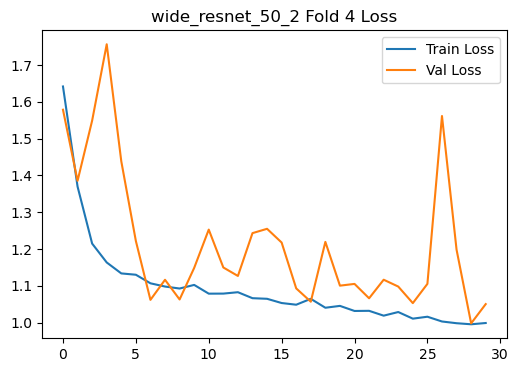


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.6697 | Val Loss 1.4867
Valid Loss (inf --> 1.486672).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.3189 | Val Loss 1.2177
Valid Loss (1.486672 --> 1.217654).  Saving Model ...


Epoch 3: Train Loss 1.1756 | Val Loss 1.1321
Valid Loss (1.217654 --> 1.132106).  Saving Model ...


Epoch 4: Train Loss 1.1434 | Val Loss 1.1408
Valid Loss (1.132106 --> 1.140816).  Saving Model ...


Epoch 5: Train Loss 1.1314 | Val Loss 1.2165
Valid Loss (1.140816 --> 1.216452).  Saving Model ...


Epoch 6: Train Loss 1.1359 | Val Loss 1.1783
Valid Loss (1.216452 --> 1.178300).  Saving Model ...


Epoch 7: Train Loss 1.1182 | Val Loss 1.1257
Valid Loss (1.178300 --> 1.125654).  Saving Model ...


Epoch 8: Train Loss 1.1134 | Val Loss 1.2791
EarlyStopping counter: 1 out of 7


Epoch 9: Train Loss 1.1009 | Val Loss 1.0802
Valid Loss (1.125654 --> 1.080183).  Saving Model ...


Epoch 10: Train Loss 1.0863 | Val Loss 1.0965
Valid Loss (1.080183 --> 1.096536).  Saving Model ...


Epoch 11: Train Loss 1.0818 | Val Loss 1.1509
Valid Loss (1.096536 --> 1.150945).  Saving Model ...


Epoch 12: Train Loss 1.0805 | Val Loss 1.0851
Valid Loss (1.150945 --> 1.085056).  Saving Model ...


Epoch 13: Train Loss 1.0697 | Val Loss 1.1971
EarlyStopping counter: 1 out of 7


Epoch 14: Train Loss 1.0652 | Val Loss 1.1440
Valid Loss (1.085056 --> 1.144001).  Saving Model ...


Epoch 15: Train Loss 1.0585 | Val Loss 1.0812
Valid Loss (1.144001 --> 1.081168).  Saving Model ...


Epoch 16: Train Loss 1.0794 | Val Loss 1.1413
Valid Loss (1.081168 --> 1.141321).  Saving Model ...


Epoch 17: Train Loss 1.0481 | Val Loss 1.0950
Valid Loss (1.141321 --> 1.095005).  Saving Model ...


Epoch 18: Train Loss 1.0434 | Val Loss 1.0528
Valid Loss (1.095005 --> 1.052773).  Saving Model ...


Epoch 19: Train Loss 1.0445 | Val Loss 1.0821
Valid Loss (1.052773 --> 1.082079).  Saving Model ...


Epoch 20: Train Loss 1.0435 | Val Loss 1.0560
Valid Loss (1.082079 --> 1.055953).  Saving Model ...


Epoch 21: Train Loss 1.0351 | Val Loss 1.0756
Valid Loss (1.055953 --> 1.075554).  Saving Model ...


Epoch 22: Train Loss 1.0336 | Val Loss 1.1632
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 1.0156 | Val Loss 1.0894
Valid Loss (1.075554 --> 1.089425).  Saving Model ...


Epoch 24: Train Loss 1.0225 | Val Loss 1.0994
Valid Loss (1.089425 --> 1.099432).  Saving Model ...


Epoch 25: Train Loss 1.0121 | Val Loss 1.0312
Valid Loss (1.099432 --> 1.031171).  Saving Model ...


Epoch 26: Train Loss 1.0146 | Val Loss 1.0364
Valid Loss (1.031171 --> 1.036421).  Saving Model ...


Epoch 27: Train Loss 1.0007 | Val Loss 1.0491
Valid Loss (1.036421 --> 1.049059).  Saving Model ...


Epoch 28: Train Loss 0.9932 | Val Loss 1.0602
Valid Loss (1.049059 --> 1.060209).  Saving Model ...


Epoch 29: Train Loss 1.0052 | Val Loss 1.0991
Valid Loss (1.060209 --> 1.099105).  Saving Model ...


Epoch 30: Train Loss 0.9966 | Val Loss 1.0497
Valid Loss (1.099105 --> 1.049740).  Saving Model ...


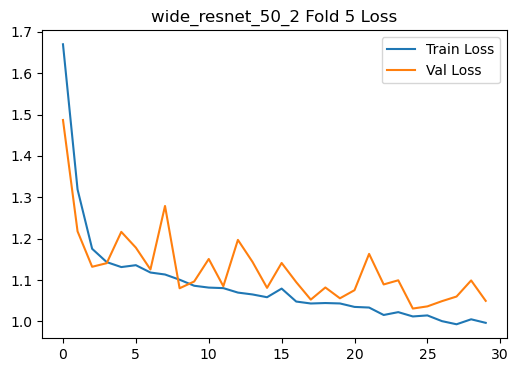


STARTING TRAINING: shufflenet_v2_x2_0 (Size: 224)

--- FOLD 1/5 ---


Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /home/usama/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:02<00:00, 11.2MB/s]


Epoch 1: Train Loss 1.6201 | Val Loss 2.4815
Valid Loss (inf --> 2.481509).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2881 | Val Loss 2.7229
EarlyStopping counter: 1 out of 7


Epoch 3: Train Loss 1.1275 | Val Loss 1.2625
Valid Loss (2.481509 --> 1.262480).  Saving Model ...


Epoch 4: Train Loss 1.0761 | Val Loss 1.1666
Valid Loss (1.262480 --> 1.166556).  Saving Model ...


Epoch 5: Train Loss 1.0521 | Val Loss 1.0565
Valid Loss (1.166556 --> 1.056475).  Saving Model ...


Epoch 6: Train Loss 1.0376 | Val Loss 1.0217
Valid Loss (1.056475 --> 1.021727).  Saving Model ...


Epoch 7: Train Loss 1.0308 | Val Loss 1.1824
EarlyStopping counter: 1 out of 7


Epoch 8: Train Loss 1.0216 | Val Loss 1.0189
Valid Loss (1.021727 --> 1.018897).  Saving Model ...


Epoch 9: Train Loss 1.0187 | Val Loss 1.0144
Valid Loss (1.018897 --> 1.014351).  Saving Model ...


Epoch 10: Train Loss 1.0135 | Val Loss 1.0086
Valid Loss (1.014351 --> 1.008573).  Saving Model ...


Epoch 11: Train Loss 1.0112 | Val Loss 1.0190
Valid Loss (1.008573 --> 1.019038).  Saving Model ...


Epoch 12: Train Loss 1.0053 | Val Loss 1.2521
EarlyStopping counter: 1 out of 7


Epoch 13: Train Loss 1.0075 | Val Loss 1.0059
Valid Loss (1.019038 --> 1.005913).  Saving Model ...


Epoch 14: Train Loss 0.9980 | Val Loss 0.9934
Valid Loss (1.005913 --> 0.993443).  Saving Model ...


Epoch 15: Train Loss 0.9993 | Val Loss 1.0030
Valid Loss (0.993443 --> 1.003044).  Saving Model ...


Epoch 16: Train Loss 0.9937 | Val Loss 1.3875
EarlyStopping counter: 1 out of 7


Epoch 17: Train Loss 0.9851 | Val Loss 0.9941
Valid Loss (1.003044 --> 0.994126).  Saving Model ...


Epoch 18: Train Loss 0.9774 | Val Loss 1.0379
Valid Loss (0.994126 --> 1.037892).  Saving Model ...


Epoch 19: Train Loss 0.9845 | Val Loss 1.0051
Valid Loss (1.037892 --> 1.005123).  Saving Model ...


Epoch 20: Train Loss 0.9775 | Val Loss 1.0447
Valid Loss (1.005123 --> 1.044689).  Saving Model ...


Epoch 21: Train Loss 0.9750 | Val Loss 1.0208
Valid Loss (1.044689 --> 1.020764).  Saving Model ...


Epoch 22: Train Loss 0.9638 | Val Loss 1.0290
Valid Loss (1.020764 --> 1.029008).  Saving Model ...


Epoch 23: Train Loss 0.9682 | Val Loss 1.0117
Valid Loss (1.029008 --> 1.011689).  Saving Model ...


Epoch 24: Train Loss 0.9622 | Val Loss 0.9714
Valid Loss (1.011689 --> 0.971412).  Saving Model ...


Epoch 25: Train Loss 0.9579 | Val Loss 1.0318
Valid Loss (0.971412 --> 1.031794).  Saving Model ...


Epoch 26: Train Loss 0.9536 | Val Loss 0.9775
Valid Loss (1.031794 --> 0.977531).  Saving Model ...


Epoch 27: Train Loss 0.9526 | Val Loss 0.9900
Valid Loss (0.977531 --> 0.990006).  Saving Model ...


Epoch 28: Train Loss 0.9568 | Val Loss 1.0100
Valid Loss (0.990006 --> 1.010040).  Saving Model ...


Epoch 29: Train Loss 0.9431 | Val Loss 0.9783
Valid Loss (1.010040 --> 0.978291).  Saving Model ...


Epoch 30: Train Loss 0.9412 | Val Loss 1.0180
Valid Loss (0.978291 --> 1.017974).  Saving Model ...


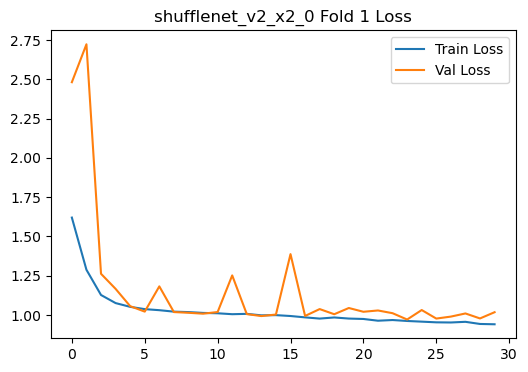


--- FOLD 2/5 ---


Epoch 1: Train Loss 1.6930 | Val Loss 3.3225
Valid Loss (inf --> 3.322450).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2679 | Val Loss 1.1069
Valid Loss (3.322450 --> 1.106887).  Saving Model ...


Epoch 3: Train Loss 1.1170 | Val Loss 1.4303
EarlyStopping counter: 1 out of 7


Epoch 4: Train Loss 1.0865 | Val Loss 1.0559
Valid Loss (1.106887 --> 1.055901).  Saving Model ...


Epoch 5: Train Loss 1.0709 | Val Loss 1.0922
Valid Loss (1.055901 --> 1.092229).  Saving Model ...


Epoch 6: Train Loss 1.0524 | Val Loss 1.0161
Valid Loss (1.092229 --> 1.016106).  Saving Model ...


Epoch 7: Train Loss 1.0275 | Val Loss 1.0484
Valid Loss (1.016106 --> 1.048425).  Saving Model ...


Epoch 8: Train Loss 1.0315 | Val Loss 1.0300
Valid Loss (1.048425 --> 1.029991).  Saving Model ...


Epoch 9: Train Loss 1.0194 | Val Loss 1.0208
Valid Loss (1.029991 --> 1.020838).  Saving Model ...


Epoch 10: Train Loss 1.0195 | Val Loss 1.0604
Valid Loss (1.020838 --> 1.060370).  Saving Model ...


Epoch 11: Train Loss 1.0057 | Val Loss 1.0508
Valid Loss (1.060370 --> 1.050816).  Saving Model ...


Epoch 12: Train Loss 1.0077 | Val Loss 1.0071
Valid Loss (1.050816 --> 1.007104).  Saving Model ...


Epoch 13: Train Loss 1.0038 | Val Loss 1.0841
Valid Loss (1.007104 --> 1.084053).  Saving Model ...


Epoch 14: Train Loss 0.9890 | Val Loss 1.0096
Valid Loss (1.084053 --> 1.009562).  Saving Model ...


Epoch 15: Train Loss 0.9876 | Val Loss 1.0447
Valid Loss (1.009562 --> 1.044704).  Saving Model ...


Epoch 16: Train Loss 0.9868 | Val Loss 1.0081
Valid Loss (1.044704 --> 1.008123).  Saving Model ...


Epoch 17: Train Loss 0.9830 | Val Loss 1.0418
Valid Loss (1.008123 --> 1.041769).  Saving Model ...


Epoch 18: Train Loss 0.9851 | Val Loss 1.0713
Valid Loss (1.041769 --> 1.071334).  Saving Model ...


Epoch 19: Train Loss 0.9825 | Val Loss 1.0329
Valid Loss (1.071334 --> 1.032945).  Saving Model ...


Epoch 20: Train Loss 0.9682 | Val Loss 1.0366
Valid Loss (1.032945 --> 1.036588).  Saving Model ...


Epoch 21: Train Loss 0.9675 | Val Loss 1.0368
Valid Loss (1.036588 --> 1.036779).  Saving Model ...


Epoch 22: Train Loss 0.9682 | Val Loss 1.0155
Valid Loss (1.036779 --> 1.015484).  Saving Model ...


Epoch 23: Train Loss 0.9655 | Val Loss 1.0071
Valid Loss (1.015484 --> 1.007096).  Saving Model ...


Epoch 24: Train Loss 0.9589 | Val Loss 0.9856
Valid Loss (1.007096 --> 0.985636).  Saving Model ...


Epoch 25: Train Loss 0.9511 | Val Loss 0.9886
Valid Loss (0.985636 --> 0.988647).  Saving Model ...


Epoch 26: Train Loss 0.9459 | Val Loss 1.0304
Valid Loss (0.988647 --> 1.030387).  Saving Model ...


Epoch 27: Train Loss 0.9480 | Val Loss 0.9934
Valid Loss (1.030387 --> 0.993407).  Saving Model ...


Epoch 28: Train Loss 0.9342 | Val Loss 1.0098
Valid Loss (0.993407 --> 1.009837).  Saving Model ...


Epoch 29: Train Loss 0.9367 | Val Loss 0.9899
Valid Loss (1.009837 --> 0.989940).  Saving Model ...


Epoch 30: Train Loss 0.9224 | Val Loss 1.0770
Valid Loss (0.989940 --> 1.076982).  Saving Model ...


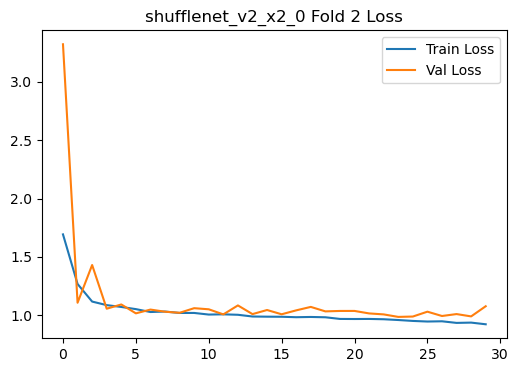


--- FOLD 3/5 ---


Epoch 1: Train Loss 1.6726 | Val Loss 2.2267
Valid Loss (inf --> 2.226721).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2625 | Val Loss 1.1563
Valid Loss (2.226721 --> 1.156344).  Saving Model ...


Epoch 3: Train Loss 1.1198 | Val Loss 1.0735
Valid Loss (1.156344 --> 1.073481).  Saving Model ...


Epoch 4: Train Loss 1.0697 | Val Loss 1.1663
Valid Loss (1.073481 --> 1.166334).  Saving Model ...


Epoch 5: Train Loss 1.0633 | Val Loss 1.1064
Valid Loss (1.166334 --> 1.106409).  Saving Model ...


Epoch 6: Train Loss 1.0424 | Val Loss 2.3073
EarlyStopping counter: 1 out of 7


Epoch 7: Train Loss 1.0426 | Val Loss 1.0496
Valid Loss (1.106409 --> 1.049599).  Saving Model ...


Epoch 8: Train Loss 1.0274 | Val Loss 1.0416
Valid Loss (1.049599 --> 1.041572).  Saving Model ...


Epoch 9: Train Loss 1.0276 | Val Loss 1.0545
Valid Loss (1.041572 --> 1.054462).  Saving Model ...


Epoch 10: Train Loss 1.0171 | Val Loss 1.0721
Valid Loss (1.054462 --> 1.072112).  Saving Model ...


Epoch 11: Train Loss 1.0156 | Val Loss 1.0417
Valid Loss (1.072112 --> 1.041671).  Saving Model ...


Epoch 12: Train Loss 1.0072 | Val Loss 1.0625
Valid Loss (1.041671 --> 1.062456).  Saving Model ...


Epoch 13: Train Loss 1.0087 | Val Loss 1.1278
Valid Loss (1.062456 --> 1.127845).  Saving Model ...


Epoch 14: Train Loss 0.9934 | Val Loss 1.0243
Valid Loss (1.127845 --> 1.024316).  Saving Model ...


Epoch 15: Train Loss 0.9928 | Val Loss 1.0382
Valid Loss (1.024316 --> 1.038154).  Saving Model ...


Epoch 16: Train Loss 0.9886 | Val Loss 1.0910
Valid Loss (1.038154 --> 1.091008).  Saving Model ...


Epoch 17: Train Loss 0.9883 | Val Loss 1.0144
Valid Loss (1.091008 --> 1.014445).  Saving Model ...


Epoch 18: Train Loss 0.9797 | Val Loss 1.0374
Valid Loss (1.014445 --> 1.037423).  Saving Model ...


Epoch 19: Train Loss 0.9886 | Val Loss 1.0218
Valid Loss (1.037423 --> 1.021787).  Saving Model ...


Epoch 20: Train Loss 0.9818 | Val Loss 1.0002
Valid Loss (1.021787 --> 1.000162).  Saving Model ...


Epoch 21: Train Loss 0.9699 | Val Loss 1.0056
Valid Loss (1.000162 --> 1.005639).  Saving Model ...


Epoch 22: Train Loss 0.9711 | Val Loss 1.1028
EarlyStopping counter: 1 out of 7


Epoch 23: Train Loss 0.9579 | Val Loss 1.0342
Valid Loss (1.005639 --> 1.034231).  Saving Model ...


Epoch 24: Train Loss 0.9576 | Val Loss 1.0214
Valid Loss (1.034231 --> 1.021410).  Saving Model ...


Epoch 25: Train Loss 0.9566 | Val Loss 1.0010
Valid Loss (1.021410 --> 1.000995).  Saving Model ...


Epoch 26: Train Loss 0.9664 | Val Loss 1.1111
EarlyStopping counter: 1 out of 7


Epoch 27: Train Loss 0.9571 | Val Loss 1.0098
Valid Loss (1.000995 --> 1.009758).  Saving Model ...


Epoch 28: Train Loss 0.9495 | Val Loss 1.0672
Valid Loss (1.009758 --> 1.067171).  Saving Model ...


Epoch 29: Train Loss 0.9504 | Val Loss 1.0358
Valid Loss (1.067171 --> 1.035775).  Saving Model ...


Epoch 30: Train Loss 0.9427 | Val Loss 1.0416
Valid Loss (1.035775 --> 1.041565).  Saving Model ...


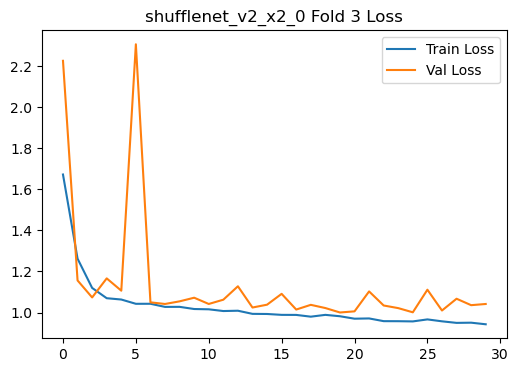


--- FOLD 4/5 ---


Epoch 1: Train Loss 1.7022 | Val Loss 1.9823
Valid Loss (inf --> 1.982327).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2684 | Val Loss 1.3213
Valid Loss (1.982327 --> 1.321280).  Saving Model ...


Epoch 3: Train Loss 1.1125 | Val Loss 1.1301
Valid Loss (1.321280 --> 1.130050).  Saving Model ...


Epoch 4: Train Loss 1.0831 | Val Loss 1.1653
Valid Loss (1.130050 --> 1.165268).  Saving Model ...


Epoch 5: Train Loss 1.0577 | Val Loss 1.1094
Valid Loss (1.165268 --> 1.109431).  Saving Model ...


Epoch 6: Train Loss 1.0410 | Val Loss 1.0783
Valid Loss (1.109431 --> 1.078251).  Saving Model ...


Epoch 7: Train Loss 1.0312 | Val Loss 1.1379
Valid Loss (1.078251 --> 1.137882).  Saving Model ...


Epoch 8: Train Loss 1.0264 | Val Loss 1.1043
Valid Loss (1.137882 --> 1.104259).  Saving Model ...


Epoch 9: Train Loss 1.0242 | Val Loss 1.0604
Valid Loss (1.104259 --> 1.060389).  Saving Model ...


Epoch 10: Train Loss 0.9994 | Val Loss 1.0599
Valid Loss (1.060389 --> 1.059908).  Saving Model ...


Epoch 11: Train Loss 1.0006 | Val Loss 1.0824
Valid Loss (1.059908 --> 1.082441).  Saving Model ...


Epoch 12: Train Loss 0.9910 | Val Loss 1.0670
Valid Loss (1.082441 --> 1.066965).  Saving Model ...


Epoch 13: Train Loss 0.9884 | Val Loss 1.0543
Valid Loss (1.066965 --> 1.054292).  Saving Model ...


Epoch 14: Train Loss 0.9872 | Val Loss 1.0250
Valid Loss (1.054292 --> 1.025021).  Saving Model ...


Epoch 15: Train Loss 0.9778 | Val Loss 1.0257
Valid Loss (1.025021 --> 1.025695).  Saving Model ...


Epoch 16: Train Loss 0.9944 | Val Loss 1.0977
Valid Loss (1.025695 --> 1.097736).  Saving Model ...


Epoch 17: Train Loss 0.9673 | Val Loss 1.0628
Valid Loss (1.097736 --> 1.062781).  Saving Model ...


Epoch 18: Train Loss 0.9838 | Val Loss 0.9999
Valid Loss (1.062781 --> 0.999950).  Saving Model ...


Epoch 19: Train Loss 0.9686 | Val Loss 1.0570
Valid Loss (0.999950 --> 1.056963).  Saving Model ...


Epoch 20: Train Loss 0.9578 | Val Loss 1.0584
Valid Loss (1.056963 --> 1.058414).  Saving Model ...


Epoch 21: Train Loss 0.9657 | Val Loss 1.0295
Valid Loss (1.058414 --> 1.029545).  Saving Model ...


Epoch 22: Train Loss 0.9589 | Val Loss 1.0132
Valid Loss (1.029545 --> 1.013198).  Saving Model ...


Epoch 23: Train Loss 0.9578 | Val Loss 1.0010
Valid Loss (1.013198 --> 1.000992).  Saving Model ...


Epoch 24: Train Loss 0.9544 | Val Loss 1.0774
Valid Loss (1.000992 --> 1.077412).  Saving Model ...


Epoch 25: Train Loss 0.9542 | Val Loss 1.0051
Valid Loss (1.077412 --> 1.005067).  Saving Model ...


Epoch 26: Train Loss 0.9437 | Val Loss 1.0158
Valid Loss (1.005067 --> 1.015806).  Saving Model ...


Epoch 27: Train Loss 0.9636 | Val Loss 0.9984
Valid Loss (1.015806 --> 0.998409).  Saving Model ...


Epoch 28: Train Loss 0.9442 | Val Loss 1.0114
Valid Loss (0.998409 --> 1.011378).  Saving Model ...


Epoch 29: Train Loss 0.9396 | Val Loss 1.0363
Valid Loss (1.011378 --> 1.036320).  Saving Model ...


Epoch 30: Train Loss 0.9336 | Val Loss 1.0290
Valid Loss (1.036320 --> 1.029037).  Saving Model ...


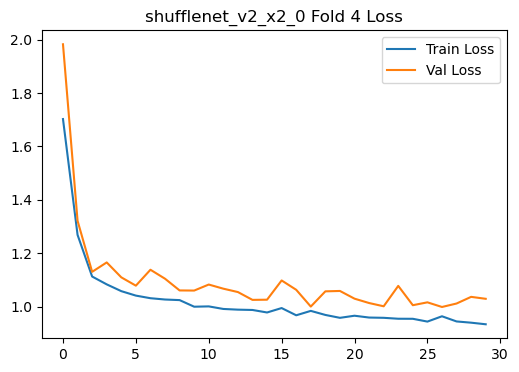


--- FOLD 5/5 ---


Epoch 1: Train Loss 1.6350 | Val Loss 2.7713
Valid Loss (inf --> 2.771318).  Saving Model ...
Unfreezing all parameters...


Epoch 2: Train Loss 1.2777 | Val Loss 1.1552
Valid Loss (2.771318 --> 1.155153).  Saving Model ...


Epoch 3: Train Loss 1.1245 | Val Loss 1.0686
Valid Loss (1.155153 --> 1.068611).  Saving Model ...


Epoch 4: Train Loss 1.0727 | Val Loss 1.0661
Valid Loss (1.068611 --> 1.066111).  Saving Model ...


Epoch 5: Train Loss 1.0566 | Val Loss 1.1273
Valid Loss (1.066111 --> 1.127282).  Saving Model ...


Epoch 6: Train Loss 1.0424 | Val Loss 1.0133
Valid Loss (1.127282 --> 1.013263).  Saving Model ...


Epoch 7: Train Loss 1.0283 | Val Loss 1.0519
Valid Loss (1.013263 --> 1.051912).  Saving Model ...


Epoch 8: Train Loss 1.0245 | Val Loss 1.0518
Valid Loss (1.051912 --> 1.051821).  Saving Model ...


Epoch 9: Train Loss 1.0080 | Val Loss 1.0340
Valid Loss (1.051821 --> 1.034023).  Saving Model ...


Epoch 10: Train Loss 1.0156 | Val Loss 1.0527
Valid Loss (1.034023 --> 1.052701).  Saving Model ...


Epoch 11: Train Loss 1.0067 | Val Loss 1.0513
Valid Loss (1.052701 --> 1.051270).  Saving Model ...


Epoch 12: Train Loss 1.0157 | Val Loss 1.0399
Valid Loss (1.051270 --> 1.039892).  Saving Model ...


Epoch 13: Train Loss 1.0060 | Val Loss 1.0433
Valid Loss (1.039892 --> 1.043329).  Saving Model ...


Epoch 14: Train Loss 0.9972 | Val Loss 1.0117
Valid Loss (1.043329 --> 1.011657).  Saving Model ...


Epoch 15: Train Loss 0.9922 | Val Loss 1.0723
Valid Loss (1.011657 --> 1.072349).  Saving Model ...


Epoch 16: Train Loss 0.9822 | Val Loss 1.0118
Valid Loss (1.072349 --> 1.011775).  Saving Model ...


Epoch 17: Train Loss 0.9753 | Val Loss 1.1156
EarlyStopping counter: 1 out of 7


Epoch 18: Train Loss 0.9876 | Val Loss 1.0615
Valid Loss (1.011775 --> 1.061531).  Saving Model ...


Epoch 19: Train Loss 0.9696 | Val Loss 1.0553
Valid Loss (1.061531 --> 1.055338).  Saving Model ...


Epoch 20: Train Loss 0.9783 | Val Loss 1.0027
Valid Loss (1.055338 --> 1.002671).  Saving Model ...


Epoch 21: Train Loss 0.9638 | Val Loss 1.0287
Valid Loss (1.002671 --> 1.028713).  Saving Model ...


Epoch 22: Train Loss 0.9729 | Val Loss 1.0341
Valid Loss (1.028713 --> 1.034130).  Saving Model ...


Epoch 23: Train Loss 0.9673 | Val Loss 1.0135
Valid Loss (1.034130 --> 1.013461).  Saving Model ...


Epoch 24: Train Loss 0.9482 | Val Loss 1.0219
Valid Loss (1.013461 --> 1.021938).  Saving Model ...


Epoch 25: Train Loss 0.9484 | Val Loss 1.0716
Valid Loss (1.021938 --> 1.071572).  Saving Model ...


Epoch 26: Train Loss 0.9558 | Val Loss 1.0244
Valid Loss (1.071572 --> 1.024410).  Saving Model ...


Epoch 27: Train Loss 0.9426 | Val Loss 1.0549
Valid Loss (1.024410 --> 1.054936).  Saving Model ...


Epoch 28: Train Loss 0.9507 | Val Loss 1.0586
Valid Loss (1.054936 --> 1.058553).  Saving Model ...


Epoch 29: Train Loss 0.9432 | Val Loss 1.0046
Valid Loss (1.058553 --> 1.004597).  Saving Model ...


Epoch 30: Train Loss 0.9313 | Val Loss 1.0102
Valid Loss (1.004597 --> 1.010187).  Saving Model ...


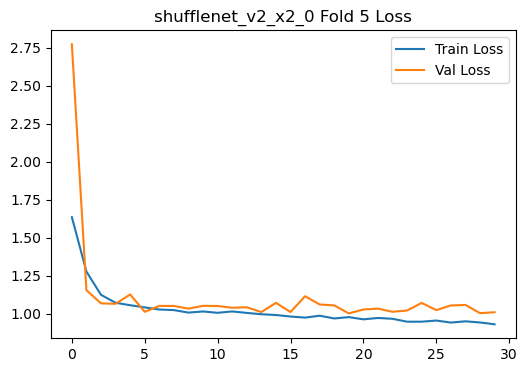


STARTING TESTING PHASE


NameError: name 'image_size' is not defined

In [29]:
# 1. Train all models
for model_conf in config.models_to_train:
    train_model(model_conf['name'], model_conf['size'])

# 2. Generate Predictions
test_models(config.models_to_train)
# 3. Ensemble and Visualize
final_results = run_ensemble()
plot_results(final_results, mode='mix')


STARTING TESTING PHASE (BEST MODELS ONLY)
Found 101 total models, filtered to 5 best models for testing.
Processing densenet_161 -> 3fold_epoch30...
Processing densenet_161 -> 2fold_epoch30...
Processing densenet_161 -> 1fold_epoch30...
Processing densenet_161 -> 5fold_epoch30...
Processing densenet_161 -> 4fold_epoch30...
Found 126 total models, filtered to 5 best models for testing.
Processing efficientnet_b5 -> 3fold_epoch30...
Processing efficientnet_b5 -> 2fold_epoch30...
Processing efficientnet_b5 -> 5fold_epoch30...
Processing efficientnet_b5 -> 1fold_epoch29...
Processing efficientnet_b5 -> 4fold_epoch30...
Found 144 total models, filtered to 5 best models for testing.
Processing efficientnet_v2_s -> 3fold_epoch30...
Processing efficientnet_v2_s -> 4fold_epoch30...
Processing efficientnet_v2_s -> 2fold_epoch30...
Processing efficientnet_v2_s -> 1fold_epoch30...
Processing efficientnet_v2_s -> 5fold_epoch30...
Found 134 total models, filtered to 5 best models for testing.
Proce

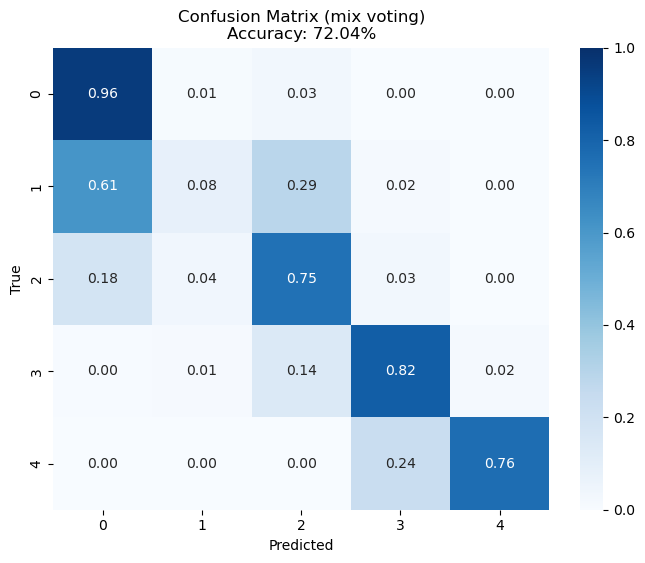

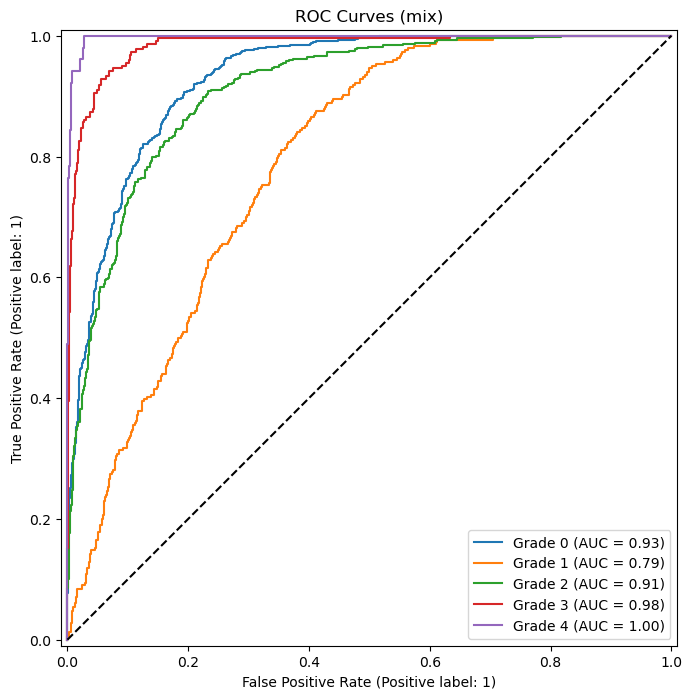

In [21]:
# 2. Generate Predictions
test_models(config.models_to_train)
# 3. Ensemble and Visualize
final_results = run_ensemble()
plot_results(final_results, mode='mix')

Loading ground truth labels...
Found 40 best models. Generating reports...

PERFORMANCE REPORT FOR: densenet_161 - 1fold_epoch30
Accuracy: 0.6727
F1 Macro: 0.6226

Classification Report:
              precision    recall  f1-score   support

           0     0.6906    0.8873    0.7767       639
           1     0.3448    0.0676    0.1130       296
           2     0.6070    0.7740    0.6804       447
           3     0.8974    0.6278    0.7388       223
           4     0.8039    0.8039    0.8039        51

    accuracy                         0.6727      1656
   macro avg     0.6688    0.6321    0.6226      1656
weighted avg     0.6376    0.6727    0.6278      1656



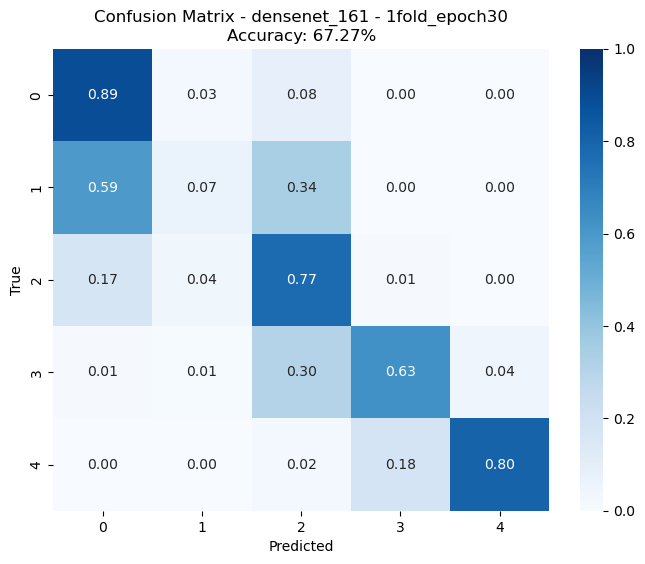

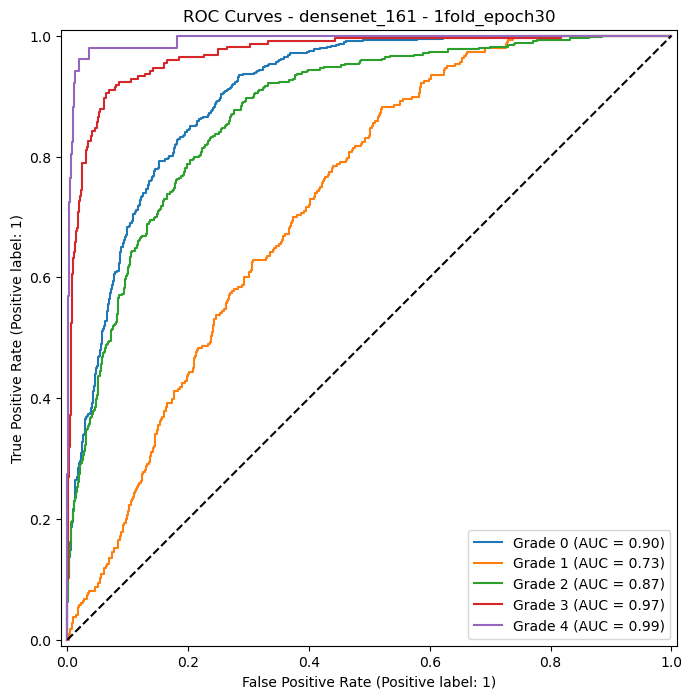


PERFORMANCE REPORT FOR: densenet_161 - 2fold_epoch30
Accuracy: 0.3829
F1 Macro: 0.1437

Classification Report:
              precision    recall  f1-score   support

           0     0.3960    0.9092    0.5518       639
           1     0.0000    0.0000    0.0000       296
           2     0.2804    0.1186    0.1667       447
           3     0.0000    0.0000    0.0000       223
           4     0.0000    0.0000    0.0000        51

    accuracy                         0.3829      1656
   macro avg     0.1353    0.2056    0.1437      1656
weighted avg     0.2285    0.3829    0.2579      1656



/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

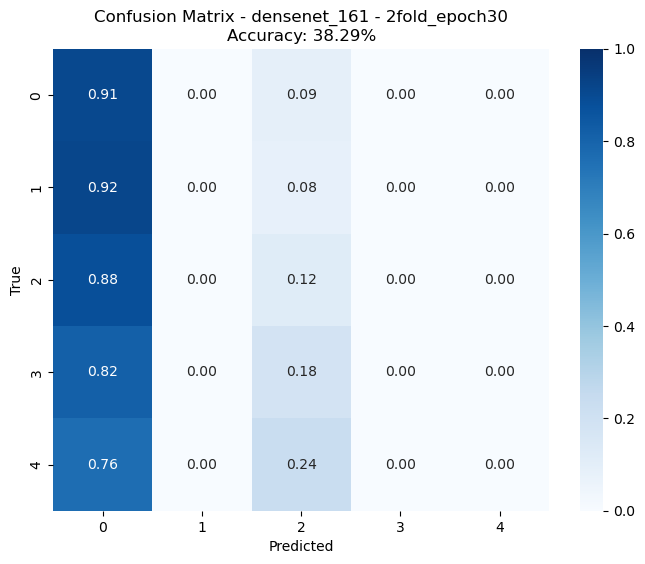

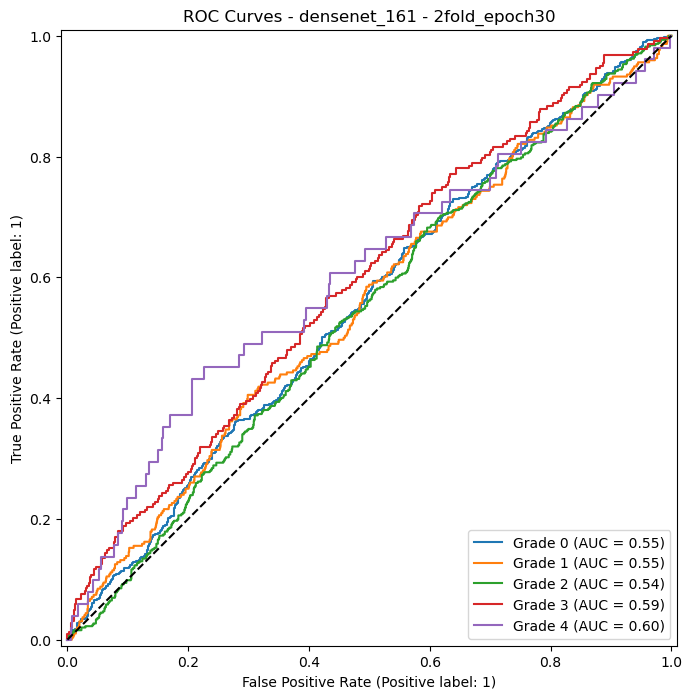


PERFORMANCE REPORT FOR: densenet_161 - 3fold_epoch30
Accuracy: 0.6691
F1 Macro: 0.6188

Classification Report:
              precision    recall  f1-score   support

           0     0.6918    0.9030    0.7834       639
           1     0.2576    0.0574    0.0939       296
           2     0.6299    0.6510    0.6403       447
           3     0.7650    0.8027    0.7834       223
           4     0.7333    0.8627    0.7928        51

    accuracy                         0.6691      1656
   macro avg     0.6155    0.6554    0.6188      1656
weighted avg     0.6086    0.6691    0.6218      1656



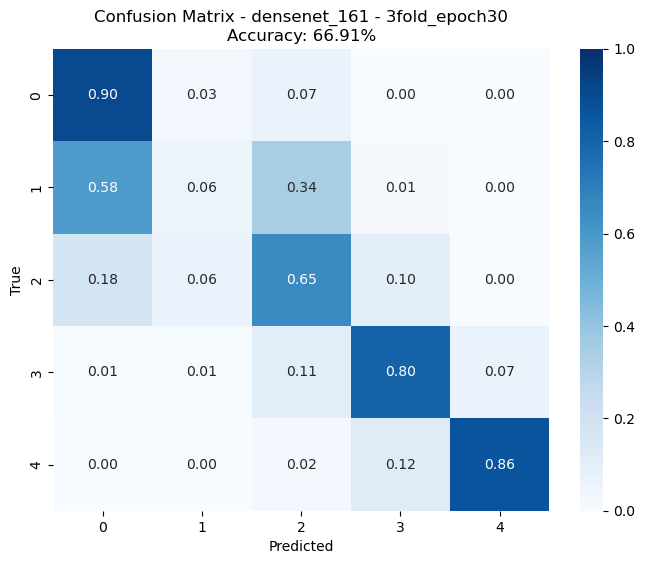

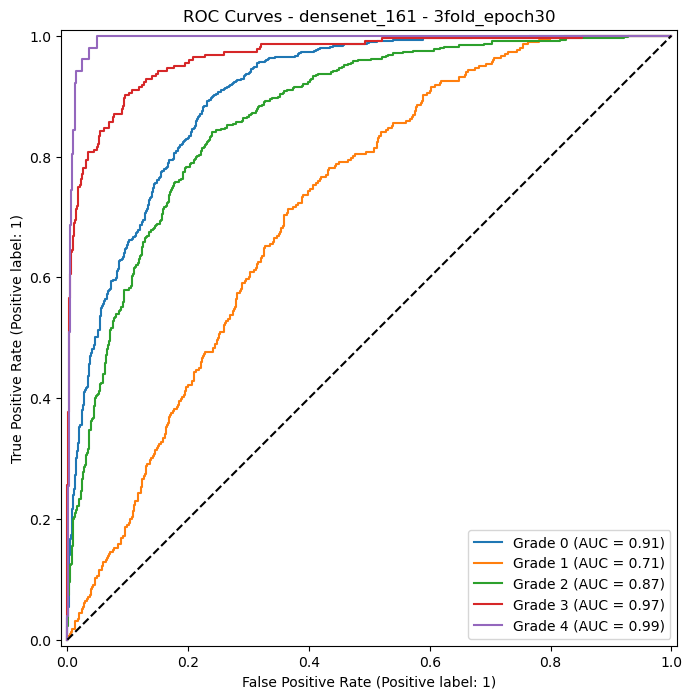


PERFORMANCE REPORT FOR: densenet_161 - 4fold_epoch30
Accuracy: 0.6636
F1 Macro: 0.5910

Classification Report:
              precision    recall  f1-score   support

           0     0.7164    0.8263    0.7674       639
           1     0.0000    0.0000    0.0000       296
           2     0.5455    0.8188    0.6547       447
           3     0.8093    0.7803    0.7945       223
           4     0.9394    0.6078    0.7381        51

    accuracy                         0.6636      1656
   macro avg     0.6021    0.6066    0.5910      1656
weighted avg     0.5616    0.6636    0.6026      1656



/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

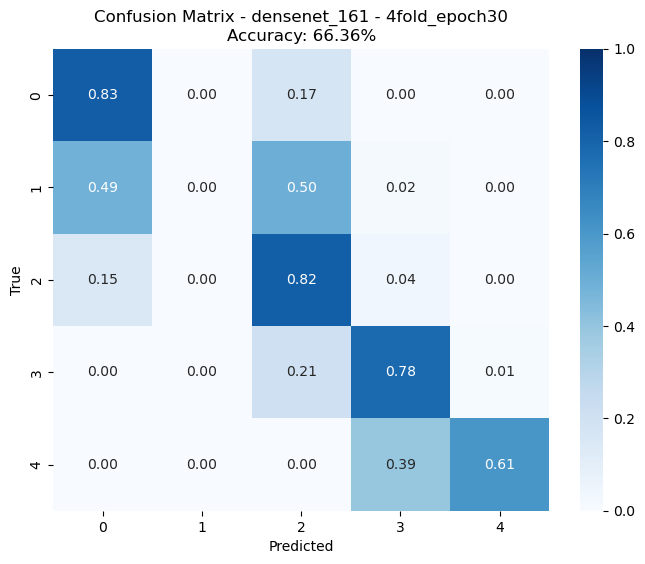

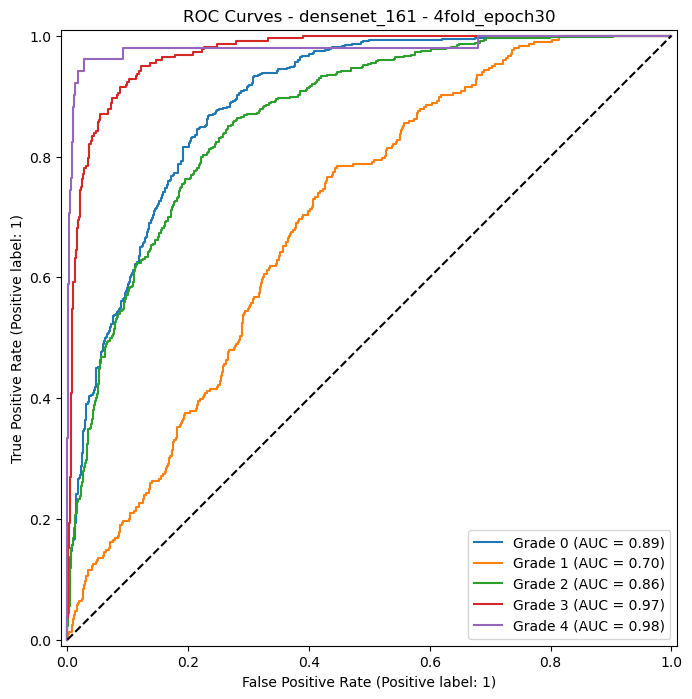


PERFORMANCE REPORT FOR: densenet_161 - 5fold_epoch30
Accuracy: 0.6594
F1 Macro: 0.6323

Classification Report:
              precision    recall  f1-score   support

           0     0.6971    0.8607    0.7703       639
           1     0.3228    0.1723    0.2247       296
           2     0.6675    0.6197    0.6427       447
           3     0.7063    0.7982    0.7495       223
           4     0.8571    0.7059    0.7742        51

    accuracy                         0.6594      1656
   macro avg     0.6502    0.6314    0.6323      1656
weighted avg     0.6284    0.6594    0.6356      1656



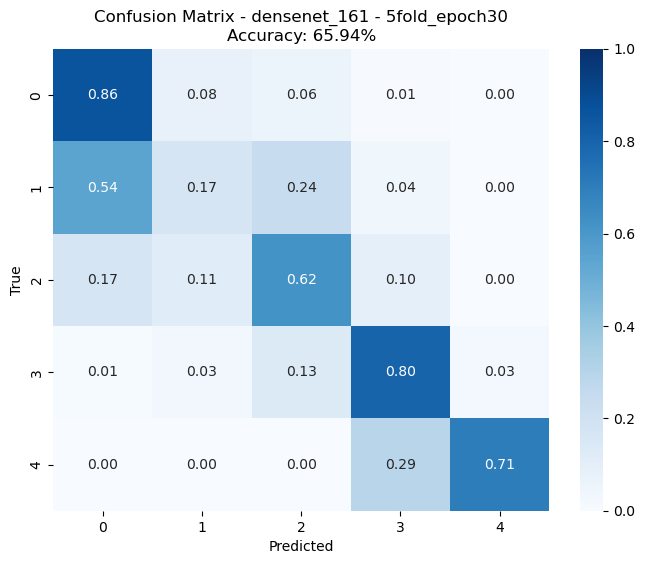

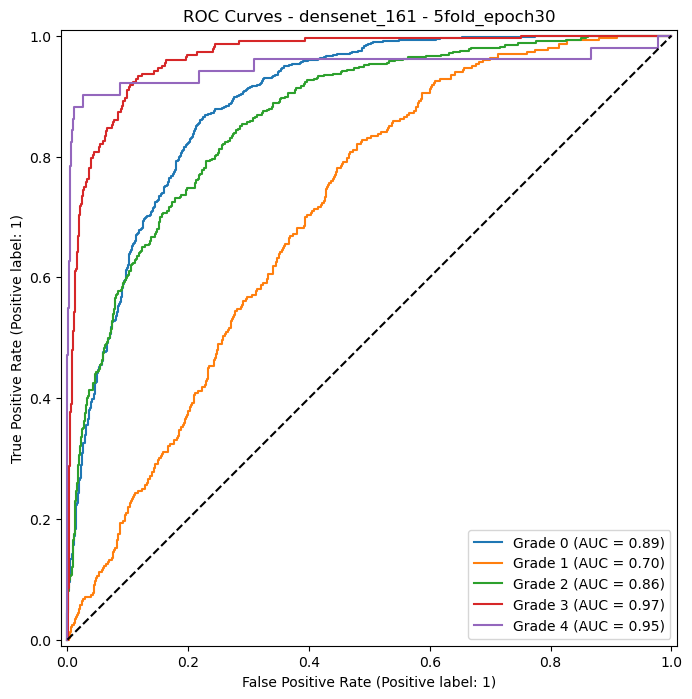


PERFORMANCE REPORT FOR: efficientnet_b5 - 1fold_epoch29
Accuracy: 0.6944
F1 Macro: 0.6694

Classification Report:
              precision    recall  f1-score   support

           0     0.6949    0.9374    0.7981       639
           1     0.3958    0.1926    0.2591       296
           2     0.7099    0.6242    0.6643       447
           3     0.8233    0.7937    0.8082       223
           4     0.9048    0.7451    0.8172        51

    accuracy                         0.6944      1656
   macro avg     0.7057    0.6586    0.6694      1656
weighted avg     0.6692    0.6944    0.6676      1656



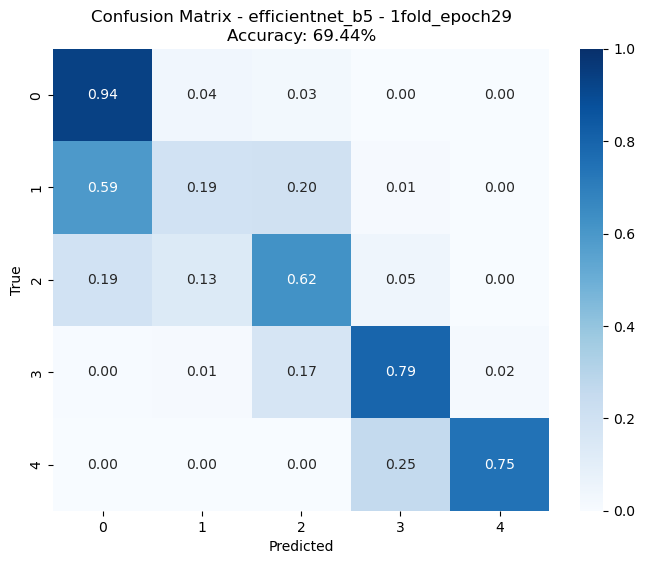

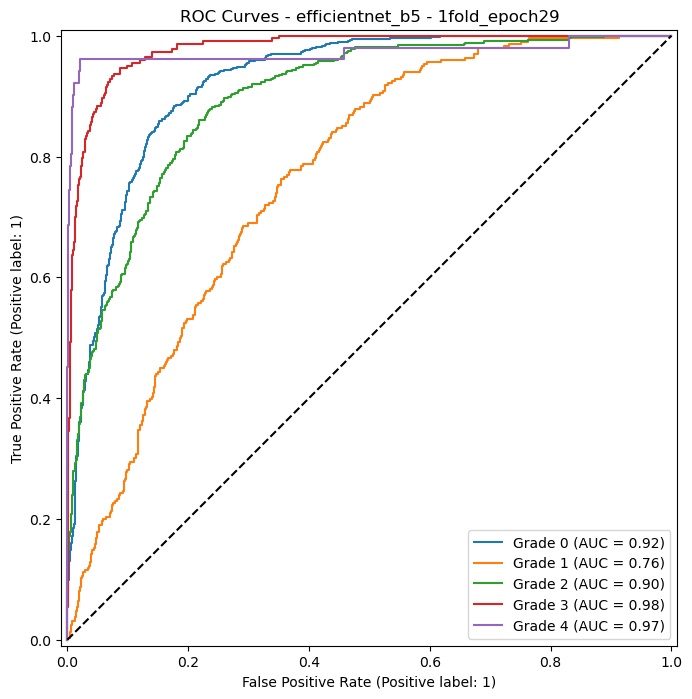


PERFORMANCE REPORT FOR: efficientnet_b5 - 2fold_epoch30
Accuracy: 0.6781
F1 Macro: 0.6707

Classification Report:
              precision    recall  f1-score   support

           0     0.6937    0.9249    0.7928       639
           1     0.3431    0.3176    0.3298       296
           2     0.8000    0.5101    0.6230       447
           3     0.8522    0.7758    0.8122       223
           4     0.8810    0.7255    0.7957        51

    accuracy                         0.6781      1656
   macro avg     0.7140    0.6508    0.6707      1656
weighted avg     0.6868    0.6781    0.6669      1656



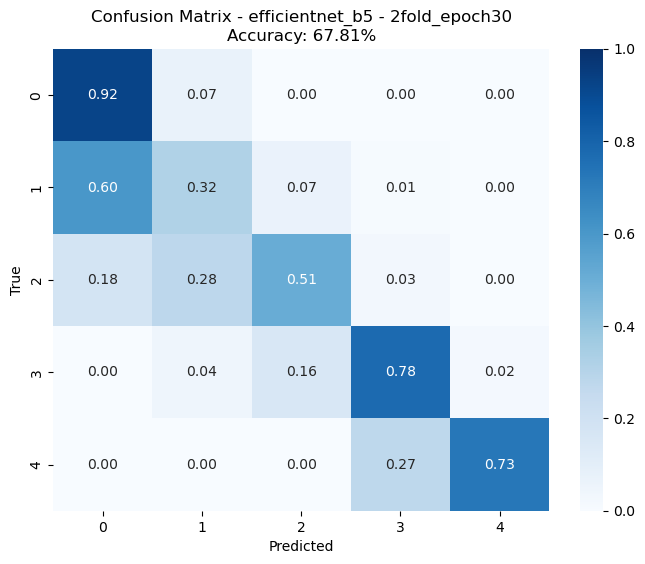

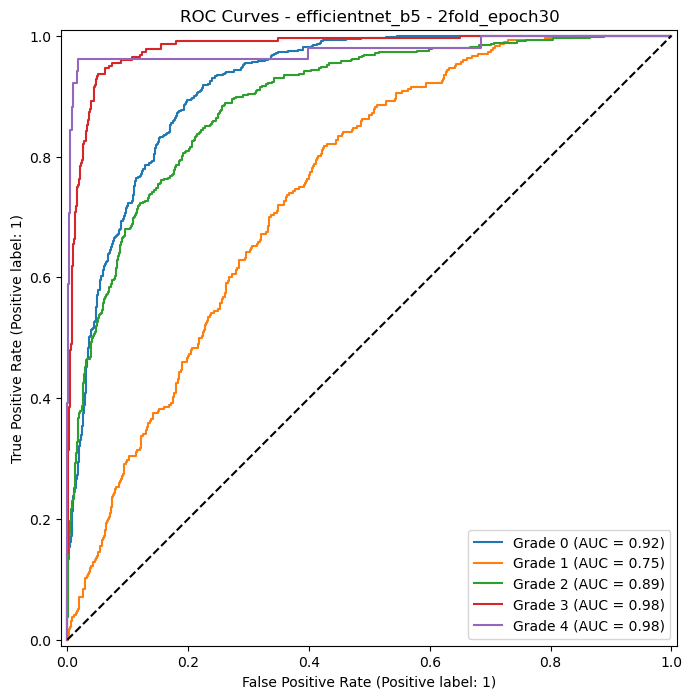


PERFORMANCE REPORT FOR: efficientnet_b5 - 3fold_epoch30
Accuracy: 0.7150
F1 Macro: 0.6860

Classification Report:
              precision    recall  f1-score   support

           0     0.7610    0.8920    0.8213       639
           1     0.4211    0.2162    0.2857       296
           2     0.6776    0.7427    0.7086       447
           3     0.8080    0.8117    0.8098       223
           4     0.9024    0.7255    0.8043        51

    accuracy                         0.7150      1656
   macro avg     0.7140    0.6776    0.6860      1656
weighted avg     0.6884    0.7150    0.6931      1656



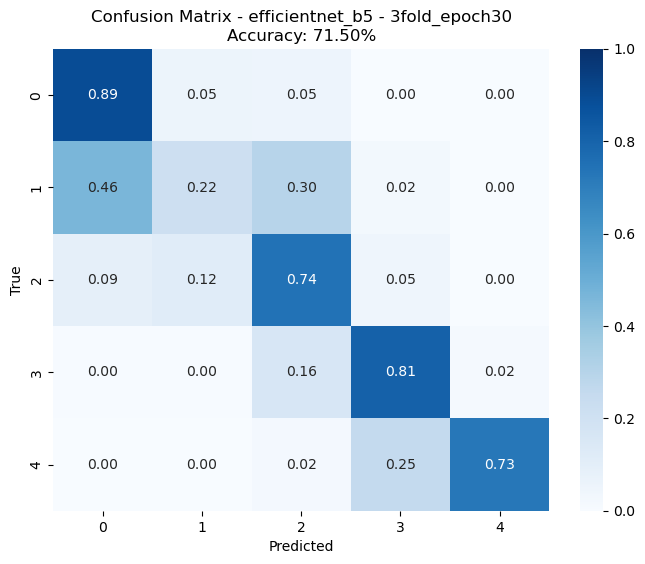

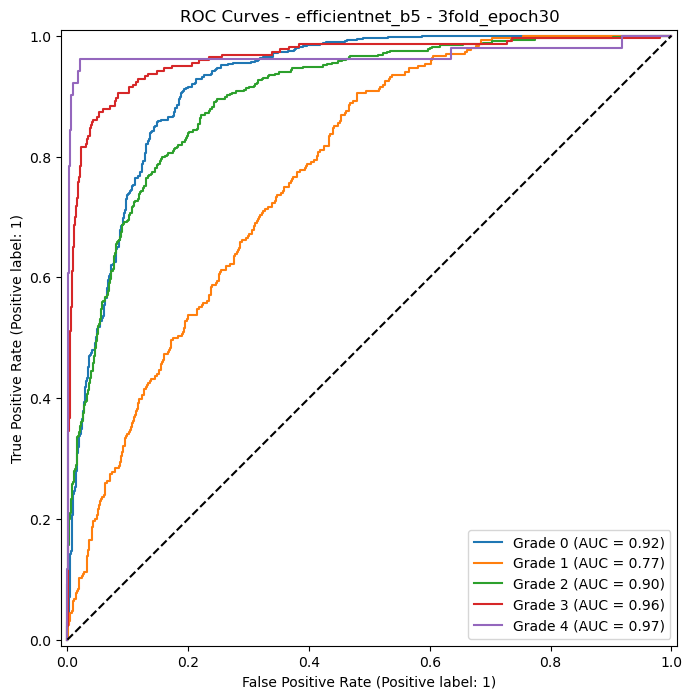


PERFORMANCE REPORT FOR: efficientnet_b5 - 4fold_epoch30
Accuracy: 0.6848
F1 Macro: 0.6637

Classification Report:
              precision    recall  f1-score   support

           0     0.7994    0.7981    0.7987       639
           1     0.4027    0.2027    0.2697       296
           2     0.6504    0.7159    0.6816       447
           3     0.6145    0.9148    0.7351       223
           4     0.8889    0.7843    0.8333        51

    accuracy                         0.6848      1656
   macro avg     0.6712    0.6832    0.6637      1656
weighted avg     0.6661    0.6848    0.6650      1656



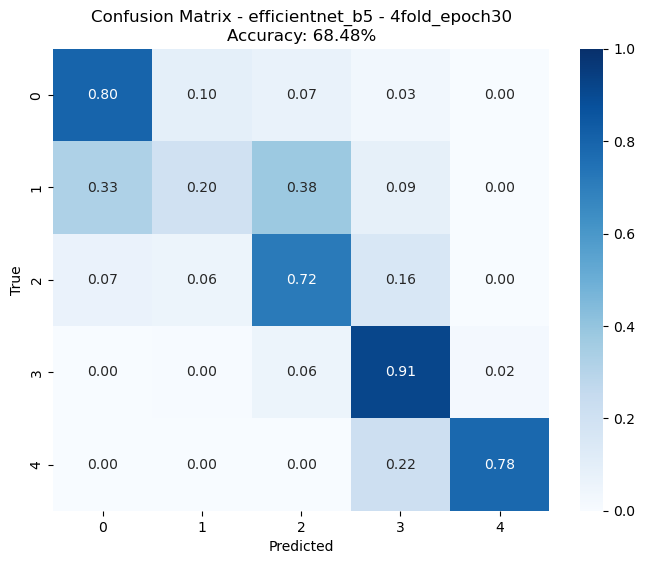

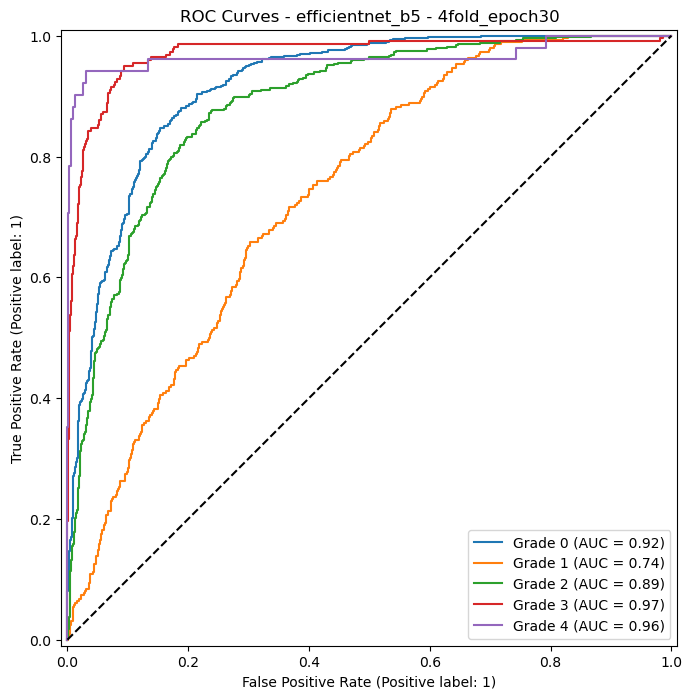


PERFORMANCE REPORT FOR: efficientnet_b5 - 5fold_epoch30
Accuracy: 0.7077
F1 Macro: 0.6699

Classification Report:
              precision    recall  f1-score   support

           0     0.7148    0.9218    0.8052       639
           1     0.4245    0.1520    0.2239       296
           2     0.6932    0.7025    0.6978       447
           3     0.8034    0.8430    0.8228       223
           4     0.9231    0.7059    0.8000        51

    accuracy                         0.7077      1656
   macro avg     0.7118    0.6650    0.6699      1656
weighted avg     0.6754    0.7077    0.6745      1656



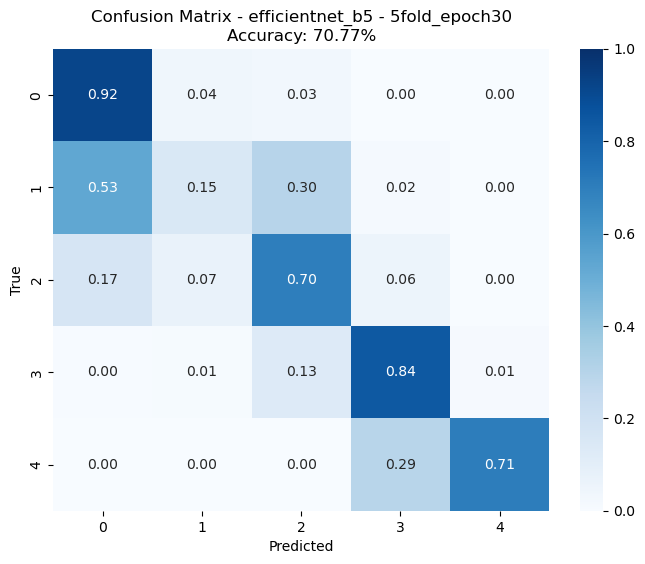

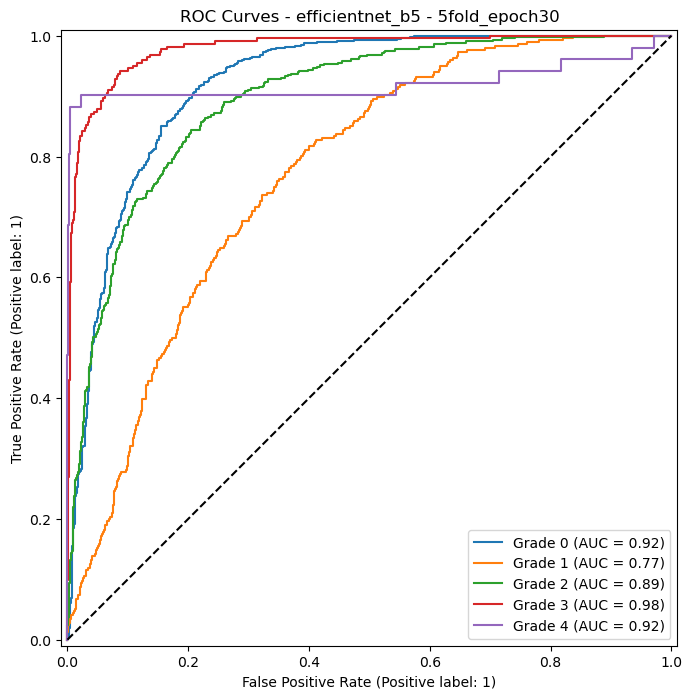


PERFORMANCE REPORT FOR: efficientnet_v2_s - 1fold_epoch30
Accuracy: 0.6739
F1 Macro: 0.6808

Classification Report:
              precision    recall  f1-score   support

           0     0.7109    0.8889    0.7900       639
           1     0.3595    0.4020    0.3796       296
           2     0.7762    0.4810    0.5939       447
           3     0.8687    0.7713    0.8171       223
           4     0.8235    0.8235    0.8235        51

    accuracy                         0.6739      1656
   macro avg     0.7078    0.6733    0.6808      1656
weighted avg     0.6904    0.6739    0.6684      1656



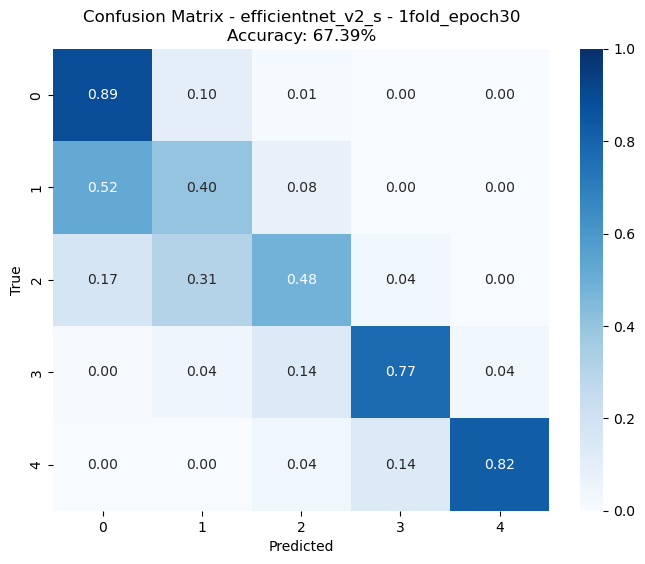

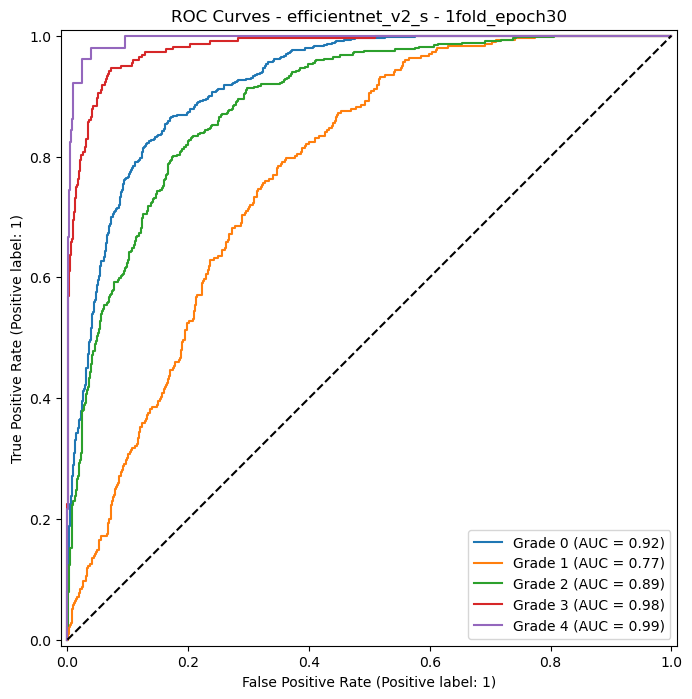


PERFORMANCE REPORT FOR: efficientnet_v2_s - 2fold_epoch30
Accuracy: 0.7107
F1 Macro: 0.6779

Classification Report:
              precision    recall  f1-score   support

           0     0.7411    0.8826    0.8057       639
           1     0.4180    0.1723    0.2440       296
           2     0.6735    0.7383    0.7044       447
           3     0.8008    0.8834    0.8401       223
           4     0.9459    0.6863    0.7955        51

    accuracy                         0.7107      1656
   macro avg     0.7159    0.6726    0.6779      1656
weighted avg     0.6795    0.7107    0.6823      1656



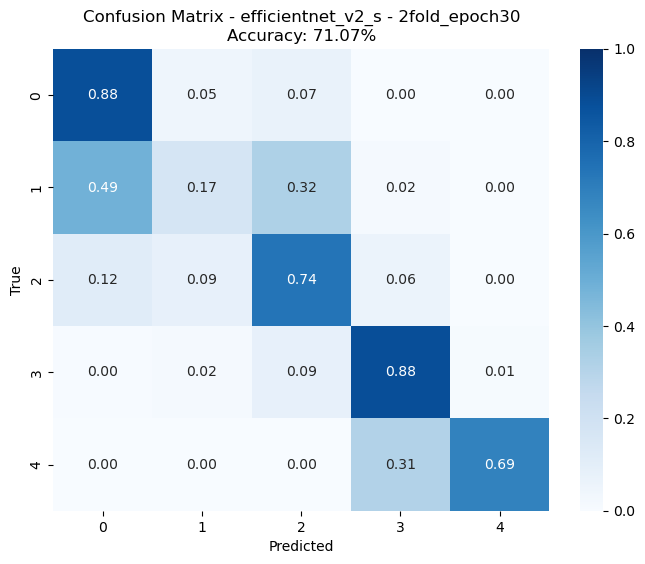

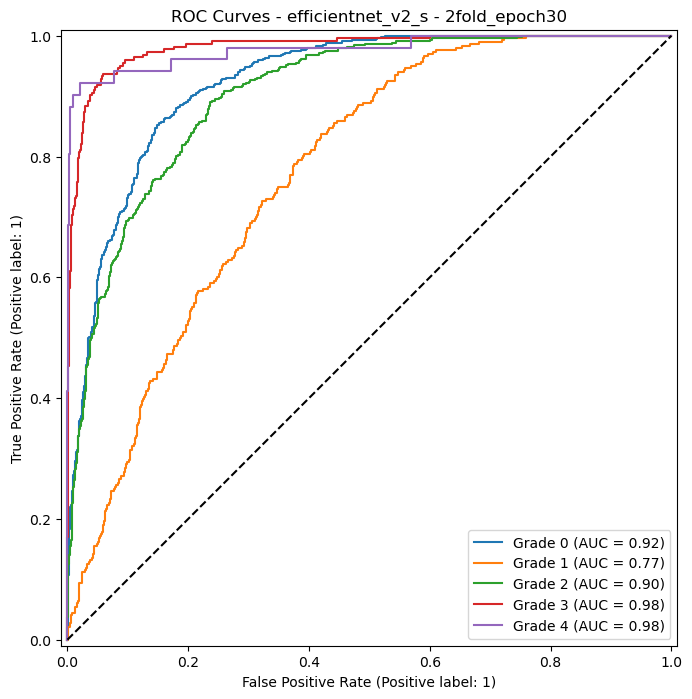


PERFORMANCE REPORT FOR: efficientnet_v2_s - 3fold_epoch30
Accuracy: 0.6993
F1 Macro: 0.6882

Classification Report:
              precision    recall  f1-score   support

           0     0.6881    0.9358    0.7931       639
           1     0.4593    0.3243    0.3802       296
           2     0.8298    0.5235    0.6420       447
           3     0.7750    0.8341    0.8035       223
           4     0.7857    0.8627    0.8224        51

    accuracy                         0.6993      1656
   macro avg     0.7076    0.6961    0.6882      1656
weighted avg     0.7002    0.6993    0.6808      1656



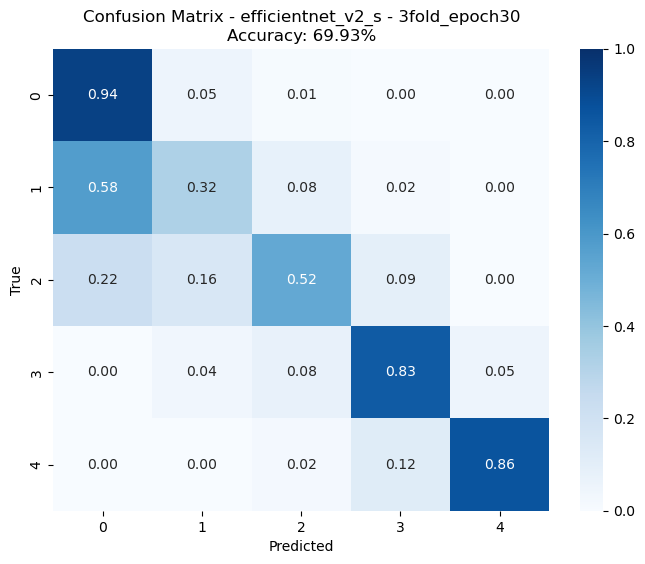

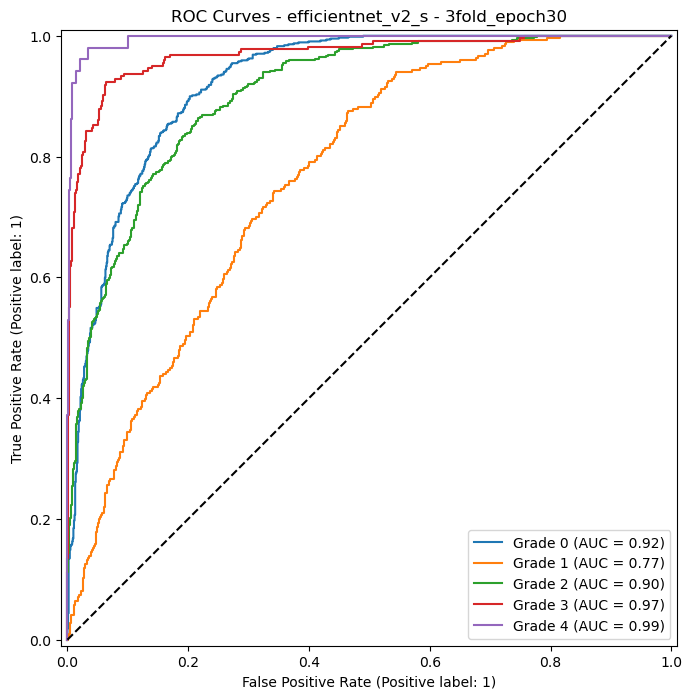


PERFORMANCE REPORT FOR: efficientnet_v2_s - 4fold_epoch30
Accuracy: 0.6781
F1 Macro: 0.6564

Classification Report:
              precision    recall  f1-score   support

           0     0.6566    0.9484    0.7759       639
           1     0.3374    0.1858    0.2397       296
           2     0.7642    0.5727    0.6547       447
           3     0.8925    0.7444    0.8117       223
           4     0.8163    0.7843    0.8000        51

    accuracy                         0.6781      1656
   macro avg     0.6934    0.6471    0.6564      1656
weighted avg     0.6653    0.6781    0.6529      1656



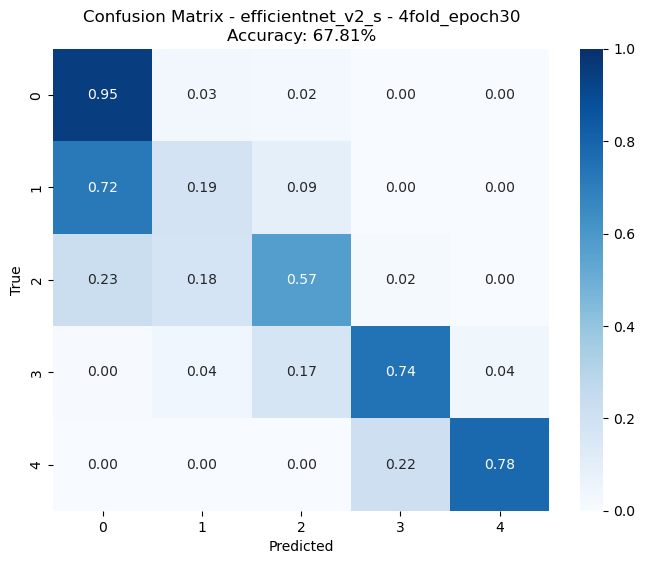

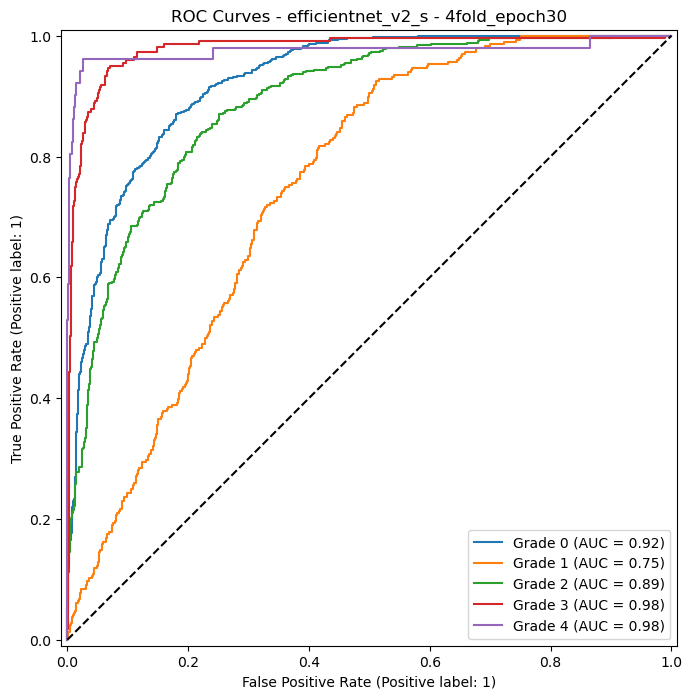


PERFORMANCE REPORT FOR: efficientnet_v2_s - 5fold_epoch30
Accuracy: 0.6691
F1 Macro: 0.6483

Classification Report:
              precision    recall  f1-score   support

           0     0.7018    0.9171    0.7951       639
           1     0.3762    0.2568    0.3052       296
           2     0.7429    0.4653    0.5722       447
           3     0.6815    0.8924    0.7728       223
           4     0.8298    0.7647    0.7959        51

    accuracy                         0.6691      1656
   macro avg     0.6664    0.6592    0.6483      1656
weighted avg     0.6559    0.6691    0.6444      1656



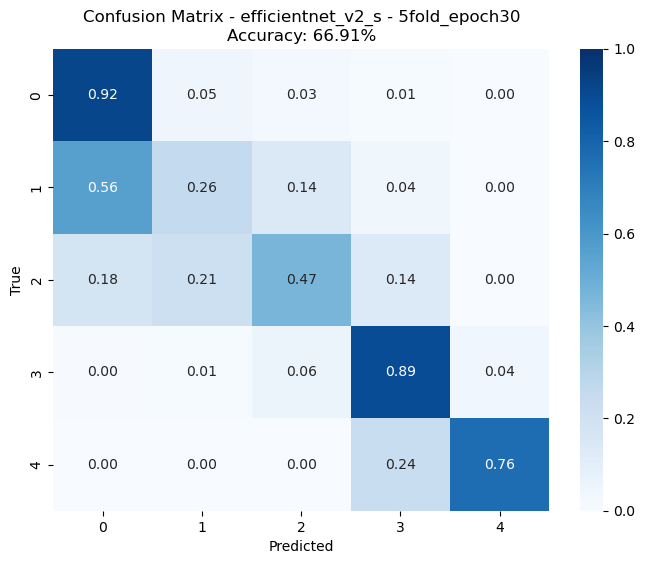

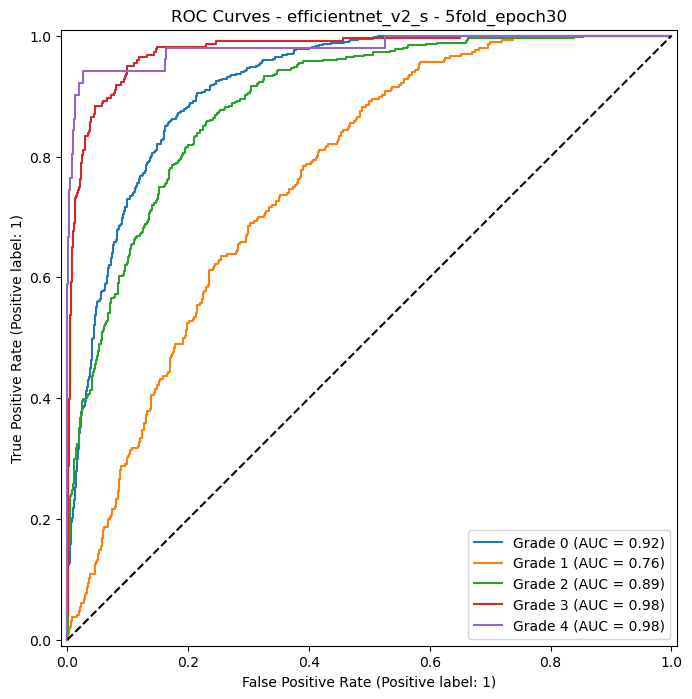


PERFORMANCE REPORT FOR: regnet_y_8gf - 1fold_epoch30
Accuracy: 0.6830
F1 Macro: 0.6384

Classification Report:
              precision    recall  f1-score   support

           0     0.6809    0.9452    0.7916       639
           1     0.3592    0.1250    0.1855       296
           2     0.6731    0.6264    0.6489       447
           3     0.8174    0.8027    0.8100       223
           4     1.0000    0.6078    0.7561        51

    accuracy                         0.6830      1656
   macro avg     0.7061    0.6214    0.6384      1656
weighted avg     0.6495    0.6830    0.6461      1656



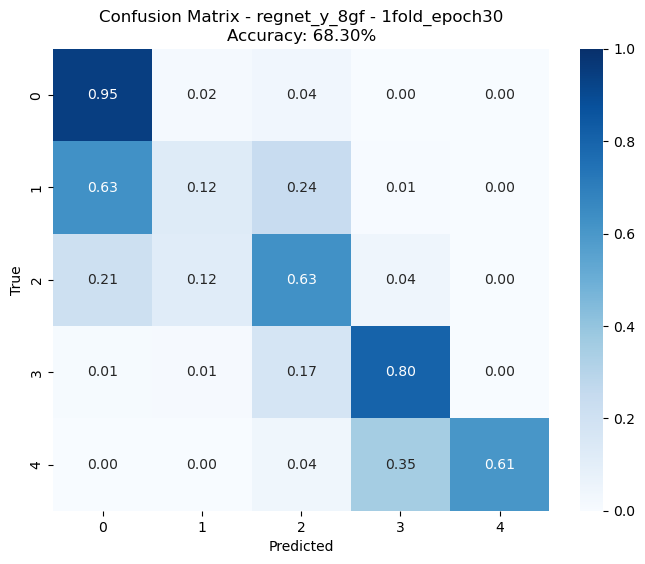

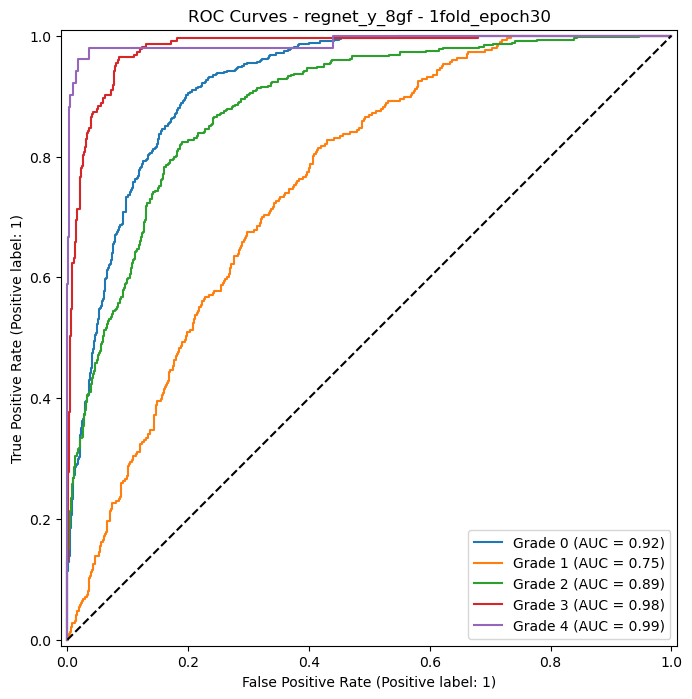


PERFORMANCE REPORT FOR: regnet_y_8gf - 2fold_epoch30
Accuracy: 0.6606
F1 Macro: 0.6209

Classification Report:
              precision    recall  f1-score   support

           0     0.6162    0.9875    0.7589       639
           1     0.2841    0.0845    0.1302       296
           2     0.8394    0.4676    0.6006       447
           3     0.7750    0.8341    0.8035       223
           4     0.7818    0.8431    0.8113        51

    accuracy                         0.6606      1656
   macro avg     0.6593    0.6433    0.6209      1656
weighted avg     0.6436    0.6606    0.6114      1656



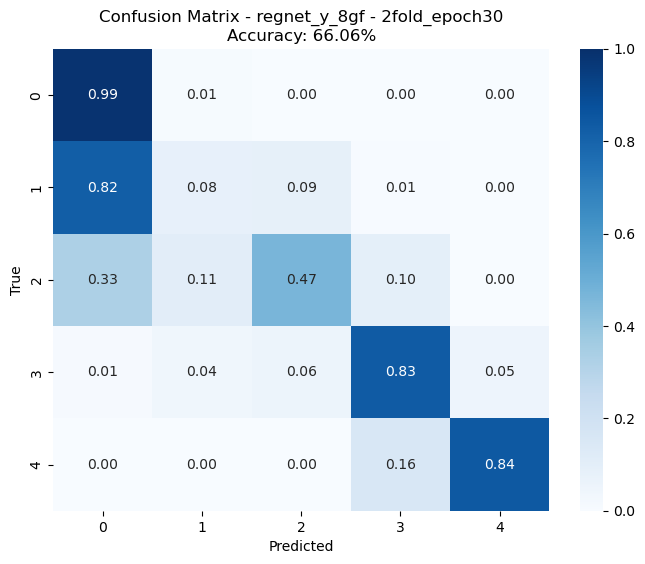

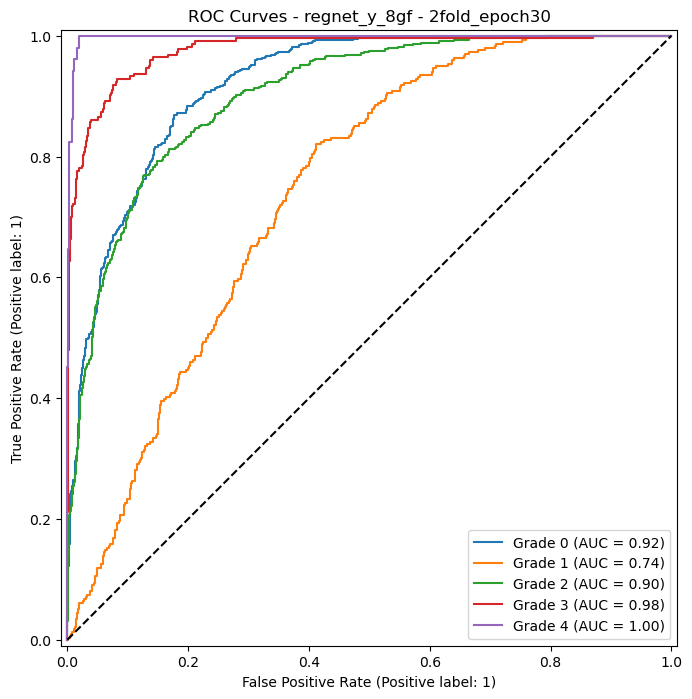


PERFORMANCE REPORT FOR: regnet_y_8gf - 3fold_epoch30
Accuracy: 0.7041
F1 Macro: 0.6866

Classification Report:
              precision    recall  f1-score   support

           0     0.6895    0.9280    0.7912       639
           1     0.3986    0.1993    0.2658       296
           2     0.7414    0.6734    0.7057       447
           3     0.9027    0.7489    0.8186       223
           4     0.8070    0.9020    0.8519        51

    accuracy                         0.7041      1656
   macro avg     0.7079    0.6903    0.6866      1656
weighted avg     0.6839    0.7041    0.6798      1656



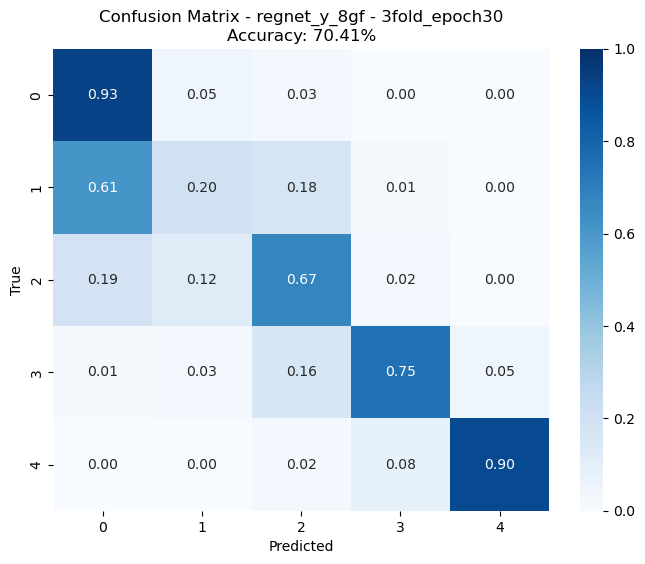

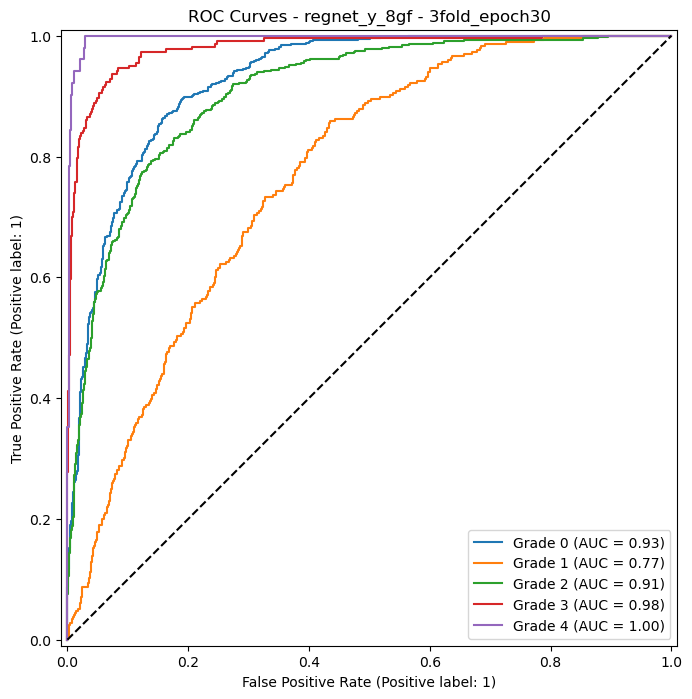


PERFORMANCE REPORT FOR: regnet_y_8gf - 4fold_epoch30
Accuracy: 0.6836
F1 Macro: 0.6560

Classification Report:
              precision    recall  f1-score   support

           0     0.6584    0.9499    0.7777       639
           1     0.3295    0.0980    0.1510       296
           2     0.6962    0.6510    0.6728       447
           3     0.9186    0.7085    0.8000       223
           4     0.8393    0.9216    0.8785        51

    accuracy                         0.6836      1656
   macro avg     0.6884    0.6658    0.6560      1656
weighted avg     0.6504    0.6836    0.6435      1656



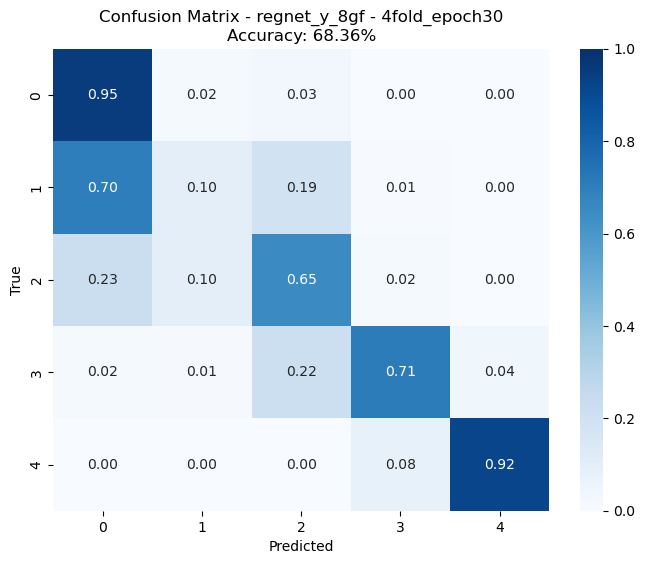

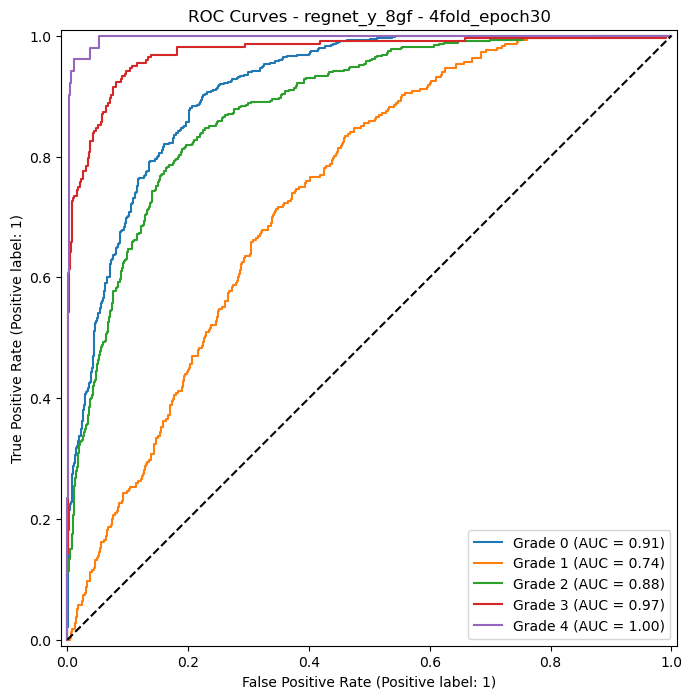


PERFORMANCE REPORT FOR: regnet_y_8gf - 5fold_epoch30
Accuracy: 0.6957
F1 Macro: 0.6622

Classification Report:
              precision    recall  f1-score   support

           0     0.6905    0.9218    0.7895       639
           1     0.4300    0.1453    0.2172       296
           2     0.6760    0.7562    0.7138       447
           3     0.9375    0.6054    0.7357       223
           4     0.7966    0.9216    0.8545        51

    accuracy                         0.6957      1656
   macro avg     0.7061    0.6700    0.6622      1656
weighted avg     0.6766    0.6957    0.6615      1656



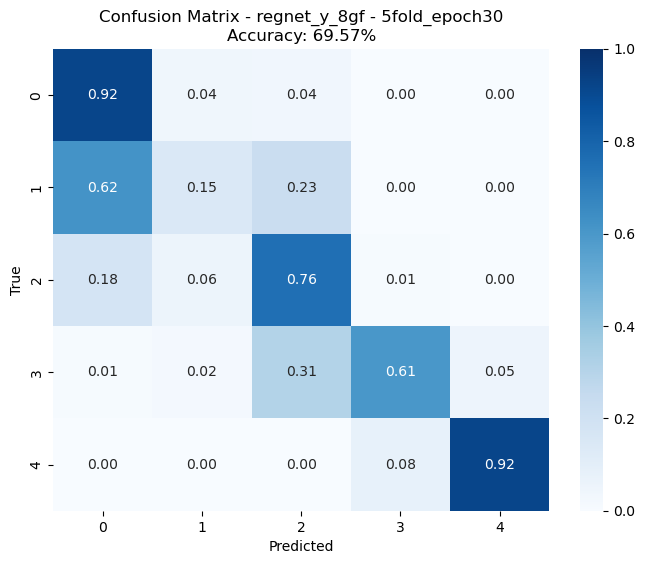

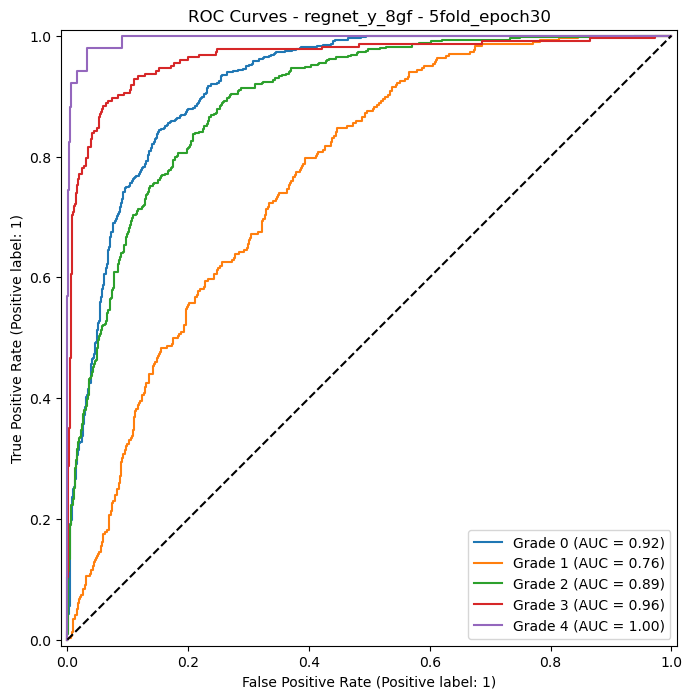


PERFORMANCE REPORT FOR: resnet_101 - 1fold_epoch29
Accuracy: 0.6745
F1 Macro: 0.6142

Classification Report:
              precision    recall  f1-score   support

           0     0.7662    0.8153    0.7900       639
           1     0.3895    0.1250    0.1893       296
           2     0.5737    0.8098    0.6716       447
           3     0.7738    0.7668    0.7703       223
           4     0.8966    0.5098    0.6500        51

    accuracy                         0.6745      1656
   macro avg     0.6799    0.6054    0.6142      1656
weighted avg     0.6519    0.6745    0.6437      1656



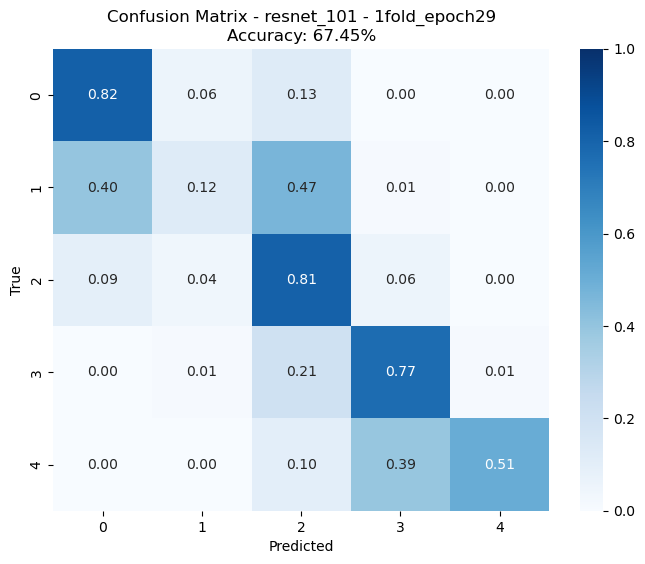

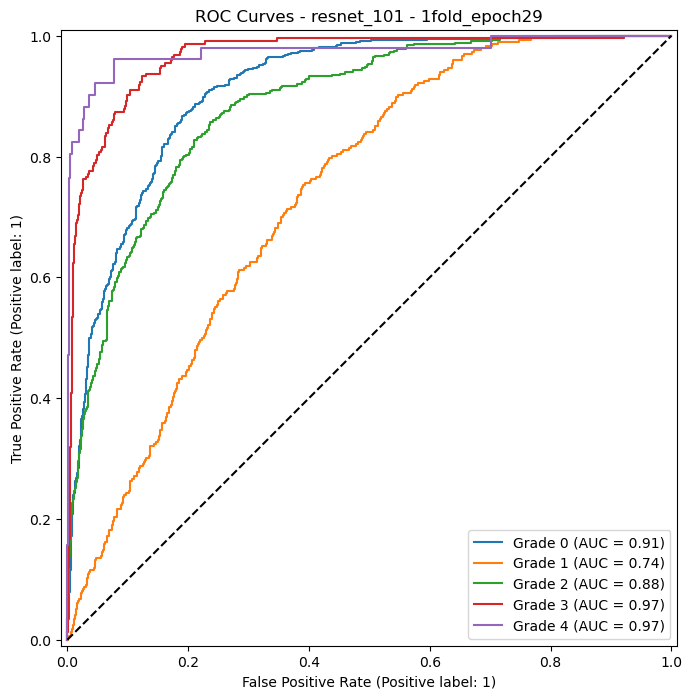


PERFORMANCE REPORT FOR: resnet_101 - 2fold_epoch30
Accuracy: 0.6902
F1 Macro: 0.6504

Classification Report:
              precision    recall  f1-score   support

           0     0.7192    0.8858    0.7938       639
           1     0.4388    0.1453    0.2183       296
           2     0.6580    0.6756    0.6667       447
           3     0.7276    0.8744    0.7943       223
           4     0.8409    0.7255    0.7789        51

    accuracy                         0.6902      1656
   macro avg     0.6769    0.6613    0.6504      1656
weighted avg     0.6574    0.6902    0.6562      1656



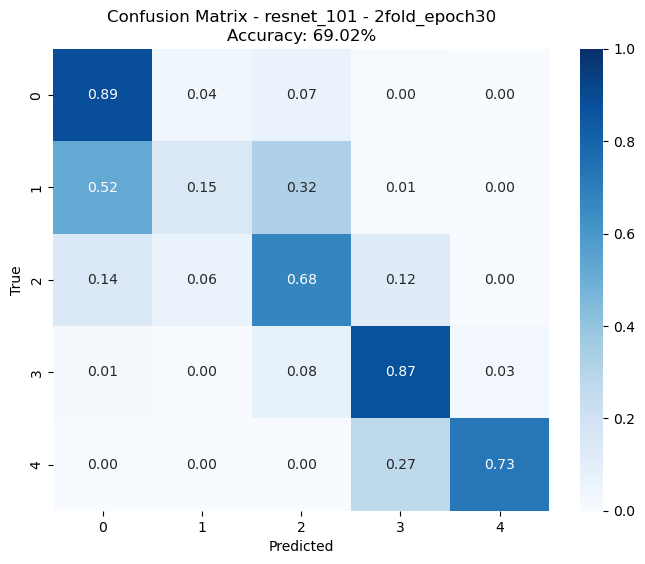

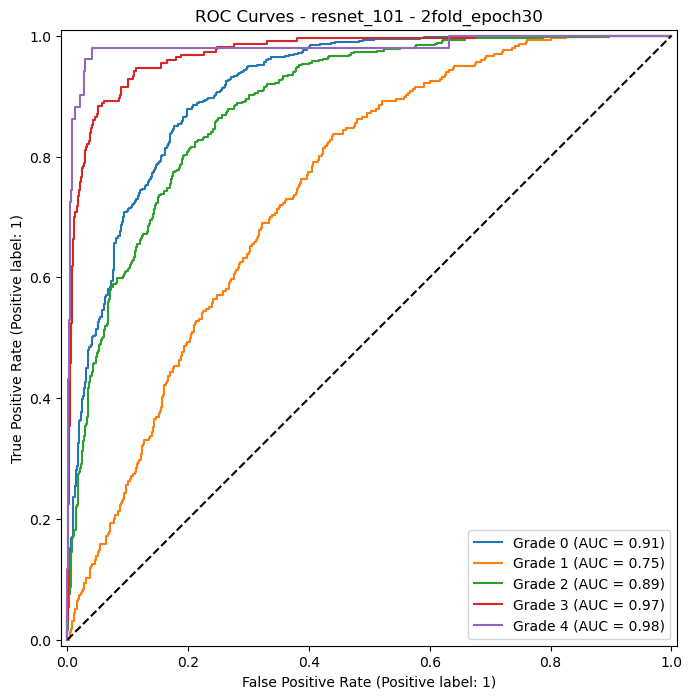


PERFORMANCE REPORT FOR: resnet_101 - 3fold_epoch30
Accuracy: 0.6715
F1 Macro: 0.6311

Classification Report:
              precision    recall  f1-score   support

           0     0.6542    0.9327    0.7690       639
           1     0.3117    0.0811    0.1287       296
           2     0.7053    0.5996    0.6481       447
           3     0.7635    0.8251    0.7931       223
           4     0.8511    0.7843    0.8163        51

    accuracy                         0.6715      1656
   macro avg     0.6571    0.6446    0.6311      1656
weighted avg     0.6276    0.6715    0.6266      1656



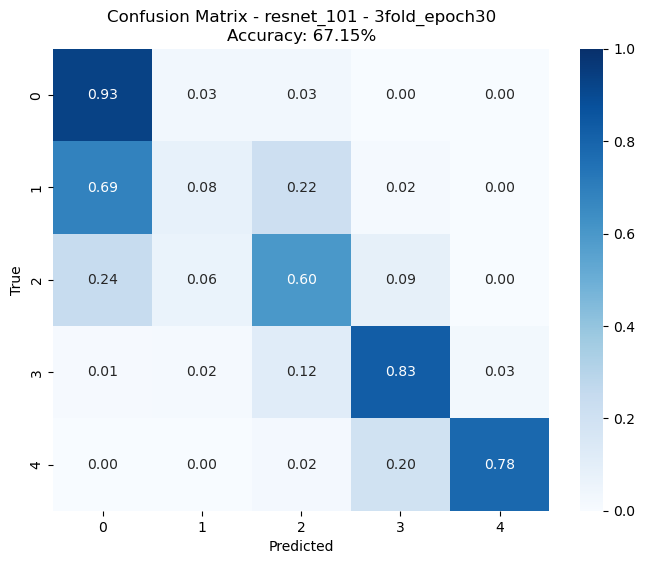

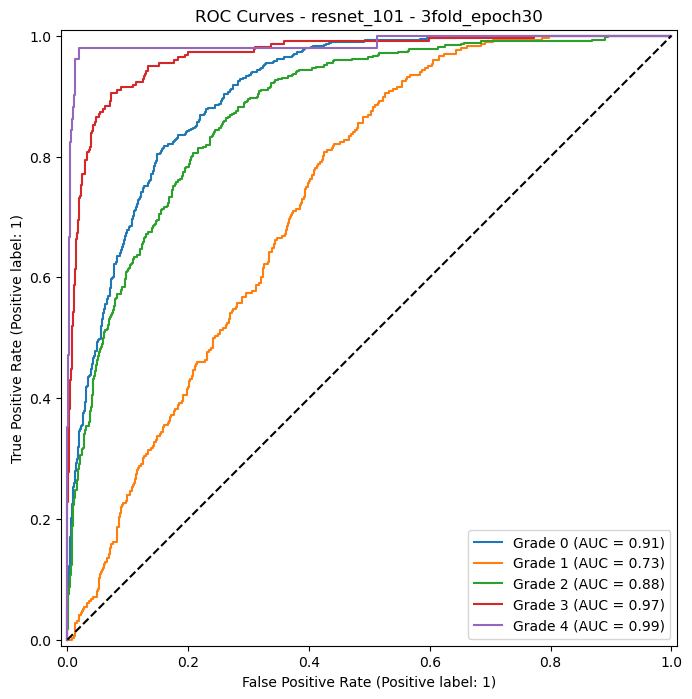


PERFORMANCE REPORT FOR: resnet_101 - 4fold_epoch29
Accuracy: 0.6866
F1 Macro: 0.6256

Classification Report:
              precision    recall  f1-score   support

           0     0.6957    0.9014    0.7853       639
           1     0.7273    0.0270    0.0521       296
           2     0.6041    0.7919    0.6854       447
           3     0.8764    0.6996    0.7781       223
           4     0.8113    0.8431    0.8269        51

    accuracy                         0.6866      1656
   macro avg     0.7429    0.6526    0.6256      1656
weighted avg     0.7045    0.6866    0.6276      1656



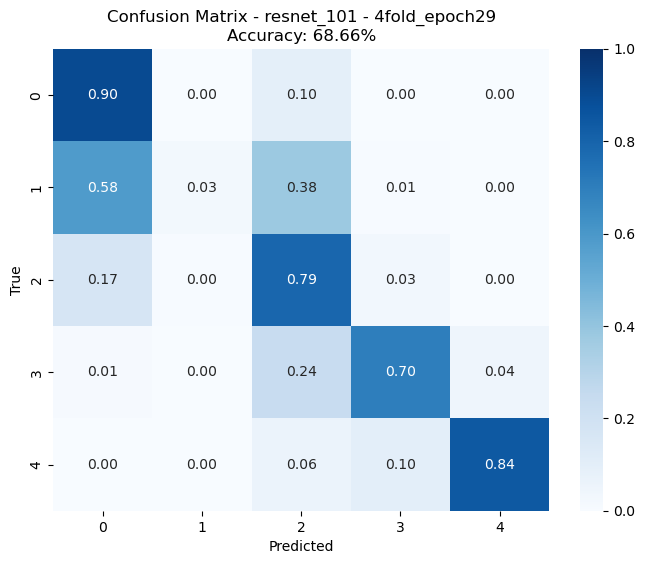

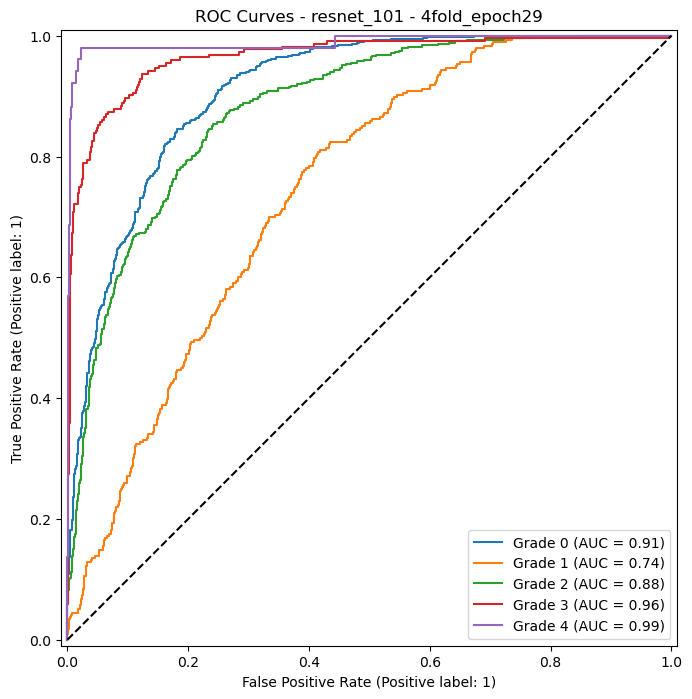


PERFORMANCE REPORT FOR: resnet_101 - 5fold_epoch30
Accuracy: 0.6902
F1 Macro: 0.6438

Classification Report:
              precision    recall  f1-score   support

           0     0.7397    0.8717    0.8003       639
           1     0.4083    0.2331    0.2968       296
           2     0.6523    0.7472    0.6966       447
           3     0.8158    0.6951    0.7506       223
           4     0.8750    0.5490    0.6747        51

    accuracy                         0.6902      1656
   macro avg     0.6982    0.6192    0.6438      1656
weighted avg     0.6713    0.6902    0.6717      1656



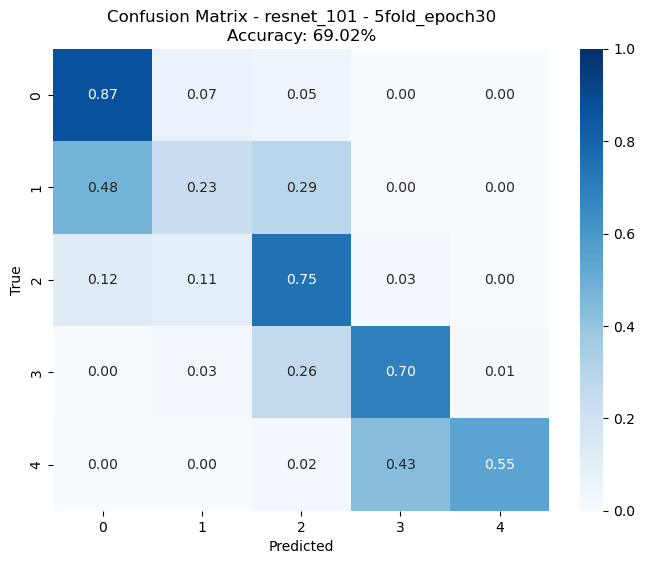

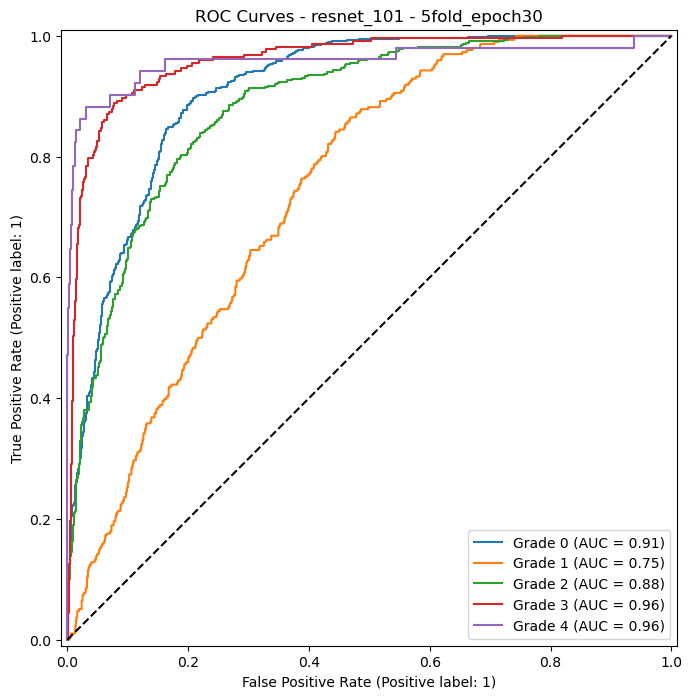


PERFORMANCE REPORT FOR: resnext_50_32x4d - 1fold_epoch30
Accuracy: 0.6872
F1 Macro: 0.6322

Classification Report:
              precision    recall  f1-score   support

           0     0.6987    0.9327    0.7989       639
           1     0.4082    0.2027    0.2709       296
           2     0.6966    0.6421    0.6682       447
           3     0.7925    0.7534    0.7724       223
           4     0.8438    0.5294    0.6506        51

    accuracy                         0.6872      1656
   macro avg     0.6879    0.6120    0.6322      1656
weighted avg     0.6633    0.6872    0.6611      1656



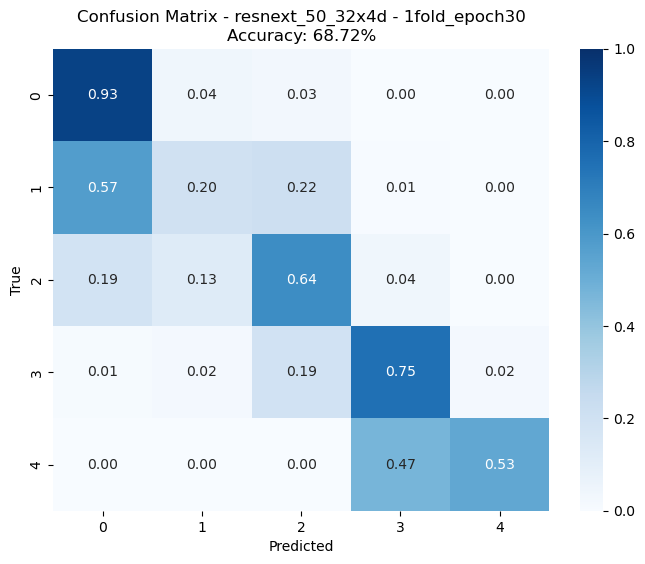

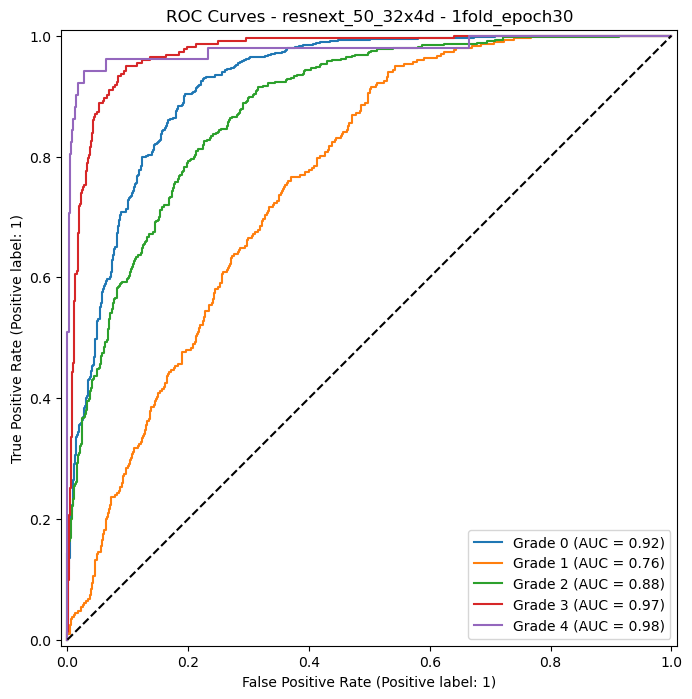


PERFORMANCE REPORT FOR: resnext_50_32x4d - 2fold_epoch30
Accuracy: 0.6932
F1 Macro: 0.6669

Classification Report:
              precision    recall  f1-score   support

           0     0.7026    0.9171    0.7957       639
           1     0.3904    0.1926    0.2579       296
           2     0.6836    0.6913    0.6874       447
           3     0.8771    0.7040    0.7811       223
           4     0.8667    0.7647    0.8125        51

    accuracy                         0.6932      1656
   macro avg     0.7041    0.6539    0.6669      1656
weighted avg     0.6702    0.6932    0.6689      1656



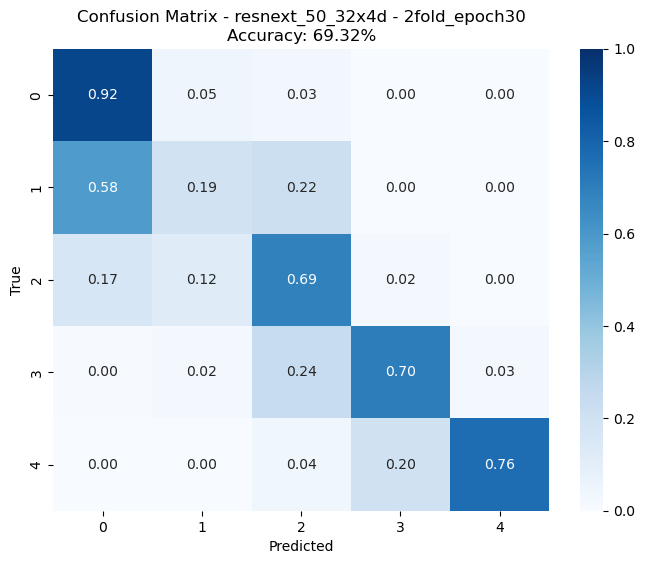

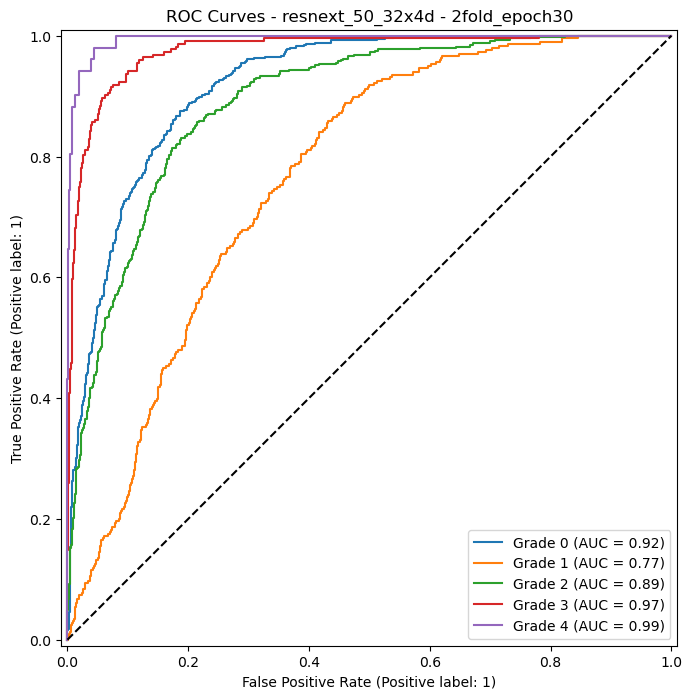


PERFORMANCE REPORT FOR: resnext_50_32x4d - 3fold_epoch30
Accuracy: 0.6890
F1 Macro: 0.6650

Classification Report:
              precision    recall  f1-score   support

           0     0.7845    0.8263    0.8049       639
           1     0.4136    0.2264    0.2926       296
           2     0.6321    0.7226    0.6743       447
           3     0.6996    0.8251    0.7572       223
           4     0.8298    0.7647    0.7959        51

    accuracy                         0.6890      1656
   macro avg     0.6719    0.6730    0.6650      1656
weighted avg     0.6670    0.6890    0.6714      1656



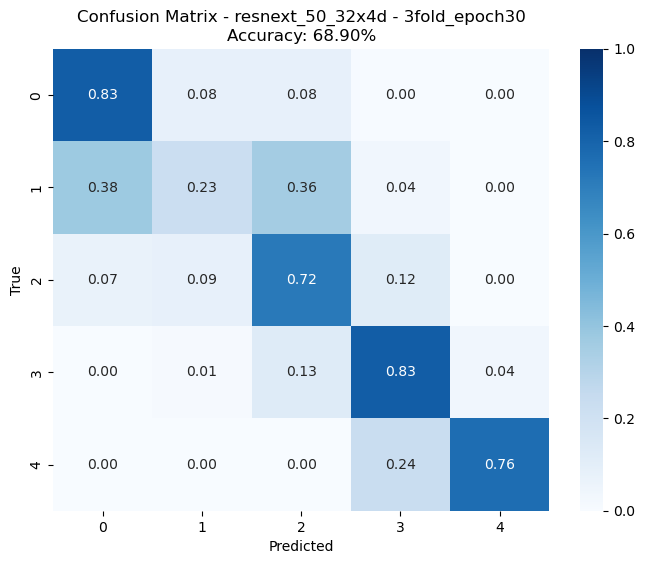

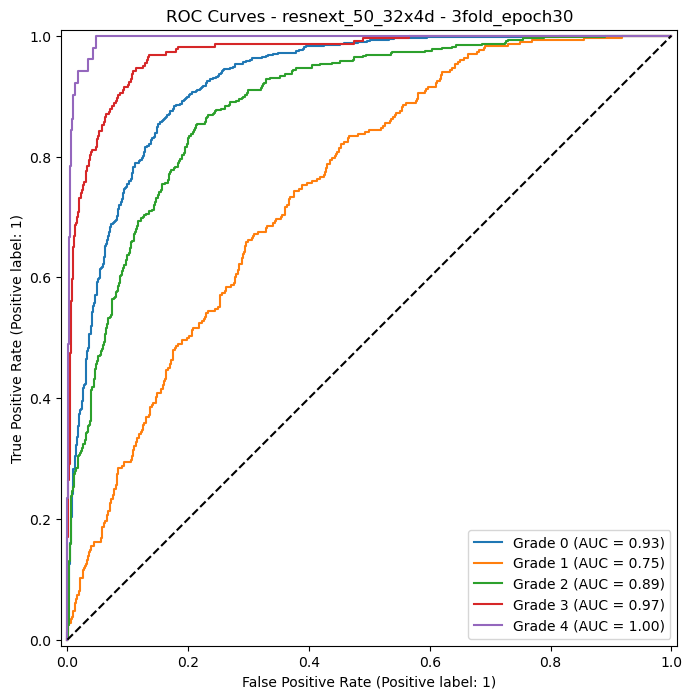


PERFORMANCE REPORT FOR: resnext_50_32x4d - 4fold_epoch30
Accuracy: 0.6636
F1 Macro: 0.6564

Classification Report:
              precision    recall  f1-score   support

           0     0.7930    0.7496    0.7707       639
           1     0.3704    0.3378    0.3534       296
           2     0.6319    0.6913    0.6603       447
           3     0.6969    0.7937    0.7421       223
           4     0.8718    0.6667    0.7556        51

    accuracy                         0.6636      1656
   macro avg     0.6728    0.6478    0.6564      1656
weighted avg     0.6635    0.6636    0.6620      1656



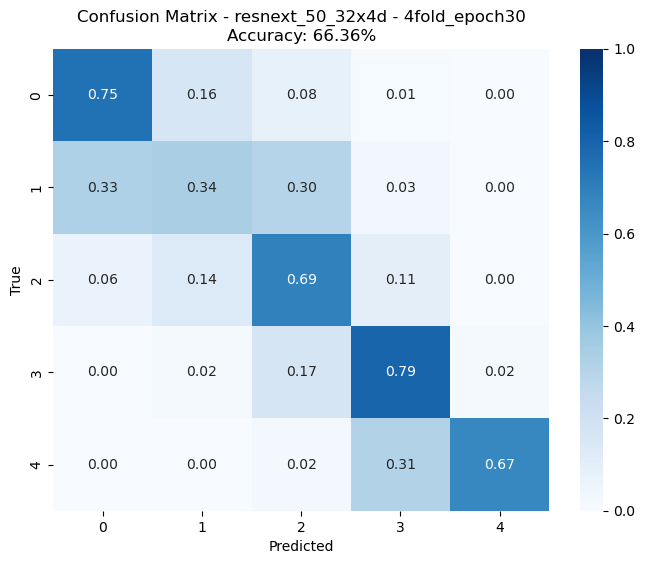

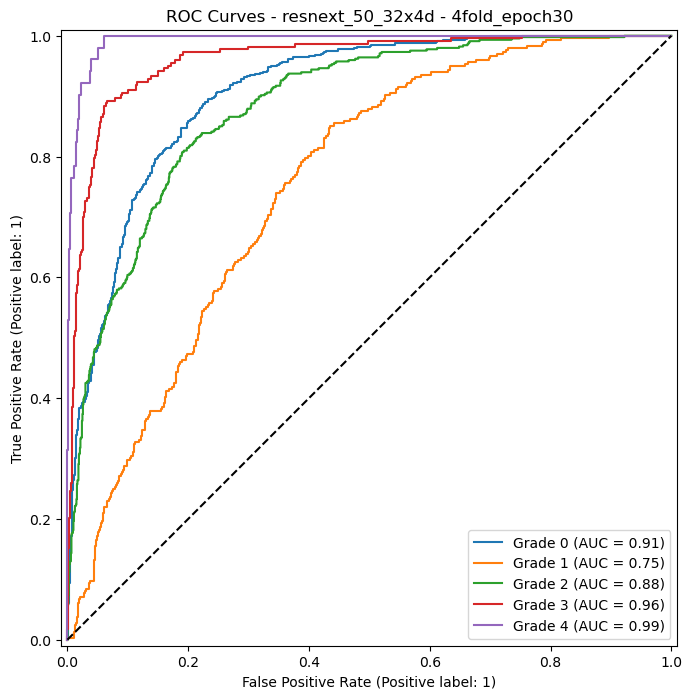


PERFORMANCE REPORT FOR: resnext_50_32x4d - 5fold_epoch30
Accuracy: 0.6993
F1 Macro: 0.6386

Classification Report:
              precision    recall  f1-score   support

           0     0.7375    0.8795    0.8023       639
           1     0.4459    0.1115    0.1784       296
           2     0.6349    0.8054    0.7101       447
           3     0.7828    0.7758    0.7793       223
           4     0.9375    0.5882    0.7229        51

    accuracy                         0.6993      1656
   macro avg     0.7077    0.6321    0.6386      1656
weighted avg     0.6700    0.6993    0.6603      1656



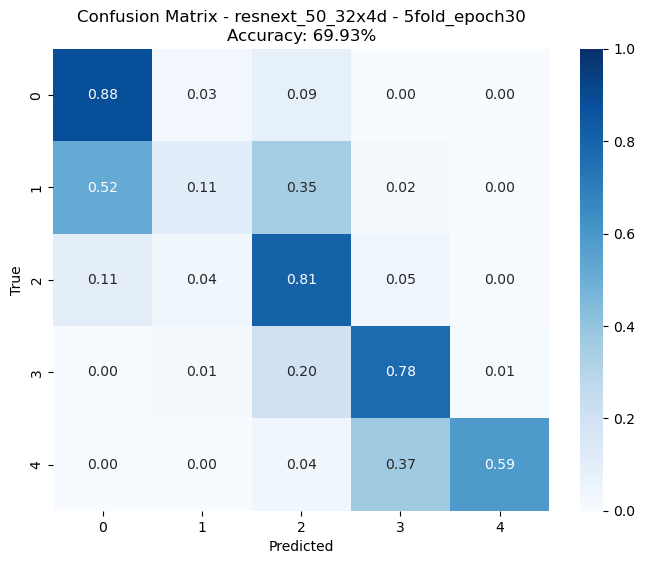

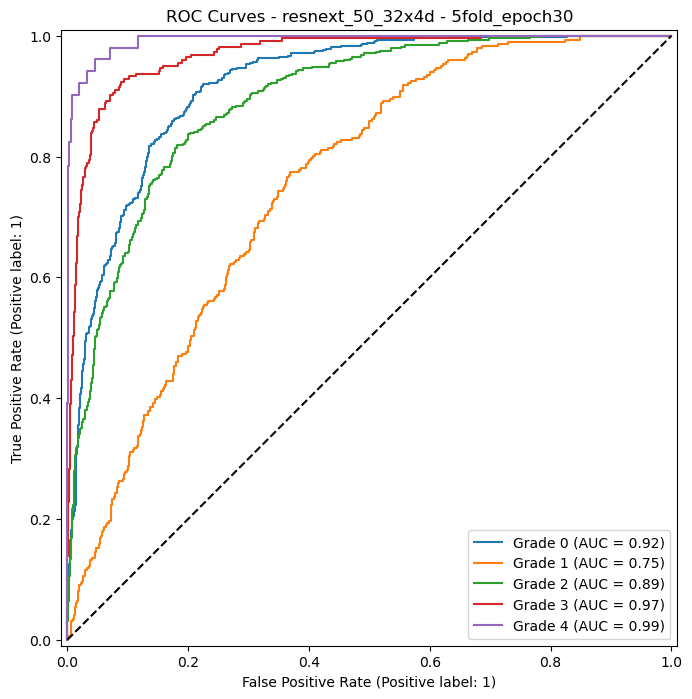


PERFORMANCE REPORT FOR: shufflenet_v2_x2_0 - 1fold_epoch30
Accuracy: 0.6667
F1 Macro: 0.6431

Classification Report:
              precision    recall  f1-score   support

           0     0.7519    0.7919    0.7713       639
           1     0.3357    0.1588    0.2156       296
           2     0.6026    0.7226    0.6572       447
           3     0.7235    0.8565    0.7844       223
           4     0.8605    0.7255    0.7872        51

    accuracy                         0.6667      1656
   macro avg     0.6548    0.6510    0.6431      1656
weighted avg     0.6367    0.6667    0.6434      1656



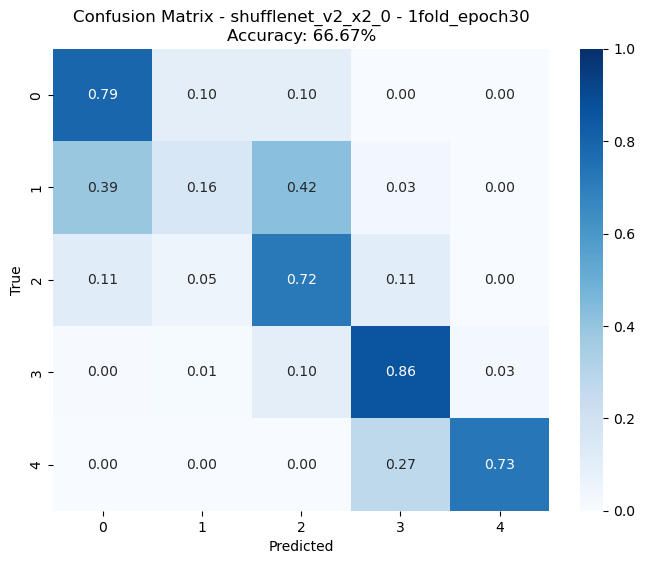

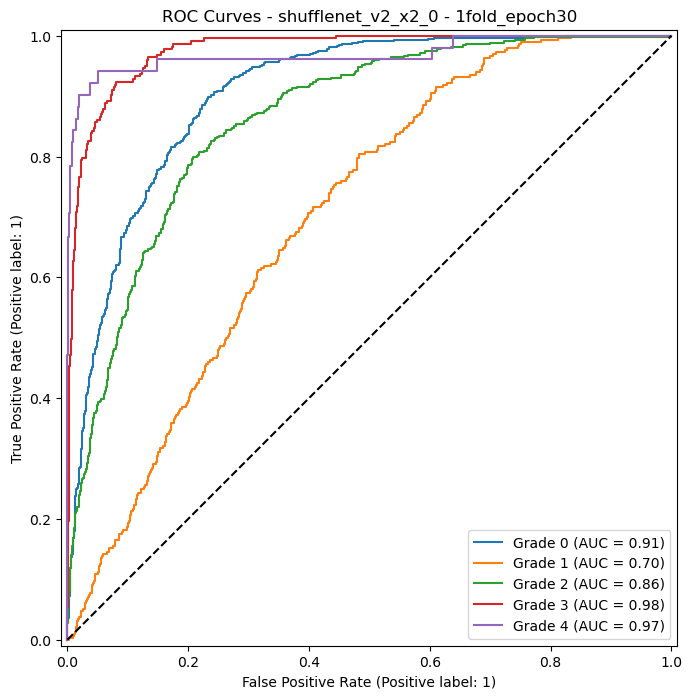


PERFORMANCE REPORT FOR: shufflenet_v2_x2_0 - 2fold_epoch30
Accuracy: 0.6455
F1 Macro: 0.5947

Classification Report:
              precision    recall  f1-score   support

           0     0.6344    0.9640    0.7652       639
           1     0.2857    0.0878    0.1344       296
           2     0.7190    0.4922    0.5843       447
           3     0.7524    0.7085    0.7298       223
           4     0.6282    0.9608    0.7597        51

    accuracy                         0.6455      1656
   macro avg     0.6039    0.6427    0.5947      1656
weighted avg     0.6106    0.6455    0.5987      1656



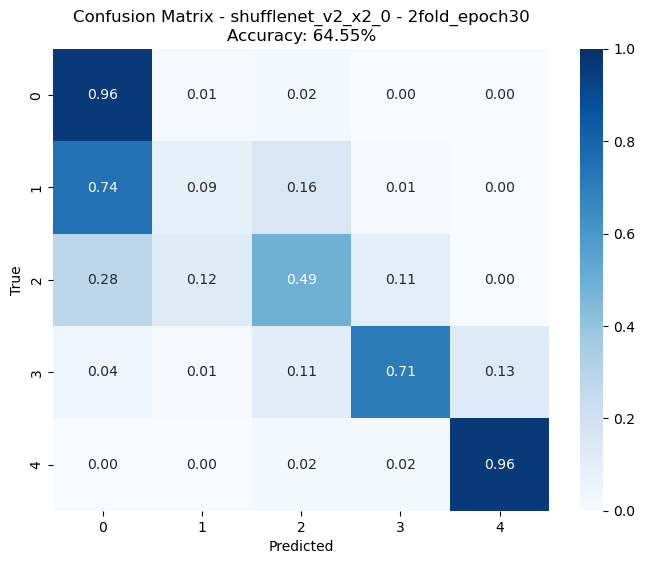

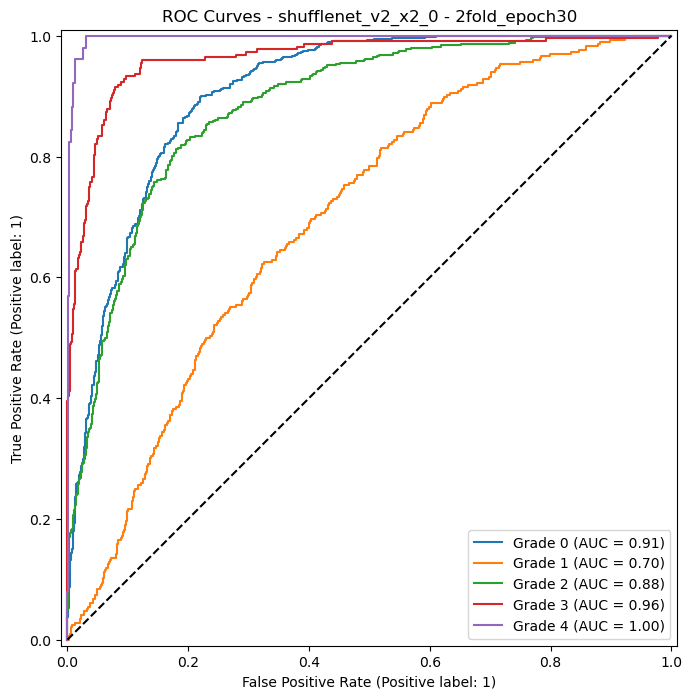


PERFORMANCE REPORT FOR: shufflenet_v2_x2_0 - 3fold_epoch30
Accuracy: 0.6667
F1 Macro: 0.6315

Classification Report:
              precision    recall  f1-score   support

           0     0.6159    0.9687    0.7530       639
           1     0.3718    0.0980    0.1551       296
           2     0.7403    0.5548    0.6343       447
           3     0.8643    0.7713    0.8152       223
           4     0.9231    0.7059    0.8000        51

    accuracy                         0.6667      1656
   macro avg     0.7031    0.6197    0.6315      1656
weighted avg     0.6488    0.6667    0.6239      1656



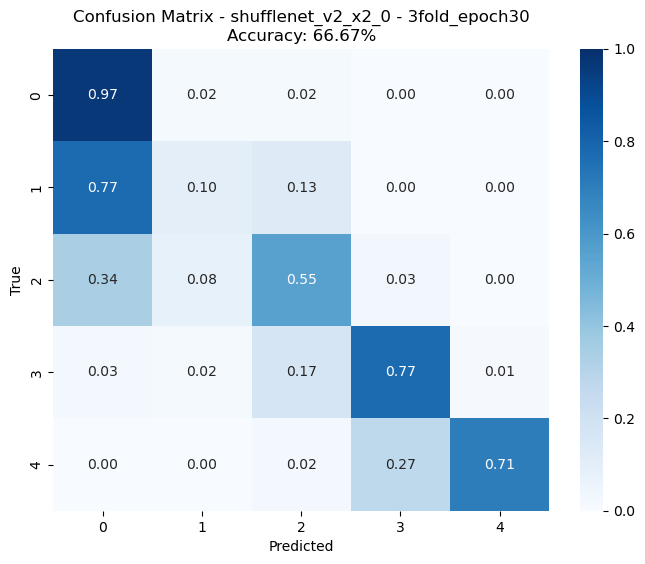

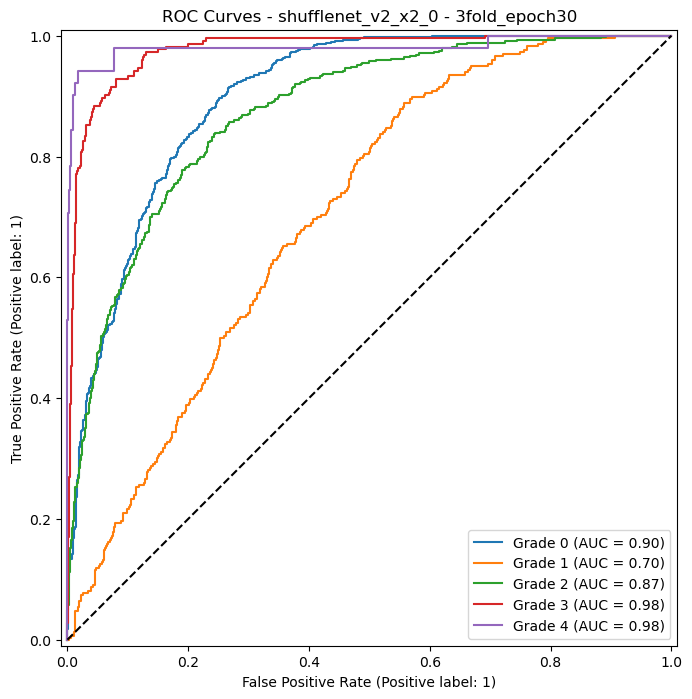


PERFORMANCE REPORT FOR: shufflenet_v2_x2_0 - 4fold_epoch30
Accuracy: 0.6636
F1 Macro: 0.6060

Classification Report:
              precision    recall  f1-score   support

           0     0.6267    0.9640    0.7596       639
           1     0.3208    0.0574    0.0974       296
           2     0.7339    0.5615    0.6362       447
           3     0.7627    0.8072    0.7843       223
           4     0.8333    0.6863    0.7527        51

    accuracy                         0.6636      1656
   macro avg     0.6555    0.6153    0.6060      1656
weighted avg     0.6256    0.6636    0.6110      1656



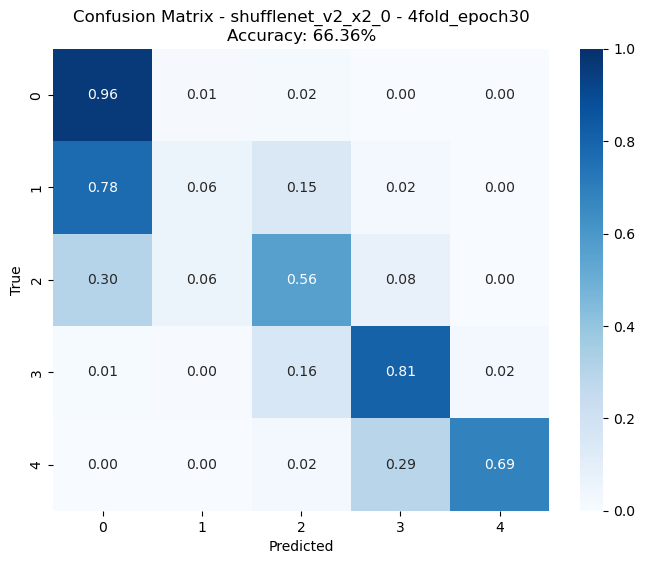

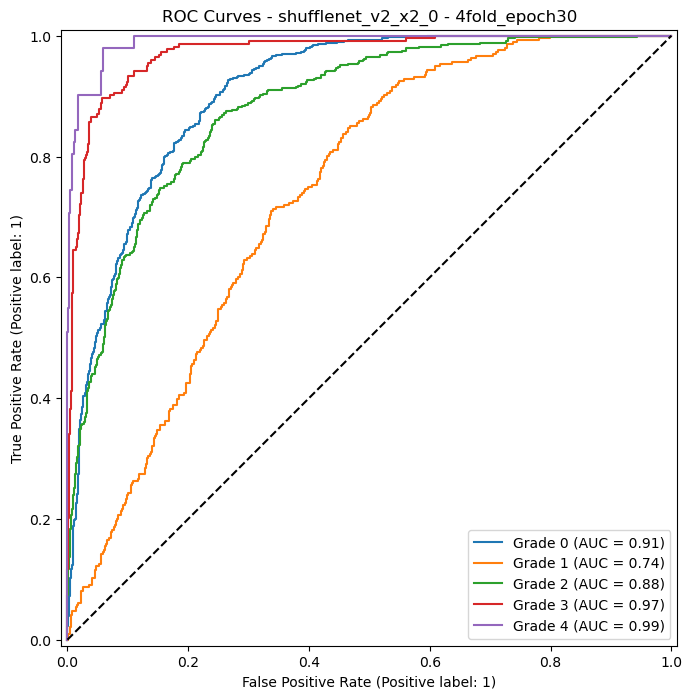


PERFORMANCE REPORT FOR: shufflenet_v2_x2_0 - 5fold_epoch30
Accuracy: 0.6860
F1 Macro: 0.6359

Classification Report:
              precision    recall  f1-score   support

           0     0.6849    0.9421    0.7931       639
           1     0.3937    0.1689    0.2364       296
           2     0.7143    0.6152    0.6611       447
           3     0.7669    0.8117    0.7887       223
           4     0.9655    0.5490    0.7000        51

    accuracy                         0.6860      1656
   macro avg     0.7051    0.6174    0.6359      1656
weighted avg     0.6605    0.6860    0.6545      1656



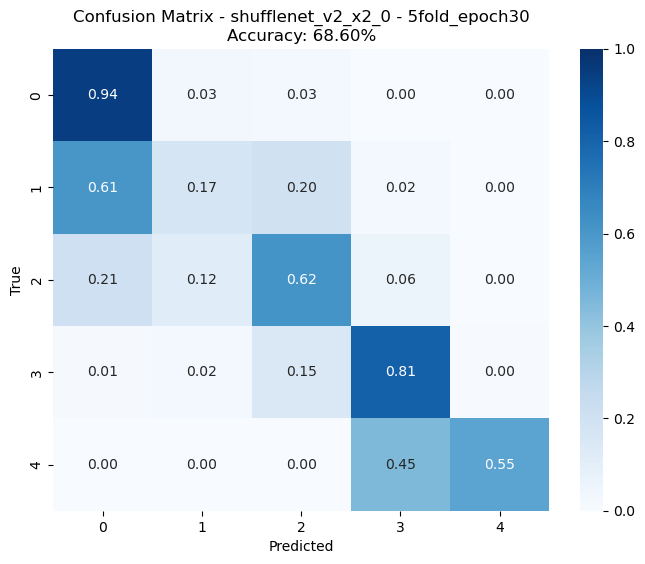

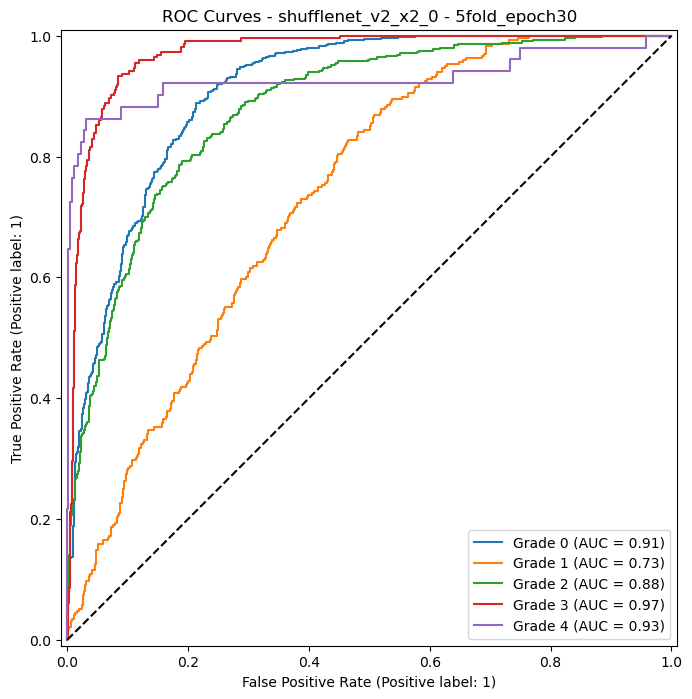


PERFORMANCE REPORT FOR: wide_resnet_50_2 - 1fold_epoch29
Accuracy: 0.6920
F1 Macro: 0.6183

Classification Report:
              precision    recall  f1-score   support

           0     0.6903    0.9280    0.7917       639
           1     0.4500    0.0304    0.0570       296
           2     0.6536    0.7472    0.6973       447
           3     0.7953    0.7668    0.7808       223
           4     0.7647    0.7647    0.7647        51

    accuracy                         0.6920      1656
   macro avg     0.6708    0.6474    0.6183      1656
weighted avg     0.6539    0.6920    0.6326      1656



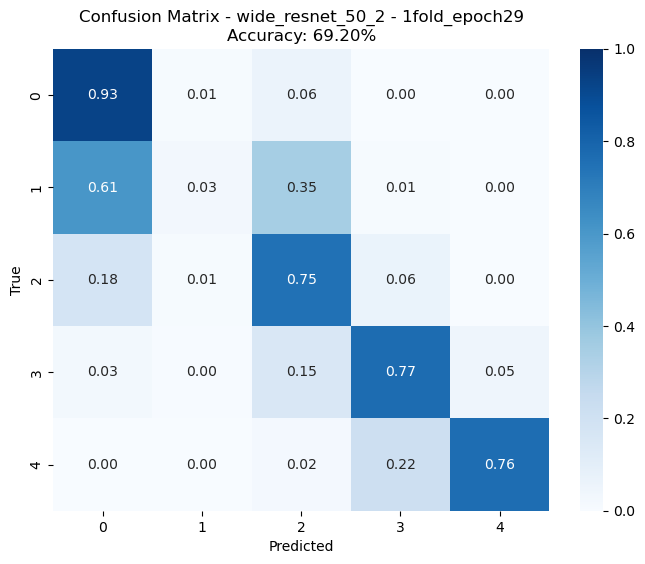

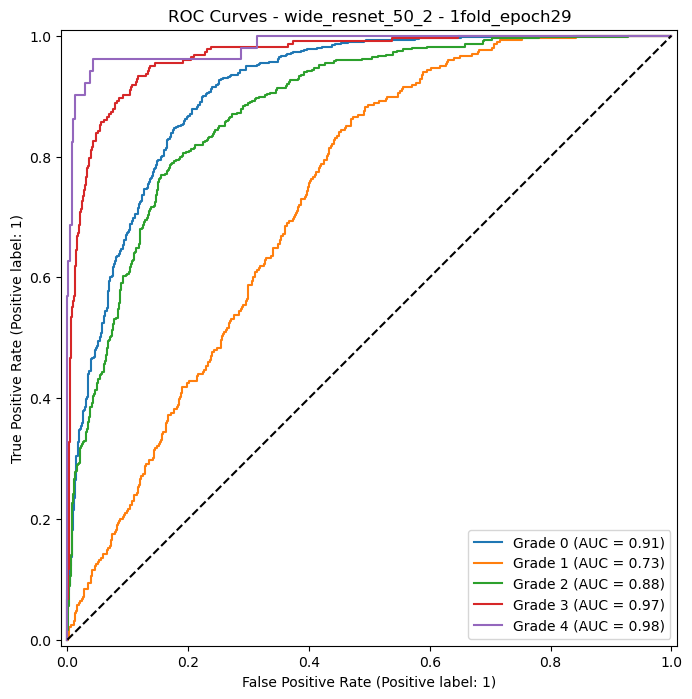


PERFORMANCE REPORT FOR: wide_resnet_50_2 - 2fold_epoch30
Accuracy: 0.6781
F1 Macro: 0.5967

Classification Report:
              precision    recall  f1-score   support

           0     0.7130    0.8826    0.7888       639
           1     0.4444    0.0135    0.0262       296
           2     0.6011    0.7383    0.6627       447
           3     0.7091    0.8744    0.7831       223
           4     0.9375    0.5882    0.7229        51

    accuracy                         0.6781      1656
   macro avg     0.6810    0.6194    0.5967      1656
weighted avg     0.6412    0.6781    0.6157      1656



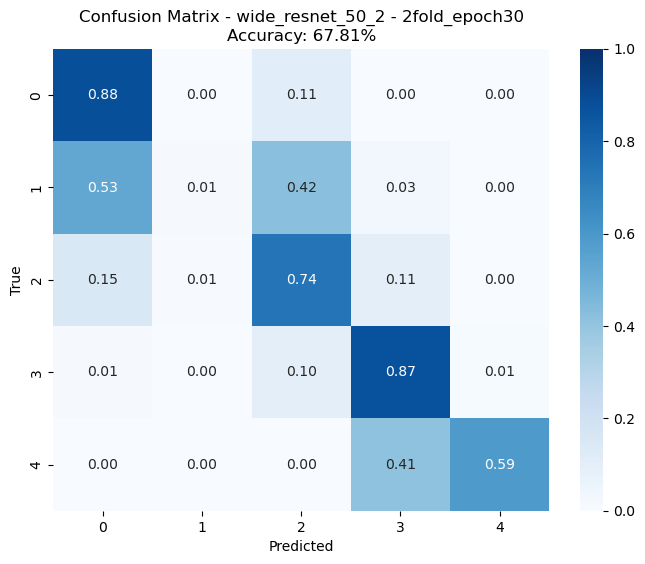

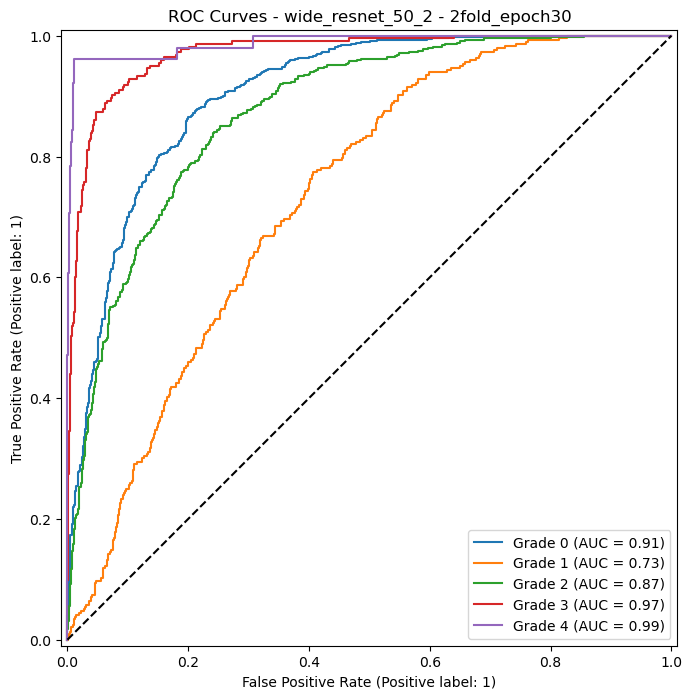


PERFORMANCE REPORT FOR: wide_resnet_50_2 - 3fold_epoch30
Accuracy: 0.6528
F1 Macro: 0.5758

Classification Report:
              precision    recall  f1-score   support

           0     0.6440    0.9343    0.7625       639
           1     0.2500    0.0203    0.0375       296
           2     0.6157    0.6846    0.6483       447
           3     0.8654    0.6054    0.7124       223
           4     0.7115    0.7255    0.7184        51

    accuracy                         0.6528      1656
   macro avg     0.6173    0.5940    0.5758      1656
weighted avg     0.5978    0.6528    0.5940      1656



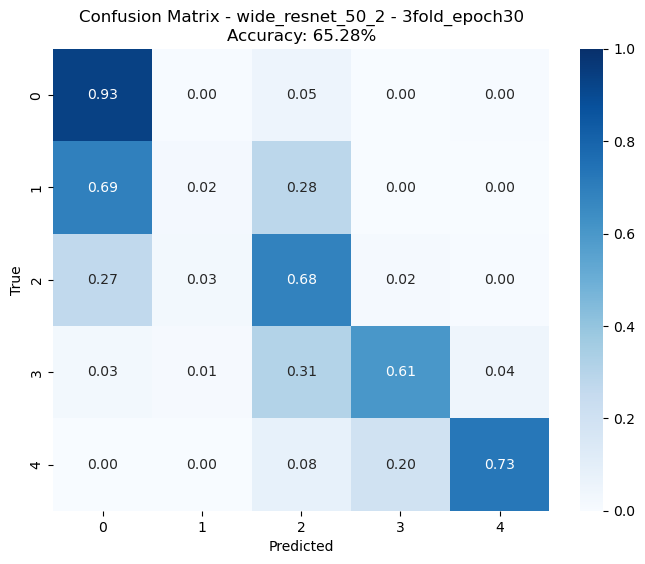

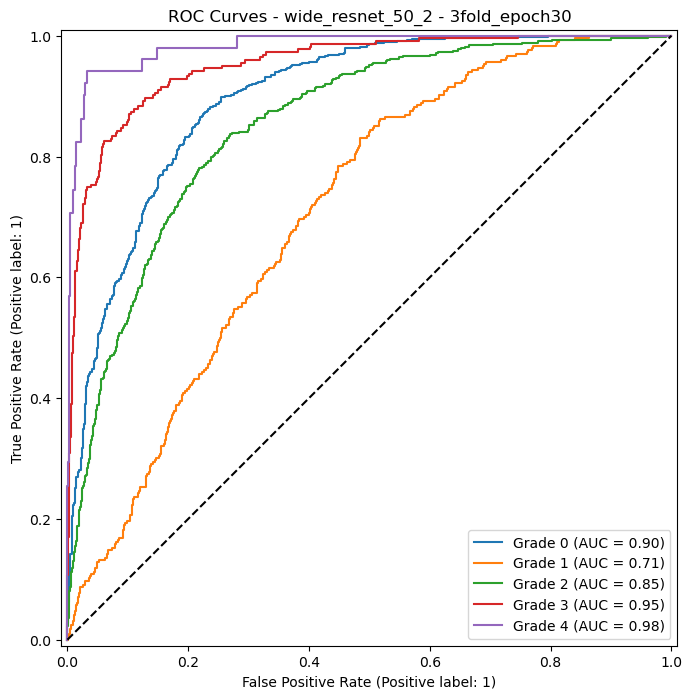


PERFORMANCE REPORT FOR: wide_resnet_50_2 - 4fold_epoch30
Accuracy: 0.6443
F1 Macro: 0.5715

Classification Report:
              precision    recall  f1-score   support

           0     0.6927    0.9030    0.7840       639
           1     0.2530    0.0709    0.1108       296
           2     0.5737    0.7405    0.6465       447
           3     0.8618    0.4753    0.6127       223
           4     0.8000    0.6275    0.7033        51

    accuracy                         0.6443      1656
   macro avg     0.6362    0.5634    0.5715      1656
weighted avg     0.6080    0.6443    0.6010      1656



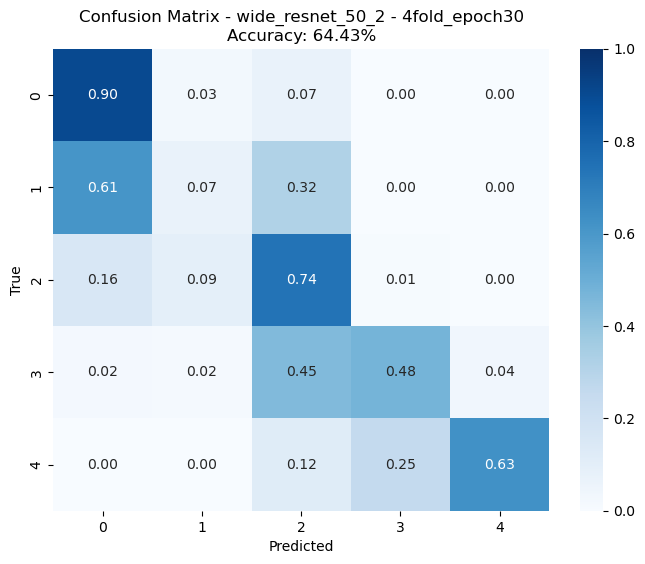

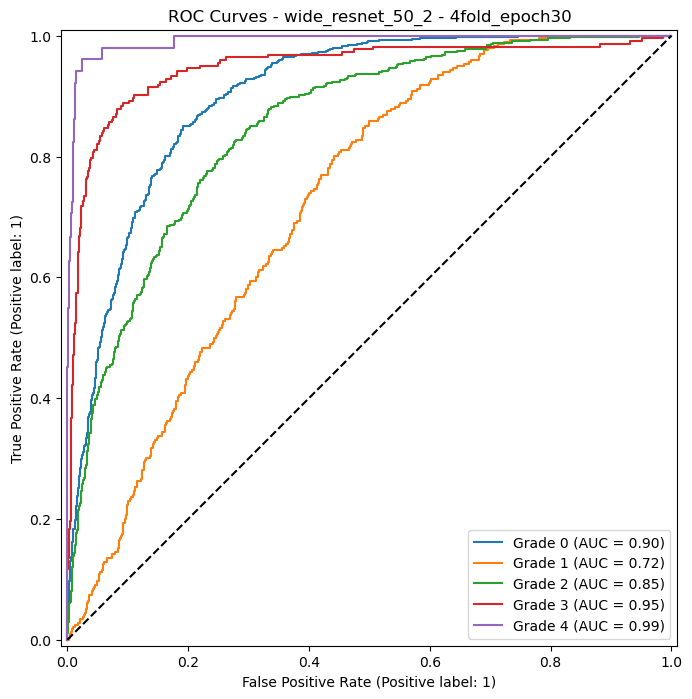


PERFORMANCE REPORT FOR: wide_resnet_50_2 - 5fold_epoch30
Accuracy: 0.6751
F1 Macro: 0.6557

Classification Report:
              precision    recall  f1-score   support

           0     0.7917    0.7731    0.7823       639
           1     0.3095    0.1757    0.2241       296
           2     0.5872    0.8434    0.6924       447
           3     0.8649    0.7175    0.7843       223
           4     0.9459    0.6863    0.7955        51

    accuracy                         0.6751      1656
   macro avg     0.6998    0.6392    0.6557      1656
weighted avg     0.6649    0.6751    0.6589      1656



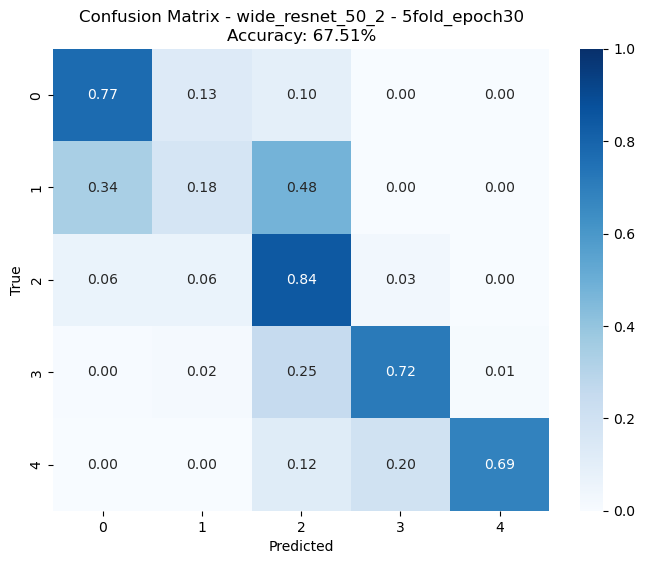

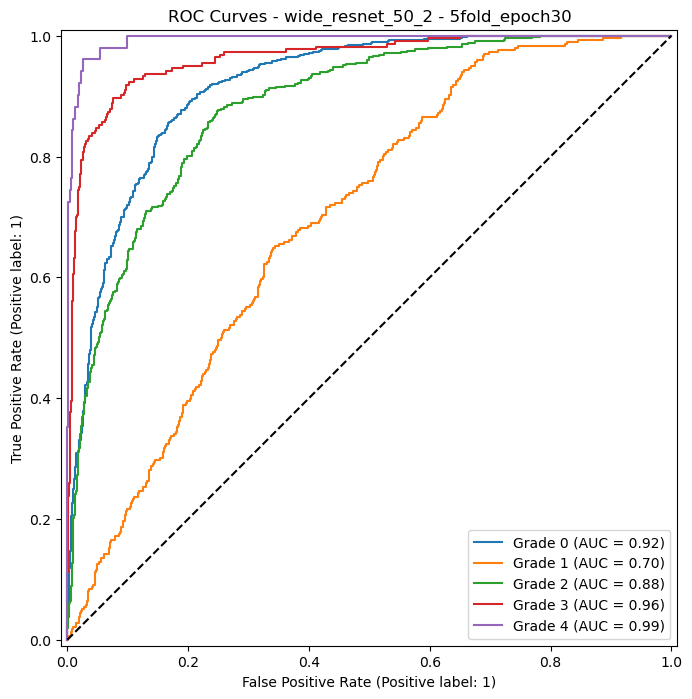

In [23]:
import natsort
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

def plot_individual_report(csv_path, truth_labels):
    """
    Loads a single submission CSV, calculates metrics,
    and plots CM and ROC curves.
    """
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"File not found: {csv_path}\n")
        return
    except Exception as e:
        print(f"Error loading {csv_path}: {e}\n")
        return

    # Extract model name from path for titles
    # e.g., ./submission/densenet_161/(224, 224)/1fold_epoch30_submission.csv
    model_name = csv_path.split('/')[-3]
    file_name = csv_path.split('/')[-1].replace('_submission.csv', '')
    title_name = f"{model_name} - {file_name}"

    preds = df['label'].values
    probs = df[['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4']].values
    
    # Metrics
    acc = accuracy_score(truth_labels, preds)
    f1 = f1_score(truth_labels, preds, average='macro')
    
    print(f"\n{'='*50}")
    print(f"PERFORMANCE REPORT FOR: {title_name}")
    print(f"{'='*50}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(truth_labels, preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(truth_labels, preds, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1)
    plt.title(f'Confusion Matrix - {title_name}\nAccuracy: {acc*100:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve (One vs Rest)
    try:
        y_test_bin = label_binarize(truth_labels, classes=[0, 1, 2, 3, 4])
        
        fig, ax = plt.subplots(figsize=(8, 8))
        for i in range(5):
            RocCurveDisplay.from_predictions(
                y_test_bin[:, i], 
                probs[:, i], 
                name=f'Grade {i}',
                ax=ax
            )
        plt.title(f'ROC Curves - {title_name}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.show()
    except Exception as e:
        print(f"Could not plot ROC curve: {e}")

# --- Main Driver Function to Show All Best Model Results ---
def show_all_individual_results():
    print("Loading ground truth labels...")
    try:
        test_csv = pd.read_csv('../KneeXray/test/test_correct.csv')
        truth_labels = test_csv['label'].values
    except Exception as e:
        print(f"Failed to load test_correct.csv. Aborting. Error: {e}")
        return

    base_sub_dir = './submission'
    all_best_csvs = []

    for root, dirs, files in os.walk(base_sub_dir):
        csv_files = [f for f in files if f.endswith('.csv') and 'ensemble' not in f]
        
        if not csv_files:
            continue
            
        # --- Filtering Logic ---
        best_csvs_per_fold = {}
        for f in csv_files:
            try:
                parts = f.split('fold_epoch')
                if len(parts) < 2: continue
                
                fold_num = int(parts[0])
                epoch_num = int(parts[1].split('_submission.csv')[0])
                
                if fold_num not in best_csvs_per_fold:
                    best_csvs_per_fold[fold_num] = (epoch_num, f)
                else:
                    if epoch_num > best_csvs_per_fold[fold_num][0]:
                        best_csvs_per_fold[fold_num] = (epoch_num, f)
            except Exception as e:
                print(f"Could not parse filename: {f}. Skipping.")
        
        for (epoch, f_name) in best_csvs_per_fold.values():
            all_best_csvs.append(os.path.join(root, f_name))
            
    if not all_best_csvs:
        print("No best-submission files found to score.")
        return

    print(f"Found {len(all_best_csvs)} best models. Generating reports...")
    
    # --- Generate report for each CSV ---
    # We sort them so they appear in order (all densenet, then all efficientnet, etc.)
    for csv_path in natsort.natsorted(all_best_csvs):
        plot_individual_report(csv_path, truth_labels)

# --- Run the function ---
show_all_individual_results()